<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/CHFUSD/CHFUSD_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CHFUSD=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  0.9485  0.9485  0.9302  0.9392     0.9392       0
2009-01-02  0.9393  0.9419  0.9226  0.9267     0.9267       0
2009-01-05  0.9336  0.9340  0.8998  0.9020     0.9020       0
2009-01-06  0.9020  0.9030  0.8870  0.8957     0.8957       0
2009-01-07  0.8957  0.9189  0.8931  0.9060     0.9060       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.0138  1.0147  1.0073  1.0141     1.0141       0
2018-12-27  1.0056  1.0157  1.0055  1.0057     1.0057       0
2018-12-28  1.0131  1.0213  1.0131  1.0133     1.0133       0
2018-12-31  1.0166  1.0175  1.0129  1.0167     1.0167       0
2019-01-01  1.0168  1.0193  1.0166  1.0168     1.0168       0

[2602 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2602.000000  2602.000000  2602.000000  2602.000000  2602.000000  2602.0
mean      1.035091     1.039342     1.030923     1.035119     1.035119     0.0
std       0.070219     0.070837     0.069902     0.070188     0.070188     0.0
min       0.841300     0.844500     0.817300     0.842600     0.842600     0.0
25%       1.002025     1.004750     0.998600     1.002125     1.002125     0.0
50%       1.034600     1.038350     1.030250     1.034650     1.034650     0.0
75%       1.077050     1.080675     1.072400     1.077100     1.077100     0.0
max       1.384100     1.392200     1.367800     1.383500     1.383500     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.8656  0.8696  0.8367  0.8426     0.8426   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.849811  0.849131 -0.874100  0.855262  0.856462  0.864643     0.85405     0.85540  0.874100  0.856863  0.854391  0.859430  0.857381  0.856863  0.856933  0.857991                0.872201                 0.856863                0.841524                0.879870                 0.856863                0.833855                0.887539                 0.856863                0.826186                0.895209                 0.856863                0.818516  0.856462  0.853115  0.857591                0.871801                 0.856462                0.841124                0.879470                 0.856462                0.833454                0.887139                 0.856462                0.825785                0.894808                 0.856462                0.818116   
2009-03-13  0.8425  0.8445  0.8381  0.8442     0.8442   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.849530  0.849141 -0.871108  0.850685  0.853737  0.864332     0.85405     0.85540  0.871108  0.856338  0.848566  0.859140  0.854567  0.856338  0.843400  0.857724                0.873027                 0.856338                0.839648                0.881371                 0.856338                0.831304                0.889716                 0.856338                0.822959                0.898060                 0.856338                0.814615  0.853737  0.846101  0.857353                0.870426                 0.853737                0.837048                0.878771                 0.853737                0.828703                0.887116                 0.853737                0.820359                0.895460                 0.853737                0.812014   
2009-03-16  0.8413  0.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000    2552.000000   2552.000000     2552.000000     2552.000000       2552.000000  2552.000000  2552.000000  2552.000000  2552.000000   2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000  2552.000000  2552.000000  2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000   
mean      1.038248     1.042442     1.034154     1.038284     1.038284    15.755878     1.999608   185.952194      30.467085      0.032915        0.966693        0.010972          0.989028     6.616771     2.537226    27.012539     1.999608      1.999216    27.012539     1.038117     1.037633     0.013970     1.038283     1.038075     1.038560     1.038185     1.038595     1.039813     1.038075     1.038286     1.038076     1.038145     1.038075     1.038295     1.037660                1.051130                 1.038075                1.025019                1.057658                 1.038075                1.018492                1.064186                 1.038075                1.011964                1.070713                 1.038075                1.005436     1.038075     1.038258     1.037721                1.051130                 1.038075                1.025019                1.057658                 1.038075                1.018491                1.064186   
std       0.067062     0.067859     0.066561     0.067026     0.067026     8.801503     1.414906   104.339915       0.781809      0.178450        0.179473        0.104191          0.104191     3.411489     1.107415    14.920666     1.414906      1.414768    14.920666     0.066385     0.066205     1.041379     0.067169     0.066530     0.067970     0.066957     0.067558     0.071288     0.066771     0.067147     0.066890     0.066752     0.066771     0.066967     0.066532                0.070269                 0.066771                0.065164                0.072648                 0.066771                0.065120                0.075397                 0.066771                0.065587                0.078475                 0.066771                0.066556     0.066530     0.066870     0.066560                0.070062                 0.066530                0.064893                0.072459                 0.066530                0.064837                0.075224   
min       0.841300     0.844500     0.817300     0.842600     0.842600     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.044768  0.045828  0.035241  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.001386  0.000000  0.192174  0.016366  0.012191  0.004079    0.000000    0.000000  0.098800  0.005883  0.017653  0.015784  0.014802  0.005883  0.025209  0.003961                0.008412                 0.005883                0.041245                0.018232                 0.005883                0.093947                0.026710                 0.005883                0.217534                0.033955                 0.005883                0.314536  0.012191  0.015702  0.004017                0.005725                 0.012191                0.023878                0.015006                 0.012191                0.051327                0.024182                 0.012191                0.173210                0.031620                 0.012191   
2009-03-13  0.002211  0.000000  0.037784  0.002958   0.002958   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.000788  0.000023  0.193284  0.007571  0.006489  0.003436    0.000000    0.000000  0.093595  0.004775  0.006730  0.015185  0.009055  0.004775  0.000000  0.003346                0.009958                 0.004775                0.037004                0.020825                 0.004775                0.088374                0.030197                 0.004775                0.211493                0.038205                 0.004775                0.308184  0.006489  0.002403  0.003475                0.003139                 0.006489                0.014440                0.013769                 0.006489                0.040605                0.024143                 0.006489                0.162617                0.032615                 0.006489   
2009-03-16  0.000000  0.004199  0.040872  0.002958   0.002958   16          0         75

137835

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphz6byy92
  JVM stdout: /tmp/tmphz6byy92/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphz6byy92/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_11cy5i
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.560730  0.705595              0.480469  0.504659  0.254680
1  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.545227  0.696721              0.488281  0.501815  0.251818
2  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.537537  0.735377              0.437500  0.515259  0.265492
3  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.528809  1.018332              0.453125  0.588719  0.346590
4  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.526489  0.695219              0.496094  0.500965  0.250966
5              DeepLearning_1_AutoML_20190822_120611  0.519653  0.746135              0.496094  0.513743  0.263931
6  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.515503  0.733934              0.492188  0.510412  0.260521
7  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.513275  0.702889              0.453125  0.504711  0.254733
8  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.506897  0.741158              0.488281  0.518914  0.269271
9  DeepLearning_grid_1_AutoML_20190822_120611_mod...  0.495789  2.441935              0.460938  0.659933  0.435512

variable  relative_importance  scaled_importance  percentage
0           CDLSEPARATINGLINES             1.000000           1.000000    0.003227
1                    CDLONNECK             0.964833           0.964833    0.003113
2               CDLEVENINGSTAR             0.942550           0.942550    0.003042
3           CDLEVENINGDOJISTAR             0.908517           0.908517    0.002932
4                  CDLPIERCING             0.906712           0.906712    0.002926
...                        ...                  ...                ...         ...
1017     LINEARREG_INTERCEPT_8             0.243748           0.243748    0.000787
1018   BBANDS_upperband_20_2_3             0.243563           0.243563    0.000786
1019   BBANDS_upperband_24_6_3             0.242808           0.242808    0.000784
1020  BBANDS_middleband_24_0_2             0.239993           0.239993    0.000774
1021             CDLHIKKAKEMOD             0.239376           0.239376    0.000772

[1022 rows x 4 columns]

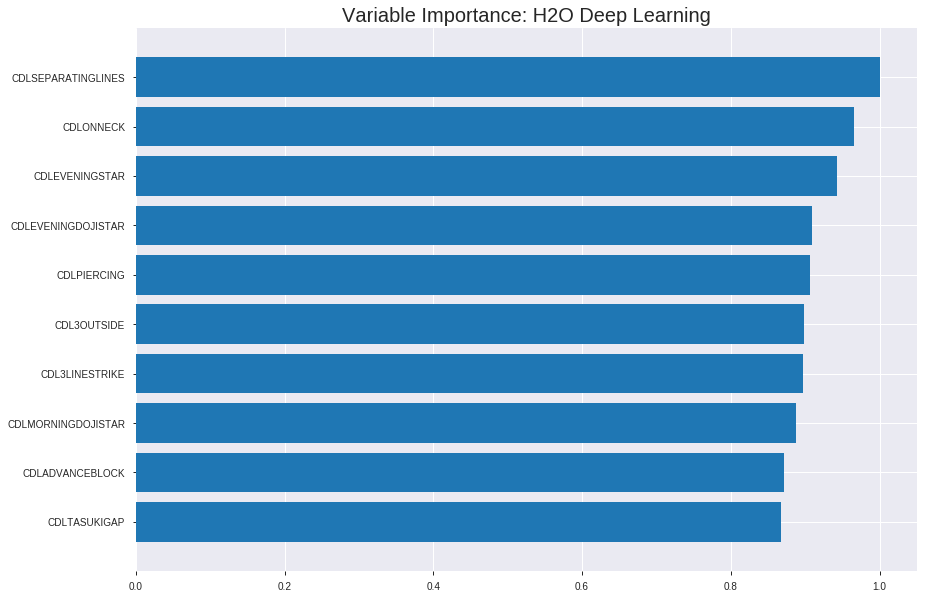

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_120611_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22785773583300398
RMSE: 0.4773444624513874
LogLoss: 0.6965253851039176
Mean Per-Class Error: 0.3380749450041687
AUC: 0.6943085592598918
pr_auc: 0.6746495923768667
Gini: 0.38861711851978353
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3684818497587652: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      427  477   0.5277   (477.0/904.0)
1      173  708   0.1964   (173.0/881.0)
Total  600  1185  0.3641   (650.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368482     0.685382  251
max f2                       0.000746417  0.831127  398
max f0point5                 0.445519     0.653391  213
max accuracy                 0.438388     0.661064  217
max precision                0.995898     1         0
max recall                   6.08182e-05  1         399
max specificity              0.995898     1         0
max absolute_mcc             0.438388     0.326569  217
max min_per_class_accuracy   0.483144     0.653761  194
max mean_per_class_accuracy  0.438388     0.661925  217

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 45.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.864489           1.57586   1.57586            0.777778         0.911633   0.777778                    0.911633            0.015891        0.015891                   57.5861   57.5861
    2        0.0201681                   0.822873           1.80098   1.68842            0.888889         0.842953   0.833333                    0.877293            0.0181612       0.0340522                  80.0984   68.8422
    3        0.0302521                   0.802687           1.80098   1.72594            0.888889         0.812535   0.851852                    0.855707            0.0181612       0.0522134                  80.0984   72.5943
    4        0.0403361                   0.789935           1.4633    1.66028            0.722222         0.794988   0.819444                    0.840527            0.014756        0.0669694                  46.3299   66.0282
    5        0.0504202                   0.774737           1.80098   1.68842            0.888889         0.782274   0.833333                    0.828877            0.0181612       0.0851305                  80.0984   68.8422
    6        0.10028                     0.723296           1.50251   1.59598            0.741573         0.745712   0.787709                    0.787527            0.0749149       0.160045                   50.2506   59.5983
    7        0.15014                     0.675447           1.25209   1.48178            0.617978         0.698199   0.731343                    0.757862            0.0624291       0.222474                   25.2088   48.178
    8        0.2                         0.641008           1.32038   1.44154            0.651685         0.657084   0.711485                    0.732738            0.0658343       0.288309                   32.0384   44.1544
    9        0.30028                     0.588811           1.30169   1.39484            0.642458         0.613713   0.688433                    0.692989            0.130533        0.418842                   30.1689   39.4838
    10       0.4                         0.535935           1.22932   1.35358            0.606742         0.56274    0.668067                    0.660518            0.122588        0.54143                    22.9323   35.3575
    11       0.50028                     0.479771           1.1319    1.30914            0.558659         0.50767    0.646137                    0.62988             0.113507        0.654938                   13.1903   30.9142
    12       0.6                         0.415612           1.00167   1.25804            0.494382         0.447019   0.620915                    0.599488            0.0998865       0.754824                   0.167073  25.804
    13       0.69972                     0.342902           0.671575  1.17446            0.331461         0.379261   0.579664                    0.568103            0.0669694       0.821793                   -32.8425  17.4461
    14       0.8                         0.251443           0.645185  1.10812            0.318436         0.301375   0.546919                    0.534669            0.0646992       0.886493                   -35.4815  10.8116
    15       0.89972                     0.114257           0.614662  1.05342            0.303371         0.183609   0.519925                    0.495759            0.061294        0.947787                   -38.5338  5.34241
    16       1                           1.00266e-15        0.520675  1                  0.256983         0.0393258  0.493557                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23766322834901665
RMSE: 0.4875071572285033
LogLoss: 0.6704176050859904
Mean Per-Class Error: 0.3950535582368875
AUC: 0.6289630017237133
pr_auc: 0.5936322863324051
Gini: 0.25792600344742667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26575959132870414: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   236  0.9008   (236.0/262.0)
1      4    244  0.0161   (4.0/248.0)
Total  30   480  0.4706   (240.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26576      0.67033   369
max f2                       0.26576      0.828804  369
max f0point5                 0.460615     0.596361  231
max accuracy                 0.545594     0.605882  141
max precision                0.951935     1         0
max recall                   0.0249188    1         398
max specificity              0.951935     1         0
max absolute_mcc             0.460615     0.214683  231
max min_per_class_accuracy   0.500422     0.572581  189
max mean_per_class_accuracy  0.460615     0.604946  231

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.772475           1.37097   1.37097            0.666667         0.83692   0.666667                    0.83692             0.016129        0.016129                   37.0968   37.0968
    2        0.0215686                   0.719556           1.64516   1.4956             0.8              0.732415  0.727273                    0.789418            0.016129        0.0322581                  64.5161   49.5601
    3        0.0313725                   0.705089           1.64516   1.54234            0.8              0.711164  0.75                        0.764964            0.016129        0.0483871                  64.5161   54.2339
    4        0.0411765                   0.696352           1.64516   1.56682            0.8              0.700868  0.761905                    0.749703            0.016129        0.0645161                  64.5161   56.682
    5        0.0509804                   0.692154           0.822581  1.4237             0.4              0.694927  0.692308                    0.739169            0.00806452      0.0725806                  -17.7419  42.3697
    6        0.1                         0.641393           1.39839   1.41129            0.68             0.663202  0.686275                    0.70193             0.0685484       0.141129                   39.8387   41.129
    7        0.15098                     0.617692           1.10732   1.30865            0.538462         0.630659  0.636364                    0.677865            0.0564516       0.197581                   10.732    30.8651
    8        0.2                         0.599531           1.15161   1.27016            0.56             0.609067  0.617647                    0.661003            0.0564516       0.254032                   15.1613   27.0161
    9        0.3                         0.564176           1.29032   1.27688            0.627451         0.580462  0.620915                    0.634156            0.129032        0.383065                   29.0323   27.6882
    10       0.4                         0.530022           1.08871   1.22984            0.529412         0.546703  0.598039                    0.612293            0.108871        0.491935                   8.87097   22.9839
    11       0.5                         0.499171           0.806452  1.14516            0.392157         0.514309  0.556863                    0.592696            0.0806452       0.572581                   -19.3548  14.5161
    12       0.6                         0.461748           1.33065   1.17608            0.647059         0.480069  0.571895                    0.573925            0.133065        0.705645                   33.0645   17.6075
    13       0.7                         0.429511           0.846774  1.12903            0.411765         0.446745  0.54902                     0.555756            0.0846774       0.790323                   -15.3226  12.9032
    14       0.8                         0.379408           0.766129  1.08367            0.372549         0.404648  0.526961                    0.536868            0.0766129       0.866935                   -23.3871  8.36694
    15       0.9                         0.313301           0.685484  1.03943            0.333333         0.349561  0.505447                    0.516056            0.0685484       0.935484                   -31.4516  3.94265
    16       1                           0.00281346         0.645161  1                  0.313725         0.236867  0.486275                    0.488137           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:09:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:09:09  2 min 51.399 sec  332 obs/sec       0.413445  1             738        0.656447         3.91651             -0.723976      0.524741        0.46205            1.01305          0.506443                         0.61988            1.74138               -0.538162        0.554897          0.519208             0.685484           0.488235
    2019-08-22 12:09:20  3 min  2.970 sec  456 obs/sec       3.27059   8             5838       0.605152         2.01255             -0.465077      0.628293        0.505639           1.4633           0.466106                         0.579048           1.46378               -0.342196        0.618321          0.561373             1.71371            0.498039
    2019-08-22 12:09:31  3 min 13.248 sec  464 obs/sec       5.73557   14            10238      0.594833         2.91593             -0.415542      0.613497        0.409787           1.81283          0.47451                          0.662243           3.11409               -0.755583        0.59248           0.502821             1.71371            0.476471
    2019-08-22 12:09:41  3 min 23.990 sec  482 obs/sec       8.59328   21            15339      0.584668         1.96543             -0.367575      0.594868        0.557242           1.12561          0.506443                         0.56146            1.1109                -0.261902        0.613603          0.579419             1.02823            0.5
    2019-08-22 12:09:52  3 min 34.663 sec  494 obs/sec       11.4863   28            20503      0.556011         1.29128             -0.2368        0.627777        0.587494           1.80098          0.47395                          0.584008           1.16777               -0.365293        0.596351          0.586991             1.71371            0.494118
    2019-08-22 12:10:03  3 min 45.685 sec  498 obs/sec       14.3832   35            25674      0.526504         0.939104            -0.10901       0.644561        0.611914           1.4633           0.45098                          0.497089           0.705014              0.0108639        0.640506          0.625111             1.71371            0.458824
    2019-08-22 12:10:14  3 min 56.354 sec  492 obs/sec       16.8392   41            30058      0.511116         0.920315            -0.0451335     0.654381        0.639491           1.91355          0.426891                         0.539832           0.830407              -0.166554        0.619029          0.612867             2.05645            0.484314
    2019-08-22 12:10:25  4 min  7.953 sec  500 obs/sec       20.0829   49            35848      0.519116         0.790639            -0.0781048     0.681099        0.645822           1.80098          0.396639                         0.49975            0.698968              0.000244808      0.624508          0.609088             2.05645            0.452941
    2019-08-22 12:10:36  4 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSEPARATINGLINES        1.0                    1.0                  0.003226974803759484
CDLONNECK                 0.9648334980010986     0.9648334980010986   0.0031134933878726716
CDLEVENINGSTAR            0.9425504207611084     0.9425504207611084   0.0030415864590689966
CDLEVENINGDOJISTAR        0.9085171222686768     0.9085171222686768   0.002931761862345094
CDLPIERCING               0.9067115783691406     0.9067115783691406   0.002925935417674209
---                       ---                    ---                  ---
LINEARREG_INTERCEPT_8     0.24374772608280182    0.24374772608280182  0.0007865677705428698
BBANDS_upperband_20_2_3   0.2435627430677414     0.2435627430677414   0.0007859708350141464
BBANDS_upperband_24_6_3   0.24280790984630585    0.24280790984630585  0.0007835350072275333
BBANDS_middleband_24_0_2  0.23999300599098206    0.23999300599098206  0.0007744513834113979
CDLHIKKAKEMOD             0.23937609791755676    0.23937609791755676  0.0007724606366022187


See the whole table with table.as_data_frame()


('accuracy', 0.5703125)

('F1', 0.6754617414248021)

('auc', 0.56072998046875)

('logloss', 0.7055954301250736)

('mean_per_class_error', 0.4296875)

('rmse', 0.5046587306847331)

('mse', 0.254680434456326)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


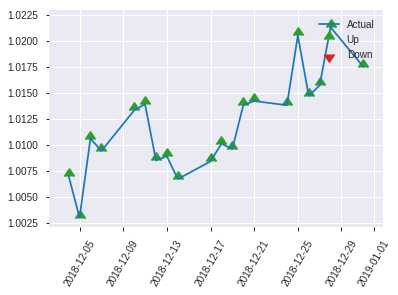


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.254680434456326
RMSE: 0.5046587306847331
LogLoss: 0.7055954301250736
Mean Per-Class Error: 0.4296875
AUC: 0.56072998046875
pr_auc: 0.5327251084271917
Gini: 0.1214599609375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12387394989419709: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    123  0.9609   (123.0/128.0)
1      0    128  0        (0.0/128.0)
Total  5    251  0.4805   (123.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123874     0.675462  250
max f2                       0.123874     0.838794  250
max f0point5                 0.383192     0.587924  203
max accuracy                 0.469179     0.570312  157
max precision                0.90682      1         0
max recall                   0.123874     1         250
max specificity              0.90682      1         0
max absolute_mcc             0.383192     0.174766  203
max min_per_class_accuracy   0.514609     0.546875  127
max mean_per_class_accuracy  0.469179     0.570312  157

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.744732           1.33333   1.33333            0.666667         0.803477  0.666667                    0.803477            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.713671           1.33333   1.33333            0.666667         0.724278  0.666667                    0.763878            0.015625        0.03125                    33.3333   33.3333
    3        0.03125                     0.706179           1         1.25               0.5              0.710355  0.625                       0.750497            0.0078125       0.0390625                  0         25
    4        0.0429688                   0.697396           1.33333   1.27273            0.666667         0.701439  0.636364                    0.737118            0.015625        0.0546875                  33.3333   27.2727
    5        0.0507812                   0.692358           0         1.07692            0                0.695779  0.538462                    0.730758            0               0.0546875                  -100      7.69231
    6        0.101562                    0.661806           0.923077  1                  0.461538         0.677707  0.5                         0.704233            0.046875        0.101562                   -7.69231  0
    7        0.152344                    0.635008           1.07692   1.02564            0.538462         0.647149  0.512821                    0.685205            0.0546875       0.15625                    7.69231   2.5641
    8        0.203125                    0.60816            1.23077   1.07692            0.615385         0.620094  0.538462                    0.668927            0.0625          0.21875                    23.0769   7.69231
    9        0.300781                    0.574954           0.88      1.01299            0.44             0.589043  0.506494                    0.642991            0.0859375       0.304688                   -12       1.2987
    10       0.402344                    0.551161           1.23077   1.06796            0.615385         0.562982  0.533981                    0.622794            0.125           0.429688                   23.0769   6.79612
    11       0.5                         0.514375           1.2       1.09375            0.6              0.530315  0.546875                    0.604732            0.117188        0.546875                   20        9.375
    12       0.601562                    0.478056           1.07692   1.09091            0.538462         0.499157  0.545455                    0.586908            0.109375        0.65625                    7.69231   9.09091
    13       0.699219                    0.435526           1.12      1.09497            0.56             0.458184  0.547486                    0.568929            0.109375        0.765625                   12        9.49721
    14       0.800781                    0.379586           1         1.08293            0.5              0.413031  0.541463                    0.549157            0.101562        0.867188                   0         8.29268
    15       0.898438                    0.293733           0.48      1.01739            0.24             0.341687  0.508696                    0.526606            0.046875        0.914062                   -52       1.73913
    16       1                           0.0191654          0.846154  1                  0.423077         0.187488  0.5                         0.492164            0.0859375   

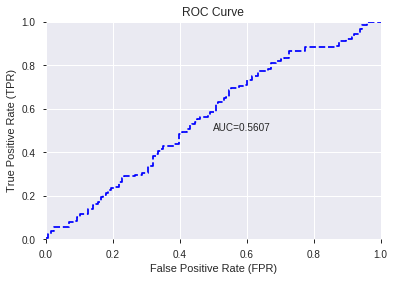

This function is available for GLM models only


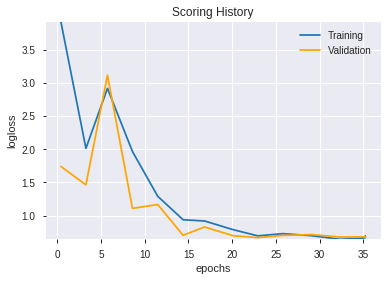

--2019-08-22 12:30:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  12.6MB/s    in 29s     

2019-08-22 12:31:24 (12.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_120611_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_120611_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_123136_model_6  0.587341  0.677706              0.437500  0.492651  0.242705
1  DeepLearning_grid_1_AutoML_20190822_123136_model_4  0.569336  0.758985              0.449219  0.521749  0.272222
2  DeepLearning_grid_1_AutoML_20190822_123136_model_9  0.564148  0.686894              0.464844  0.496928  0.246938
3  DeepLearning_grid_1_AutoML_20190822_123136_model_3  0.557922  0.765104              0.464844  0.515078  0.265305
4  DeepLearning_grid_1_AutoML_20190822_123136_model_8  0.549438  0.692658              0.445312  0.499757  0.249757
5  DeepLearning_grid_1_AutoML_20190822_123136_model_7  0.539368  0.786885              0.488281  0.530264  0.281180
6  DeepLearning_grid_1_AutoML_20190822_123136_model_5  0.534668  0.708682              0.453125  0.507451  0.257506
7  DeepLearning_grid_1_AutoML_20190822_123136_model_1  0.523804  1.175128              0.476562  0.551763  0.304443
8  DeepLearning_grid_1_AutoML_20190822_123136_model_2  0.515625  0.806548              0.496094  0.537234  0.288620
9               DeepLearning_1_AutoML_20190822_123136  0.496948  0.741996              0.457031  0.520807  0.271240

variable  relative_importance  scaled_importance  percentage
0                   DIV             1.000000           1.000000    0.027981
1                   BOP             0.982567           0.982567    0.027493
2                   SUB             0.890724           0.890724    0.024923
3           aroondown_8             0.847303           0.847303    0.023708
4        CDLRICKSHAWMAN             0.835793           0.835793    0.023386
5                TRANGE             0.830676           0.830676    0.023243
6             CDLTAKURI             0.789460           0.789460    0.022090
7      CDLDRAGONFLYDOJI             0.773832           0.773832    0.021652
8             dayofweek             0.769242           0.769242    0.021524
9                  CEIL             0.758577           0.758577    0.021225
10        days_in_month             0.756823           0.756823    0.021176
11               VAR_12             0.742436           0.742436    0.020774
12               SAREXT             0.736864           0.736864    0.020618
13   CDLSEPARATINGLINES             0.723751           0.723751    0.020251
14    CDLLONGLEGGEDDOJI             0.722883           0.722883    0.020227
15         HT_TRENDMODE             0.721619           0.721619    0.020191
16              weekday             0.715566           0.715566    0.020022
17                FLOOR             0.711247           0.711247    0.019901
18       CDLHARAMICROSS             0.702078           0.702078    0.019645
19             CORREL_8             0.699717           0.699717    0.019578
20       CDLMORNINGSTAR             0.698781           0.698781    0.019552
21            CORREL_20             0.698110           0.698110    0.019534
22  CDLXSIDEGAP3METHODS             0.696875           0.696875    0.019499
23               VAR_14             0.696055           0.696055    0.019476
24                VAR_8             0.694467           0.694467    0.019432
25              CDLDOJI             0.693594           0.693594    0.019407
26            CORREL_24             0.692265           0.692265    0.019370
27          CDL3OUTSIDE             0.685849           0.685849    0.019190
28      CDLADVANCEBLOCK             0.685675           0.685675    0.019186
29         CDLTASUKIGAP             0.683663           0.683663    0.019129
30          CDLPIERCING             0.682571           0.682571    0.019099
31   CDLEVENINGDOJISTAR             0.680501           0.680501    0.019041
32            CDLONNECK             0.675856           0.675856    0.018911
33         weekday_name             0.674450           0.674450    0.018871
34       CDLEVENINGSTAR             0.669117           0.669117    0.018722
35         is_month_end             0.664580           0.664580    0.018595
36            CORREL_30             0.664477           0.664477    0.018592
37          HT_DCPERIOD             0.664336           0.664336    0.018588
38       CDL3LINESTRIKE             0.662443           0.662443    0.018536
39   CDLMORNINGDOJISTAR             0.661023           0.661023    0.018496
40       is_month_start             0.658863           0.658863    0.018435
41           CDL3INSIDE             0.657338           0.657338    0.018393
42      CDLSHOOTINGSTAR             0.655899           0.655899    0.018352
43         CDLENGULFING             0.649343           0.649343    0.018169
44       is_quarter_end             0.648311           0.648311    0.018140
45     is_quarter_start             0.645210           0.645210    0.018053
46     CDLCOUNTERATTACK             0.644092           0.644092    0.018022
47       CDLMATCHINGLOW             0.627139           0.627139    0.017548
48            CDLHAMMER             0.619027           0.619027    0.017321
49        CDLHANGINGMAN             0.598017           0.598017    0.016733

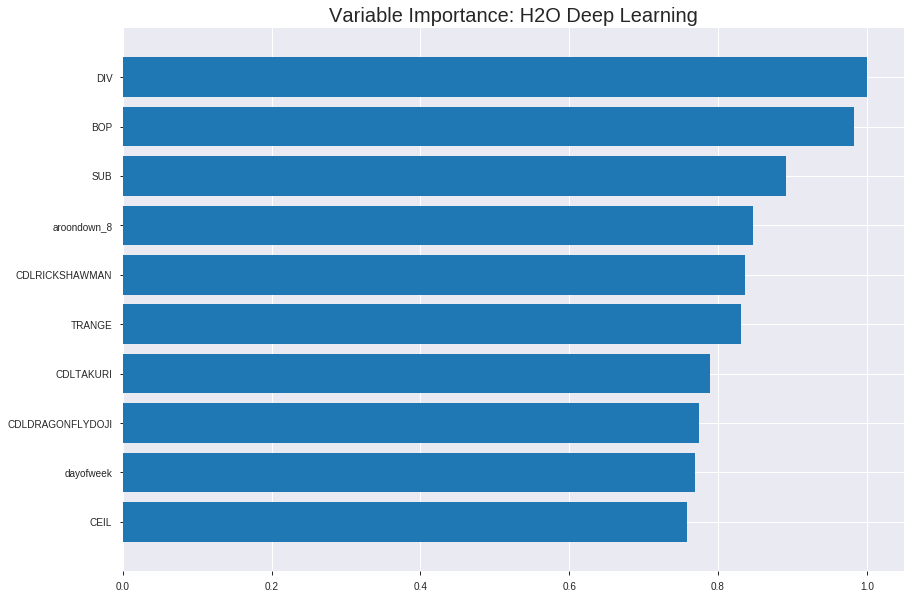

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_123136_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22621982186343795
RMSE: 0.47562571615024973
LogLoss: 0.641439221928672
Mean Per-Class Error: 0.3735987363514912
AUC: 0.6727070002913021
pr_auc: 0.644278113567748
Gini: 0.3454140005826043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3686522587655923: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      186  718   0.7942   (718.0/904.0)
1      37   844   0.042    (37.0/881.0)
Total  223  1562  0.423    (755.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368652     0.690954  289
max f2                       0.253739     0.839746  337
max f0point5                 0.512685     0.621215  176
max accuracy                 0.526246     0.62577   159
max precision                0.778765     1         0
max recall                   0.0982719    1         385
max specificity              0.778765     1         0
max absolute_mcc             0.512685     0.253922  176
max min_per_class_accuracy   0.521946     0.61615   165
max mean_per_class_accuracy  0.512685     0.626401  176

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.723244           1.57586   1.57586            0.777778         0.740723  0.777778                    0.740723            0.015891        0.015891                   57.5861   57.5861
    2        0.0201681                   0.687367           1.68842   1.63214            0.833333         0.698751  0.805556                    0.719737            0.0170261       0.0329171                  68.8422   63.2142
    3        0.0302521                   0.67573            1.4633    1.57586            0.722222         0.681581  0.777778                    0.707018            0.014756        0.0476731                  46.3299   57.5861
    4        0.0403361                   0.667043           1.57586   1.57586            0.777778         0.670716  0.777778                    0.697943            0.015891        0.0635641                  57.5861   57.5861
    5        0.0504202                   0.660718           1.4633    1.55335            0.722222         0.664275  0.766667                    0.691209            0.014756        0.0783201                  46.3299   55.3348
    6        0.10028                     0.631284           1.43421   1.49411            0.707865         0.646077  0.73743                     0.668769            0.0715096       0.14983                    43.421    49.4112
    7        0.15014                     0.60308            1.36591   1.45154            0.674157         0.614832  0.716418                    0.650857            0.0681044       0.217934                   36.5915   45.1539
    8        0.2                         0.584329           1.0472    1.35074            0.516854         0.593905  0.666667                    0.636659            0.0522134       0.270148                   4.72012   35.0738
    9        0.30028                     0.556417           1.27905   1.3268             0.631285         0.569658  0.654851                    0.614284            0.128263        0.398411                   27.9051   32.6797
    10       0.4                         0.535982           1.20656   1.29682            0.595506         0.545785  0.640056                    0.597207            0.120318        0.518729                   20.6558   29.6822
    11       0.50028                     0.521223           1.00739   1.23881            0.497207         0.527933  0.611422                    0.583321            0.101022        0.61975                    0.739383  23.8807
    12       0.6                         0.500315           1.02444   1.20318            0.505618         0.511475  0.593838                    0.57138             0.102157        0.721907                   2.4436    20.3178
    13       0.69972                     0.478155           0.865079  1.15499            0.426966         0.489327  0.570056                    0.559687            0.0862656       0.808173                   -13.4921  15.4994
    14       0.8                         0.438634           0.928161  1.12656            0.458101         0.460729  0.556022                    0.547282            0.093076        0.901249                   -7.18394  12.6561
    15       0.89972                     0.33226            0.717105  1.08118            0.353933         0.396565  0.533624                    0.530578            0.0715096       0.972758                   -28.2895  8.1179
    16       1                           0.00205629         0.271657  1                  0.134078         0.211385  0.493557                    0.498569          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24560800779502198
RMSE: 0.4955885468763599
LogLoss: 0.6857989696948533
Mean Per-Class Error: 0.4234794385619306
AUC: 0.5868782319625707
pr_auc: 0.5258517161036211
Gini: 0.17375646392514144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45311426510522157: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   205  0.7824   (205.0/262.0)
1      16   232  0.0645   (16.0/248.0)
Total  73   437  0.4333   (221.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453114     0.677372  330
max f2                       0.192768     0.828323  394
max f0point5                 0.453114     0.581162  330
max accuracy                 0.521756     0.570588  230
max precision                0.557069     0.572222  154
max recall                   0.192768     1         394
max specificity              0.89141      0.996183  0
max absolute_mcc             0.453114     0.218415  330
max min_per_class_accuracy   0.536765     0.557252  195
max mean_per_class_accuracy  0.453114     0.576521  330

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 52.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.762866           0.342742  0.342742           0.166667         0.816833  0.166667                    0.816833            0.00403226      0.00403226                 -65.7258  -65.7258
    2        0.0215686                   0.719675           0.822581  0.56085            0.4              0.743972  0.272727                    0.783714            0.00806452      0.0120968                  -17.7419  -43.915
    3        0.0313725                   0.708518           1.23387   0.771169           0.6              0.710234  0.375                       0.760752            0.0120968       0.0241935                  23.3871   -22.8831
    4        0.0411765                   0.699171           0.822581  0.78341            0.4              0.704516  0.380952                    0.747363            0.00806452      0.0322581                  -17.7419  -21.659
    5        0.0509804                   0.689882           1.64516   0.949132           0.8              0.694794  0.461538                    0.737253            0.016129        0.0483871                  64.5161   -5.08685
    6        0.1                         0.638611           1.23387   1.08871            0.6              0.661676  0.529412                    0.700205            0.0604839       0.108871                   23.3871   8.87097
    7        0.15098                     0.609287           1.10732   1.09499            0.538462         0.623589  0.532468                    0.674335            0.0564516       0.165323                   10.732    9.49937
    8        0.2                         0.593527           1.06935   1.08871            0.52             0.601709  0.529412                    0.656534            0.0524194       0.217742                   6.93548   8.87097
    9        0.3                         0.569102           1.25      1.14247            0.607843         0.581925  0.555556                    0.631665            0.125           0.342742                   25        14.2473
    10       0.4                         0.547608           1.20968   1.15927            0.588235         0.557596  0.563725                    0.613148            0.120968        0.46371                    20.9677   15.9274
    11       0.5                         0.536456           0.967742  1.12097            0.470588         0.542041  0.545098                    0.598926            0.0967742       0.560484                   -3.22581  12.0968
    12       0.6                         0.523045           1.04839   1.10887            0.509804         0.529677  0.539216                    0.587385            0.104839        0.665323                   4.83871   10.8871
    13       0.7                         0.5034             1.04839   1.10023            0.509804         0.514177  0.535014                    0.576926            0.104839        0.770161                   4.83871   10.023
    14       0.8                         0.475419           1.00806   1.08871            0.490196         0.489909  0.529412                    0.566049            0.100806        0.870968                   0.806452  8.87097
    15       0.9                         0.410647           0.846774  1.06183            0.411765         0.452056  0.51634                     0.553383            0.0846774       0.955645                   -15.3226  6.1828
    16       1                           0.0588636          0.443548  1                  0.215686         0.293383  0.486275                    0.527383        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:35:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:35:33  2 min  6.791 sec  760 obs/sec       1         1             1785       0.579326         1.05136             -0.342696      0.585394        0.577195           1.57586          0.503641                         0.566108           0.930718              -0.282881        0.559076          0.539758             1.02823            0.505882
    2019-08-22 12:35:41  2 min 14.280 sec  1738 obs/sec      9         9             16065      0.475626         0.641439            0.0949705      0.672707        0.644278           1.57586          0.422969                         0.495589           0.685799              0.0168271        0.586878          0.525852             0.342742           0.433333
    2019-08-22 12:35:47  2 min 20.308 sec  2185 obs/sec      18        18            32130      0.46915          0.627137            0.119447       0.690081        0.662776           1.68842          0.387115                         0.502103           0.715726              -0.00919121      0.595628          0.530966             0.342742           0.439216
    2019-08-22 12:35:53  2 min 26.115 sec  2415 obs/sec      27        27            48195      0.465465         0.619659            0.133226       0.701938        0.681878           1.80098          0.37423                          0.502176           0.719962              -0.00948434      0.598313          0.534176             0                  0.433333
    2019-08-22 12:35:58  2 min 31.837 sec  2559 obs/sec      36        36            64260      0.459691         0.606645            0.154596       0.720572        0.705271           1.91355          0.362465                         0.502124           0.713684              -0.00927472      0.595589          0.528263             0.342742           0.447059
    2019-08-22 12:36:04  2 min 37.544 sec  2654 obs/sec      45        45            80325      0.455046         0.595024            0.171594       0.728868        0.712708           1.91355          0.361345                         0.508289           0.740324              -0.0342095       0.585478          0.519596             0                  0.452941
    2019-08-22 12:36:10  2 min 43.649 sec  2743 obs/sec      55        55            98175      0.450106         0.584707            0.189482       0.741749        0.728794           1.91355          0.329972                         0.509841           0.746306              -0.040535        0.593658          0.528374             0                  0.44902
    2019-08-22 12:36:11  2 min 44.280 sec  2741 obs/sec      55        55            98175      0.475626         0.641439            0.0949705      0.672707        0.644278           1.57586          0.422969                         0.495589           0.685799              0.0168271        0.586878          0.525852             0.342742           0.433333

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
DIV               1.0                    1.0                  0.02798057223657936
BOP               0.9825667142868042     0.9825667142868042   0.027492778926360355
SUB               0.8907235860824585     0.8907235860824585   0.024922955643205243
aroondown_8       0.847303032875061      0.847303032875061    0.02370802371763342
CDLRICKSHAWMAN    0.8357931971549988     0.8357931971549988   0.023385971927837056
---               ---                    ---                  ---
is_quarter_start  0.6452099084854126     0.6452099084854126   0.018053342452132845
CDLCOUNTERATTACK  0.6440921425819397     0.6440921425819397   0.018022066722527135
CDLMATCHINGLOW    0.6271387338638306     0.6271387338638306   0.017547700645233828
CDLHAMMER         0.6190268397331238     0.6190268397331238   0.017320725205534102
CDLHANGINGMAN     0.5980169773101807     0.5980169773101807   0.016732857232328348


See the whole table with table.as_data_frame()


('accuracy', 0.58203125)

('F1', 0.6781609195402298)

('auc', 0.58734130859375)

('logloss', 0.6777058357836492)

('mean_per_class_error', 0.41796875)

('rmse', 0.49265056260495615)

('mse', 0.2427045768349798)

deeplearning prediction progress: |███████████████████████████████████████| 100%


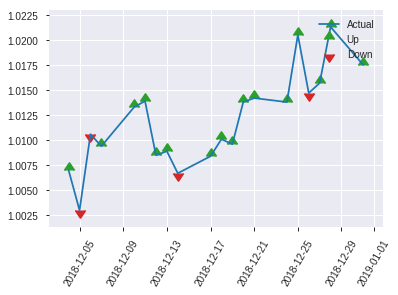


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2427045768349798
RMSE: 0.49265056260495615
LogLoss: 0.6777058357836492
Mean Per-Class Error: 0.41796875
AUC: 0.58734130859375
pr_auc: 0.5823717933145175
Gini: 0.1746826171875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4610523916939226: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   102  0.7969   (102.0/128.0)
1      10   118  0.0781   (10.0/128.0)
Total  36   220  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461052     0.678161  219
max f2                       0.254406     0.837696  251
max f0point5                 0.461052     0.585317  219
max accuracy                 0.539716     0.582031  116
max precision                0.75495      1         0
max recall                   0.254406     1         251
max specificity              0.75495      1         0
max absolute_mcc             0.58895      0.18582   50
max min_per_class_accuracy   0.535442     0.546875  125
max mean_per_class_accuracy  0.539716     0.582031  116

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.732987           1.33333   1.33333            0.666667         0.747521  0.666667                    0.747521            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.696977           2         1.66667            1                0.716138  0.833333                    0.73183             0.0234375       0.0390625                  100       66.6667
    3        0.03125                     0.663312           1         1.5                0.5              0.666864  0.75                        0.715588            0.0078125       0.046875                   0         50
    4        0.0429688                   0.659167           2         1.63636            1                0.660642  0.818182                    0.700603            0.0234375       0.0703125                  100       63.6364
    5        0.0507812                   0.65091            0         1.38462            0                0.655872  0.692308                    0.693721            0               0.0703125                  -100      38.4615
    6        0.101562                    0.62457            1.23077   1.30769            0.615385         0.636464  0.653846                    0.665092            0.0625          0.132812                   23.0769   30.7692
    7        0.152344                    0.603214           1.23077   1.28205            0.615385         0.612615  0.641026                    0.6476              0.0625          0.195312                   23.0769   28.2051
    8        0.203125                    0.588505           1.53846   1.34615            0.769231         0.595473  0.673077                    0.634568            0.078125        0.273438                   53.8462   34.6154
    9        0.300781                    0.564643           0.96      1.22078            0.48             0.575678  0.61039                     0.615448            0.09375         0.367188                   -4        22.0779
    10       0.402344                    0.548569           0.923077  1.14563            0.461538         0.553718  0.572816                    0.599866            0.09375         0.460938                   -7.69231  14.5631
    11       0.5                         0.533057           0.88      1.09375            0.44             0.540237  0.546875                    0.58822             0.0859375       0.546875                   -12       9.375
    12       0.601562                    0.515415           0.846154  1.05195            0.423077         0.522728  0.525974                    0.577163            0.0859375       0.632812                   -15.3846  5.19481
    13       0.699219                    0.501538           1.04      1.05028            0.52             0.508594  0.52514                     0.567586            0.101562        0.734375                   4         5.02793
    14       0.800781                    0.486229           1.07692   1.05366            0.538462         0.494262  0.526829                    0.558286            0.109375        0.84375                    7.69231   5.36585
    15       0.898438                    0.433691           1.04      1.05217            0.52             0.464545  0.526087                    0.548097            0.101562        0.945312                   4         5.21739
    16       1                           0.0836355          0.538462  1                  0.269231         0.336426  0.5                         0.526599            0.05

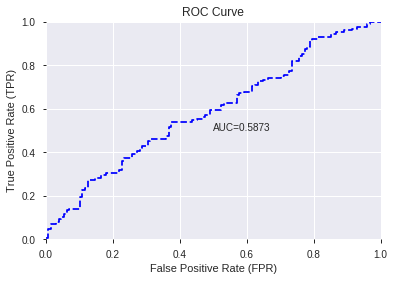

This function is available for GLM models only


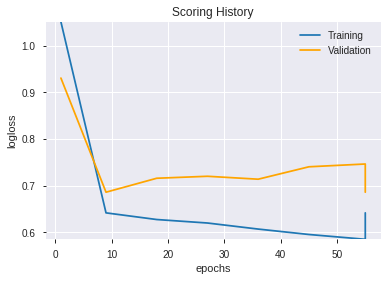

--2019-08-22 12:39:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_123136_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_123136_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'BOP',
 'SUB',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'dayofweek',
 'CEIL',
 'days_in_month',
 'VAR_12',
 'SAREXT',
 'CDLSEPARATINGLINES',
 'CDLLONGLEGGEDDOJI',
 'HT_TRENDMODE',
 'weekday',
 'FLOOR',
 'CDLHARAMICROSS',
 'CORREL_8',
 'CDLMORNINGSTAR',
 'CORREL_20',
 'CDLXSIDEGAP3METHODS',
 'VAR_14',
 'VAR_8',
 'CDLDOJI',
 'CORREL_24',
 'CDL3OUTSIDE',
 'CDLADVANCEBLOCK',
 'CDLTASUKIGAP',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'weekday_name',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CORREL_30',
 'HT_DCPERIOD',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'CDL3INSIDE',
 'CDLSHOOTINGSTAR',
 'CDLENGULFING',
 'is_quarter_end',
 'is_quarter_start',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLHANGINGMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124008_model_1  0.565369  0.688771              0.472656  0.497764  0.247769

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.129363           1.000000    0.085238
1           aroondown_8             0.097542           0.754022    0.064271
2        CDLRICKSHAWMAN             0.090824           0.702084    0.059844
3             CDLTAKURI             0.068514           0.529627    0.045144
4      CDLDRAGONFLYDOJI             0.067810           0.524186    0.044680
5                   DIV             0.062839           0.485758    0.041405
6                   SUB             0.061248           0.473459    0.040357
7             dayofweek             0.056285           0.435090    0.037086
8               weekday             0.056280           0.435058    0.037083
9                TRANGE             0.052184           0.403395    0.034384
10   CDLSEPARATINGLINES             0.050027           0.386715    0.032963
11               VAR_14             0.046110           0.356439    0.030382
12       is_quarter_end             0.040936           0.316441    0.026973
13          CDL3OUTSIDE             0.040765           0.315118    0.026860
14            CDLHAMMER             0.035402           0.273661    0.023326
15         weekday_name             0.034048           0.263194    0.022434
16               VAR_12             0.032686           0.252670    0.021537
17         CDLENGULFING             0.030137           0.232966    0.019857
18                FLOOR             0.025928           0.200429    0.017084
19         CDLTASUKIGAP             0.025470           0.196890    0.016782
20       CDLHARAMICROSS             0.025372           0.196129    0.016718
21       is_month_start             0.025339           0.195879    0.016696
22          CDLPIERCING             0.024978           0.193085    0.016458
23        CDLHANGINGMAN             0.023754           0.183626    0.015652
24                 CEIL             0.023329           0.180339    0.015372
25               SAREXT             0.023238           0.179631    0.015311
26      CDLADVANCEBLOCK             0.019790           0.152980    0.013040
27              CDLDOJI             0.019706           0.152329    0.012984
28     is_quarter_start             0.019156           0.148081    0.012622
29   CDLEVENINGDOJISTAR             0.018942           0.146428    0.012481
30        days_in_month             0.017428           0.134718    0.011483
31       CDL3LINESTRIKE             0.016983           0.131284    0.011190
32     CDLCOUNTERATTACK             0.016281           0.125852    0.010727
33       CDLMATCHINGLOW             0.016033           0.123937    0.010564
34            CORREL_24             0.015188           0.117407    0.010007
35            CORREL_20             0.014482           0.111951    0.009542
36         HT_TRENDMODE             0.012836           0.099223    0.008458
37       CDLEVENINGSTAR             0.011854           0.091637    0.007811
38            CDLONNECK             0.010543           0.081501    0.006947
39          HT_DCPERIOD             0.009934           0.076792    0.006546
40           CDL3INSIDE             0.008084           0.062489    0.005326
41   CDLMORNINGDOJISTAR             0.007055           0.054534    0.004648
42  CDLXSIDEGAP3METHODS             0.006371           0.049253    0.004198
43    CDLLONGLEGGEDDOJI             0.005949           0.045989    0.003920
44            CORREL_30             0.005869           0.045366    0.003867
45         is_month_end             0.005652           0.043694    0.003724
46       CDLMORNINGSTAR             0.003966           0.030660    0.002613
47      CDLSHOOTINGSTAR             0.001865           0.014416    0.001229
48                VAR_8             0.001825           0.014111    0.001203
49             CORREL_8             0.001473           0.011383    0.000970

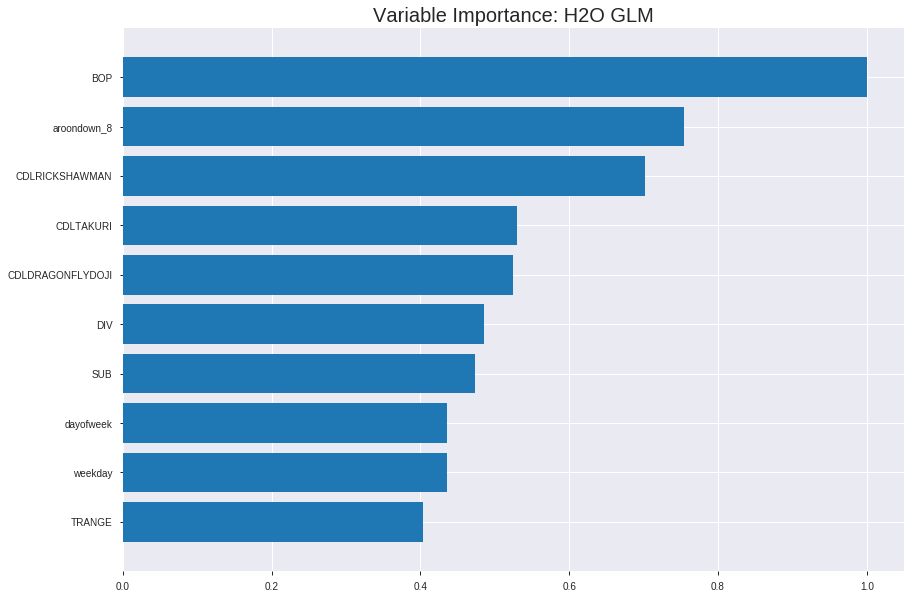

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124008_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2327585794351048
RMSE: 0.48245059792180256
LogLoss: 0.6573139126409835
Null degrees of freedom: 1784
Residual degrees of freedom: 1734
Null deviance: 2474.2390678544516
Residual deviance: 2346.610668128311
AIC: 2448.610668128311
AUC: 0.6549419655861701
pr_auc: 0.6179798248800805
Gini: 0.30988393117234025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40314030084544855: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      204  700   0.7743   (700.0/904.0)
1      55   826   0.0624   (55.0/881.0)
Total  259  1526  0.423    (755.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40314      0.686332  294
max f2                       0.329943     0.837156  353
max f0point5                 0.506552     0.607297  174
max accuracy                 0.507561     0.612325  173
max precision                0.82508      1         0
max recall                   0.288166     1         373
max specificity              0.82508      1         0
max absolute_mcc             0.422345     0.238021  273
max min_per_class_accuracy   0.505694     0.609513  175
max mean_per_class_accuracy  0.506552     0.612275  174

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.659047           1.35074   1.35074            0.666667         0.710683  0.666667                    0.710683            0.0136209       0.0136209                  35.0738   35.0738
    2        0.0201681                   0.639374           1.35074   1.35074            0.666667         0.647614  0.666667                    0.679149            0.0136209       0.0272418                  35.0738   35.0738
    3        0.0302521                   0.62989            1.68842   1.4633             0.833333         0.634587  0.722222                    0.664295            0.0170261       0.0442679                  68.8422   46.3299
    4        0.0403361                   0.623941           1.4633    1.4633             0.722222         0.627047  0.722222                    0.654983            0.014756        0.0590238                  46.3299   46.3299
    5        0.0504202                   0.616926           1.01305   1.37325            0.5              0.619982  0.677778                    0.647982            0.0102157       0.0692395                  1.30533   37.325
    6        0.10028                     0.595716           1.36591   1.3696             0.674157         0.60496   0.675978                    0.626591            0.0681044       0.137344                   36.5915   36.9603
    7        0.15014                     0.577847           1.22932   1.32302            0.606742         0.586327  0.652985                    0.61322             0.061294        0.198638                   22.9323   32.3017
    8        0.2                         0.565242           1.34315   1.32804            0.662921         0.57165   0.655462                    0.602856            0.0669694       0.265607                   34.3149   32.8036
    9        0.30028                     0.543684           1.25641   1.30412            0.620112         0.553997  0.643657                    0.586539            0.125993        0.3916                     25.6413   30.4117
    10       0.4                         0.523747           1.13826   1.26277            0.561798         0.533162  0.623249                    0.573232            0.113507        0.505108                   13.8262   26.277
    11       0.50028                     0.505227           1.06399   1.22292            0.52514          0.514349  0.603583                    0.561429            0.106697        0.611805                   6.3989    22.2924
    12       0.6                         0.481612           0.91061   1.17102            0.449438         0.493104  0.577965                    0.550074            0.0908059       0.702611                   -8.93902  17.1018
    13       0.69972                     0.458442           1.0472    1.15337            0.516854         0.470266  0.569255                    0.5387              0.104427        0.807037                   4.72012   15.3372
    14       0.8                         0.423833           0.871565  1.11805            0.430168         0.442378  0.551821                    0.526626            0.0874007       0.894438                   -12.8435  11.8048
    15       0.89972                     0.37836            0.717105  1.07361            0.353933         0.403622  0.529888                    0.512993            0.0715096       0.965948                   -28.2895  7.36095
    16       1                           0.001797           0.339571  1                  0.167598         0.31918   0.493557                    0.493557           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24421045683755252
RMSE: 0.4941765442000991
LogLoss: 0.6815699170772536
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.7340007881703
Residual deviance: 695.2013154187987
AIC: 797.2013154187987
AUC: 0.5893791553804482
pr_auc: 0.5352930093302997
Gini: 0.17875831076089632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41876115025794985: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   220  0.8397   (220.0/262.0)
1      13   235  0.0524   (13.0/248.0)
Total  55   455  0.4569   (233.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418761     0.668563  346
max f2                       0.335853     0.826087  392
max f0point5                 0.521123     0.576299  186
max accuracy                 0.529329     0.590196  167
max precision                0.664901     1         0
max recall                   0.202735     1         399
max specificity              0.664901     1         0
max absolute_mcc             0.440404     0.180492  321
max min_per_class_accuracy   0.521123     0.572581  186
max mean_per_class_accuracy  0.529329     0.588217  167

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 50.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.638709           1.02823   1.02823            0.5              0.646224  0.5                         0.646224            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.629813           1.23387   1.1217             0.6              0.632238  0.545455                    0.639867            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.624672           0.822581  1.02823            0.4              0.627683  0.5                         0.636059            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.621716           0.822581  0.979263           0.4              0.623194  0.47619                     0.632996            0.00806452      0.0403226                  -17.7419  -2.07373
    5        0.0509804                   0.617996           0.41129   0.870037           0.2              0.619803  0.423077                    0.630459            0.00403226      0.0443548                  -58.871   -12.9963
    6        0.1                         0.601216           0.987097  0.927419           0.48             0.609665  0.45098                     0.620266            0.0483871       0.0927419                  -1.29032  -7.25806
    7        0.15098                     0.580597           1.4237    1.09499            0.692308         0.588508  0.532468                    0.609542            0.0725806       0.165323                   42.3697   9.49937
    8        0.2                         0.568807           1.06935   1.08871            0.52             0.574409  0.529412                    0.600931            0.0524194       0.217742                   6.93548   8.87097
    9        0.3                         0.550692           1.41129   1.19624            0.686275         0.56007   0.581699                    0.587311            0.141129        0.358871                   41.129    19.6237
    10       0.4                         0.533629           1.20968   1.1996             0.588235         0.542037  0.583333                    0.575992            0.120968        0.479839                   20.9677   19.9597
    11       0.5                         0.519048           0.927419  1.14516            0.45098          0.525837  0.556863                    0.565961            0.0927419       0.572581                   -7.25806  14.5161
    12       0.6                         0.499327           0.967742  1.11559            0.470588         0.50915   0.542484                    0.556493            0.0967742       0.669355                   -3.22581  11.5591
    13       0.7                         0.478497           0.766129  1.06567            0.372549         0.48907   0.518207                    0.546861            0.0766129       0.745968                   -23.3871  6.56682
    14       0.8                         0.450326           1.16935   1.07863            0.568627         0.465822  0.52451                     0.536731            0.116935        0.862903                   16.9355   7.8629
    15       0.9                         0.409961           0.846774  1.05287            0.411765         0.433148  0.511983                    0.525222            0.0846774       0.947581                   -15.3226  5.28674
    16       1                           0.202735           0.524194  1                  0.254902         0.363203  0.486275                    0.50902        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:40:09  0.000 sec   2            6.8       51            1.37622           1.38094
    2019-08-22 12:40:09  0.039 sec   4            4.3       51            1.37125           1.37861
    2019-08-22 12:40:09  0.077 sec   6            2.6       51            1.36447           1.37556
    2019-08-22 12:40:09  0.116 sec   8            1.6       51            1.3558            1.37193
    2019-08-22 12:40:09  0.165 sec   10           1         51            1.34561           1.36819
    2019-08-22 12:40:09  0.208 sec   12           0.63      51            1.33468           1.36503
    2019-08-22 12:40:09  0.248 sec   14           0.39      51            1.32404           1.36321
    2019-08-22 12:40:09  0.290 sec   16           0.24      51            1.31463           1.36314
    2019-08-22 12:40:09  0.330 sec   18           0.15      51            1.30701           1.36481
    2019-08-22 12:40:09  0.377 sec   20           0.094     51            1.30131           1.36781
    2019-08-22 12:40:09  0.418 sec   22           0.058     51            1.29731           1.37154
    2019-08-22 12:40:09  0.462 sec   24           0.036     51            1.29465           1.37536
    2019-08-22 12:40:09  0.496 sec   26           0.023     51            1.29295           1.37883

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.609375)

('F1', 0.675603217158177)

('auc', 0.56536865234375)

('logloss', 0.6887708601292303)

('mean_per_class_error', 0.390625)

('rmse', 0.49776414656751233)

('mse', 0.24776914560808388)

glm prediction progress: |████████████████████████████████████████████████| 100%


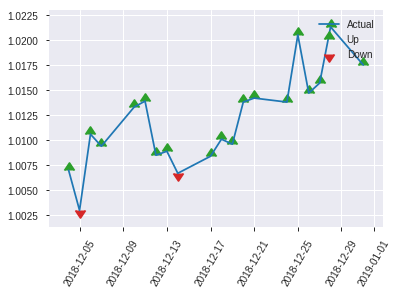


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24776914560808388
RMSE: 0.49776414656751233
LogLoss: 0.6887708601292303
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9338629373763
Residual deviance: 352.65068038616585
AIC: 454.65068038616585
AUC: 0.56536865234375
pr_auc: 0.550856147033081
Gini: 0.1307373046875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37515056488112636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      2    126  0.0156   (2.0/128.0)
Total  11   245  0.4727   (121.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375151     0.675603  244
max f2                       0.313322     0.83442   254
max f0point5                 0.549949     0.603448  83
max accuracy                 0.549949     0.609375  83
max precision                0.552427     0.666667  77
max recall                   0.313322     1         254
max specificity              0.716215     0.992188  0
max absolute_mcc             0.549949     0.232945  83
max min_per_class_accuracy   0.519483     0.523438  125
max mean_per_class_accuracy  0.549949     0.609375  83

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.637689           0         0                  0                0.665692  0                           0.665692            0               0                          -100      -100
    2        0.0234375                   0.629375           2         1                  1                0.633582  0.5                         0.649637            0.0234375       0.0234375                  100       0
    3        0.03125                     0.623062           1         1                  0.5              0.624441  0.5                         0.643338            0.0078125       0.03125                    0         0
    4        0.0429688                   0.620071           0.666667  0.909091           0.333333         0.621605  0.454545                    0.637411            0.0078125       0.0390625                  -33.3333  -9.09091
    5        0.0507812                   0.616314           1         0.923077           0.5              0.617351  0.461538                    0.634325            0.0078125       0.046875                   0         -7.69231
    6        0.101562                    0.595193           1.38462   1.15385            0.692308         0.602937  0.576923                    0.618631            0.0703125       0.117188                   38.4615   15.3846
    7        0.152344                    0.577071           1.53846   1.28205            0.769231         0.585754  0.641026                    0.607672            0.078125        0.195312                   53.8462   28.2051
    8        0.203125                    0.565802           1.23077   1.26923            0.615385         0.571896  0.634615                    0.598728            0.0625          0.257812                   23.0769   26.9231
    9        0.300781                    0.552664           1.44      1.32468            0.72             0.559056  0.662338                    0.585848            0.140625        0.398438                   44        32.4675
    10       0.402344                    0.537955           0.692308  1.16505            0.346154         0.545972  0.582524                    0.575782            0.0703125       0.46875                    -30.7692  16.5049
    11       0.5                         0.515542           0.56      1.04688            0.28             0.526019  0.523438                    0.566063            0.0546875       0.523438                   -44       4.6875
    12       0.601562                    0.492046           0.846154  1.01299            0.423077         0.503263  0.506494                    0.55546             0.0859375       0.609375                   -15.3846  1.2987
    13       0.699219                    0.476422           0.8       0.98324            0.4              0.485095  0.49162                     0.545632            0.078125        0.6875                     -20       -1.67598
    14       0.800781                    0.458199           1.30769   1.02439            0.653846         0.467184  0.512195                    0.535683            0.132812        0.820312                   30.7692   2.43902
    15       0.898438                    0.420429           1.04      1.02609            0.52             0.441109  0.513043                    0.525403            0.101562        0.921875                   4         2.6087
    16       1                           0.305552           0.769231  1                  0.384615         0.36959   0.5                         0.509578            0.078125    

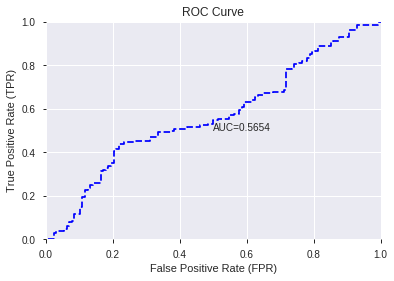

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


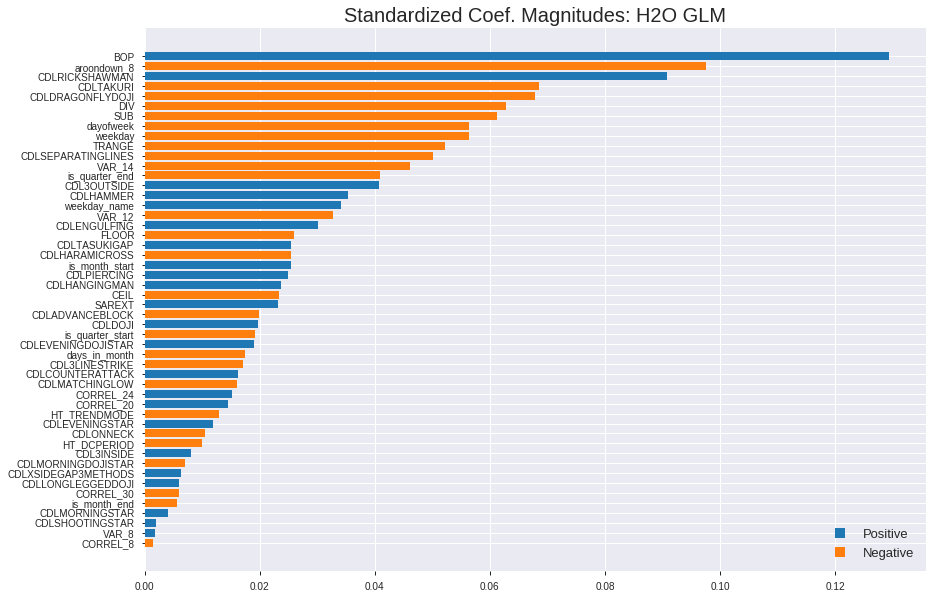

'log_likelihood'
--2019-08-22 12:40:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124008_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124008_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'DIV',
 'SUB',
 'dayofweek',
 'weekday',
 'TRANGE',
 'CDLSEPARATINGLINES',
 'VAR_14',
 'is_quarter_end',
 'CDL3OUTSIDE',
 'CDLHAMMER',
 'weekday_name',
 'VAR_12',
 'CDLENGULFING',
 'FLOOR',
 'CDLTASUKIGAP',
 'CDLHARAMICROSS',
 'is_month_start',
 'CDLPIERCING',
 'CDLHANGINGMAN',
 'CEIL',
 'SAREXT',
 'CDLADVANCEBLOCK',
 'CDLDOJI',
 'is_quarter_start',
 'CDLEVENINGDOJISTAR',
 'days_in_month',
 'CDL3LINESTRIKE',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'CORREL_20',
 'HT_TRENDMODE',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'HT_DCPERIOD',
 'CDL3INSIDE',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLLONGLEGGEDDOJI',
 'CORREL_30',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'VAR_8',
 'CORREL_8']

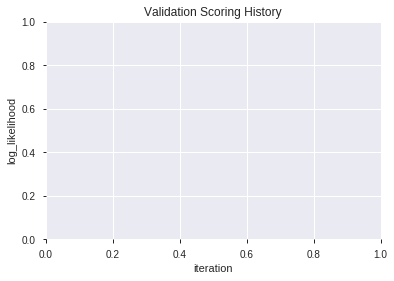

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190822_124024  0.650269  0.666453              0.414062  0.486766  0.236941
1  XGBoost_grid_1_AutoML_20190822_124024_model_7  0.644775  0.669621              0.437500  0.488309  0.238446
2               XGBoost_1_AutoML_20190822_124024  0.644043  0.667419              0.441406  0.487107  0.237273
3  XGBoost_grid_1_AutoML_20190822_124024_model_3  0.637817  0.669343              0.445312  0.488017  0.238160
4  XGBoost_grid_1_AutoML_20190822_124024_model_1  0.626465  0.668681              0.386719  0.487842  0.237990
5  XGBoost_grid_1_AutoML_20190822_124024_model_4  0.625732  0.671948              0.433594  0.489455  0.239566
6               XGBoost_3_AutoML_20190822_124024  0.622559  0.671425              0.394531  0.489202  0.239318
7  XGBoost_grid_1_AutoML_20190822_124024_model_2  0.611389  0.675775              0.414062  0.491232  0.241309
8  XGBoost_grid_1_AutoML_20190822_124024_model_5  0.611145  0.684292              0.421875  0.495439  0.245459
9  XGBoost_grid_1_AutoML_20190822_124024_model_6  0.600037  0.681537              0.421875  0.493966  0.244002

variable  relative_importance  scaled_importance  percentage
0                BOP           480.688293           1.000000    0.100717
1             SAREXT           389.637177           0.810582    0.081640
2        HT_DCPERIOD           384.117065           0.799098    0.080483
3                DIV           369.256012           0.768182    0.077369
4              VAR_8           366.348938           0.762134    0.076760
5        aroondown_8           283.779510           0.590361    0.059460
6          CORREL_20           282.719696           0.588156    0.059238
7           CORREL_8           272.997314           0.567930    0.057200
8          CORREL_30           267.920532           0.557369    0.056137
9                SUB           263.149750           0.547444    0.055137
10            VAR_12           249.057846           0.518128    0.052184
11            TRANGE           224.757324           0.467574    0.047093
12            VAR_14           192.116516           0.399670    0.040254
13         dayofweek           156.091599           0.324725    0.032705
14         CORREL_24           154.138306           0.320662    0.032296
15    CDLRICKSHAWMAN            87.775604           0.182604    0.018391
16     days_in_month            77.088669           0.160371    0.016152
17  CDLDRAGONFLYDOJI            63.369896           0.131832    0.013278
18           weekday            58.026237           0.120715    0.012158
19      HT_TRENDMODE            54.469746           0.113316    0.011413
20      weekday_name            47.755917           0.099349    0.010006
21         CDLTAKURI            29.470423           0.061309    0.006175
22              CEIL            12.184917           0.025349    0.002553
23             FLOOR             5.726425           0.011913    0.001200

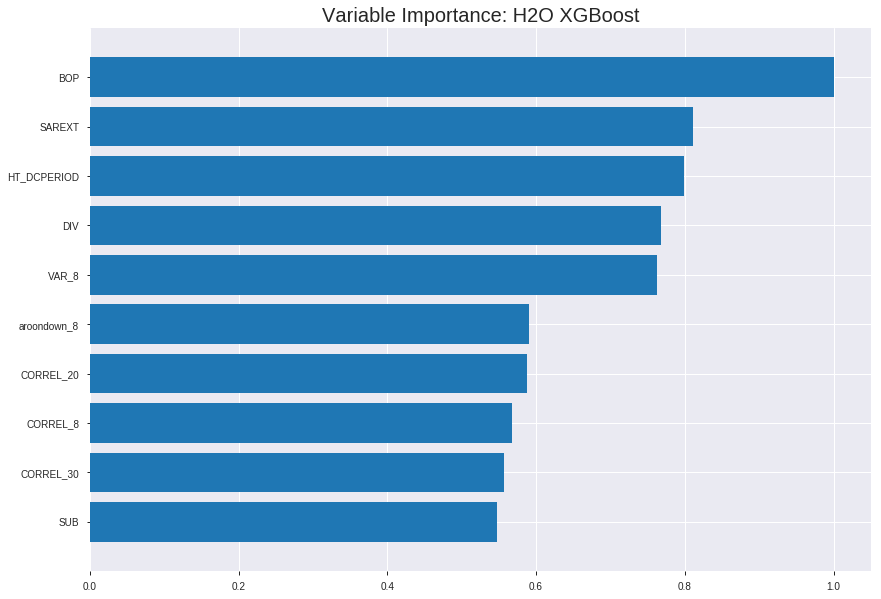

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190822_124024


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18582674454945375
RMSE: 0.43107626303179086
LogLoss: 0.5585044296851334
Mean Per-Class Error: 0.22574282040722027
AUC: 0.8527932357638645
pr_auc: 0.8454496995381858
Gini: 0.7055864715277289
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4814271827538808: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  260  0.2876   (260.0/904.0)
1      148  733  0.168    (148.0/881.0)
Total  792  993  0.2286   (408.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481427     0.782284  206
max f2                       0.36378      0.861685  295
max f0point5                 0.546128     0.783429  155
max accuracy                 0.505495     0.77423   188
max precision                0.814384     1         0
max recall                   0.242252     1         367
max specificity              0.814384     1         0
max absolute_mcc             0.491529     0.548689  199
max min_per_class_accuracy   0.506732     0.772985  187
max mean_per_class_accuracy  0.505495     0.774257  188

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.75121            2.02611    2.02611            1                0.771371  1                           0.771371            0.0204313       0.0204313                  102.611   102.611
    2        0.0201681                   0.734174           1.91355    1.96983            0.944444         0.742189  0.972222                    0.75678             0.0192963       0.0397276                  91.3545   96.9826
    3        0.0302521                   0.722057           2.02611    1.98859            1                0.727945  0.981481                    0.747168            0.0204313       0.0601589                  102.611   98.8586
    4        0.0403361                   0.713961           1.91355    1.96983            0.944444         0.71708   0.972222                    0.739646            0.0192963       0.0794552                  91.3545   96.9826
    5        0.0504202                   0.701942           1.91355    1.95857            0.944444         0.708905  0.966667                    0.733498            0.0192963       0.0987514                  91.3545   95.857
    6        0.10028                     0.668973           1.86675    1.91292            0.921348         0.685421  0.944134                    0.709594            0.093076        0.191827                   86.675    91.2916
    7        0.15014                     0.645272           1.79845    1.8749             0.88764          0.655778  0.925373                    0.691722            0.0896708       0.281498                   79.8454   87.4905
    8        0.2                         0.622441           1.84398    1.8672             0.910112         0.633788  0.921569                    0.677279            0.091941        0.373439                   84.3985   86.7196
    9        0.30028                     0.57922            1.6073     1.7804             0.793296         0.59941   0.878731                    0.651274            0.16118         0.53462                    60.7303   78.0403
    10       0.4                         0.542026           1.26347    1.65153            0.623596         0.56056   0.815126                    0.628659            0.125993        0.660613                   26.3471   65.1532
    11       0.50028                     0.504688           1.16586    1.55418            0.575419         0.523392  0.767077                    0.607559            0.116913        0.777526                   16.586    55.418
    12       0.6                         0.465361           0.819549   1.43208            0.404494         0.484971  0.706816                    0.587185            0.0817253       0.859251                   -18.0451  43.2085
    13       0.69972                     0.419293           0.569131   1.3091             0.280899         0.443477  0.646117                    0.566704            0.0567537       0.916005                   -43.0869  30.9102
    14       0.8                         0.360575           0.509356   1.20885            0.251397         0.389934  0.596639                    0.544546            0.0510783       0.967083                   -49.0644  20.8854
    15       0.89972                     0.289901           0.250418   1.10263            0.123596         0.330179  0.544209                    0.520787            0.0249716       0.992054                   -74.9582  10.2626
    16       1                           0.153464           0.0792332  1                  0.0391061        0.244673  0.493557                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2383374689610233
RMSE: 0.4881981861508944
LogLoss: 0.6695263215699087
Mean Per-Class Error: 0.37769330214232943
AUC: 0.6319333292292538
pr_auc: 0.5765910123710322
Gini: 0.26386665845850765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39201316237449646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      48   214  0.8168   (214.0/262.0)
1      14   234  0.0565   (14.0/248.0)
Total  62   448  0.4471   (228.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392013     0.672414  341
max f2                       0.271479     0.828877  393
max f0point5                 0.532335     0.611702  204
max accuracy                 0.546999     0.621569  188
max precision                0.823853     1         0
max recall                   0.271479     1         393
max specificity              0.823853     1         0
max absolute_mcc             0.532335     0.244792  204
max min_per_class_accuracy   0.543096     0.618321  194
max mean_per_class_accuracy  0.532335     0.622307  204

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 53.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.735959           1.02823   1.02823            0.5              0.769608  0.5                         0.769608            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.726581           1.23387   1.1217             0.6              0.729332  0.545455                    0.751301            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.716804           0.822581  1.02823            0.4              0.719916  0.5                         0.741493            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.710739           2.05645   1.27304            1                0.713363  0.619048                    0.734795            0.0201613       0.0524194                  105.645   27.3041
    5        0.0509804                   0.701581           0.822581  1.18641            0.4              0.705199  0.576923                    0.729104            0.00806452      0.0604839                  -17.7419  18.6414
    6        0.1                         0.660521           1.39839   1.29032            0.68             0.681788  0.627451                    0.70591             0.0685484       0.129032                   39.8387   29.0323
    7        0.15098                     0.643709           1.18641   1.25524            0.576923         0.650876  0.61039                     0.687327            0.0604839       0.189516                   18.6414   25.5237
    8        0.2                         0.630754           1.15161   1.22984            0.56             0.636454  0.598039                    0.674858            0.0564516       0.245968                   15.1613   22.9839
    9        0.3                         0.600302           1.04839   1.16935            0.509804         0.615131  0.568627                    0.654949            0.104839        0.350806                   4.83871   16.9355
    10       0.4                         0.574997           1.49194   1.25               0.72549          0.58722   0.607843                    0.638017            0.149194        0.5                        49.1935   25
    11       0.5                         0.541266           1.20968   1.24194            0.588235         0.558265  0.603922                    0.622066            0.120968        0.620968                   20.9677   24.1935
    12       0.6                         0.507188           0.846774  1.17608            0.411765         0.523945  0.571895                    0.605713            0.0846774       0.705645                   -15.3226  17.6075
    13       0.7                         0.473315           0.887097  1.13479            0.431373         0.490086  0.551821                    0.589195            0.0887097       0.794355                   -11.2903  13.4793
    14       0.8                         0.442339           0.766129  1.08871            0.372549         0.457289  0.529412                    0.572707            0.0766129       0.870968                   -23.3871  8.87097
    15       0.9                         0.379921           0.846774  1.06183            0.411765         0.41345   0.51634                     0.555011            0.0846774       0.955645                   -15.3226  6.1828
    16       1                           0.210483           0.443548  1                  0.215686         0.321258  0.486275                    0.531636            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:40:27  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.506443                         0.5                0.693147              0.5               0                    1                  0.513725
    2019-08-22 12:40:28  0.091 sec   5                  0.487667         0.668714            0.744824        0.733518           2.02611          0.354622                         0.495078           0.683328              0.61996           0.572037             1.02823            0.421569
    2019-08-22 12:40:28  0.176 sec   10                 0.478832         0.651396            0.767456        0.762081           2.02611          0.328852                         0.492396           0.677946              0.623984          0.584583             1.37097            0.458824
    2019-08-22 12:40:28  0.269 sec   15                 0.469896         0.63395             0.78595         0.7754             1.91355          0.315966                         0.490802           0.674714              0.623461          0.573384             1.37097            0.445098
    2019-08-22 12:40:28  0.365 sec   20                 0.462622         0.619758            0.799557        0.786716           1.91355          0.309244                         0.48968            0.672408              0.628571          0.576307             1.37097            0.441176
    2019-08-22 12:40:28  0.466 sec   25                 0.456066         0.606975            0.810938        0.802794           2.02611          0.278431                         0.488983           0.670936              0.633011          0.586779             1.37097            0.45098
    2019-08-22 12:40:28  0.580 sec   30                 0.450194         0.595609            0.822956        0.813201           2.02611          0.268347                         0.488676           0.670337              0.634588          0.588947             1.37097            0.447059
    2019-08-22 12:40:28  0.674 sec   35                 0.44536          0.586075            0.8257          0.81706            2.02611          0.258263                         0.487483           0.667958              0.639844          0.590273             1.37097            0.437255
    2019-08-22 12:40:28  0.785 sec   40                 0.440499         0.576544            0.832572        0.821512           1.91355          0.248739                         0.48796            0.66906               0.635104          0.580534             0.685484           0.439216
    2019-08-22 12:40:28  0.895 sec   45                 0.435746         0.567357            0.842623        0.834649           2.02611          0.239776                         0.488396           0.66996               0.631803          0.575304             1.02823            0.443137
    2019-08-22 12:40:28  1.013 sec   50                 0.431076         0.558504            0.852793        0.84545            2.02611          0.228571                         0.488198           0.669526              0.631933          0.576591             1.02823            0.447059

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           480.68829345703125     1.0                   0.10071740578413364
SAREXT        389.6371765136719      0.8105817882758602    0.08163969489100852
HT_DCPERIOD   384.1170654296875      0.7990980239339316    0.08048307993785313
DIV           369.2560119628906      0.7681818279934842    0.0773692808860173
VAR_8         366.34893798828125     0.7621340959929768    0.0767601690080485
---           ---                    ---                   ---
HT_TRENDMODE  54.46974563598633      0.11331614765204466   0.011412908424965784
weekday_name  47.755916595458984     0.09934903188926503   0.01000617675905194
CDLTAKURI     29.470422744750977     0.061308800621717945  0.006174863350356111
CEIL          12.184917449951172     0.02534889577259984   0.002553075021708648
FLOOR         5.726424694061279      0.011912968907309503  0.0011998433235312583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.64453125)

('F1', 0.6954022988505748)

('auc', 0.6502685546875)

('logloss', 0.6664528015894207)

('mean_per_class_error', 0.35546875)

('rmse', 0.4867655618859564)

('mse', 0.23694071223815083)

xgboost prediction progress: |████████████████████████████████████████████| 100%


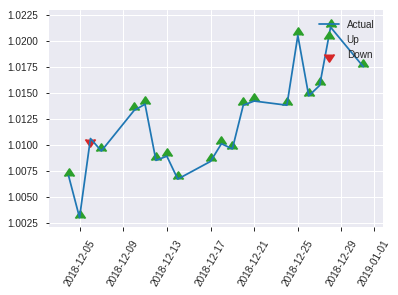


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23694071223815083
RMSE: 0.4867655618859564
LogLoss: 0.6664528015894207
Mean Per-Class Error: 0.35546875
AUC: 0.6502685546875
pr_auc: 0.6140243566547097
Gini: 0.300537109375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4278513789176941: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      29   99   0.7734   (99.0/128.0)
1      7    121  0.0547   (7.0/128.0)
Total  36   220  0.4141   (106.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427851     0.695402  219
max f2                       0.323855     0.837696  251
max f0point5                 0.578767     0.645425  120
max accuracy                 0.578767     0.644531  120
max precision                0.776521     1         0
max recall                   0.323855     1         251
max specificity              0.776521     1         0
max absolute_mcc             0.578767     0.289496  120
max min_per_class_accuracy   0.569595     0.640625  126
max mean_per_class_accuracy  0.578767     0.644531  120

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 55.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.738451           1.33333   1.33333            0.666667         0.759207  0.666667                    0.759207            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.713291           0.666667  1                  0.333333         0.724696  0.5                         0.741951            0.0078125       0.0234375                  -33.3333  0
    3        0.03125                     0.704611           2         1.25               1                0.705687  0.625                       0.732885            0.015625        0.0390625                  100       25
    4        0.0429688                   0.700494           1.33333   1.27273            0.666667         0.702428  0.636364                    0.724579            0.015625        0.0546875                  33.3333   27.2727
    5        0.0507812                   0.696449           1         1.23077            0.5              0.699326  0.615385                    0.720694            0.0078125       0.0625                     0         23.0769
    6        0.101562                    0.680474           1.53846   1.38462            0.769231         0.687148  0.692308                    0.703921            0.078125        0.140625                   53.8462   38.4615
    7        0.152344                    0.663974           1.53846   1.4359             0.769231         0.671725  0.717949                    0.693189            0.078125        0.21875                    53.8462   43.5897
    8        0.203125                    0.650877           1.07692   1.34615            0.538462         0.656425  0.673077                    0.683998            0.0546875       0.273438                   7.69231   34.6154
    9        0.300781                    0.626037           1.12      1.27273            0.56             0.638998  0.636364                    0.669387            0.109375        0.382812                   12        27.2727
    10       0.402344                    0.598493           1.53846   1.33981            0.769231         0.612202  0.669903                    0.654952            0.15625         0.539062                   53.8462   33.9806
    11       0.5                         0.56949            1.04      1.28125            0.52             0.584044  0.640625                    0.641103            0.101562        0.640625                   4         28.125
    12       0.601562                    0.537684           0.615385  1.16883            0.307692         0.554098  0.584416                    0.626414            0.0625          0.703125                   -38.4615  16.8831
    13       0.699219                    0.506008           0.72      1.10615            0.36             0.527022  0.553073                    0.612532            0.0703125       0.773438                   -28       10.6145
    14       0.800781                    0.460051           0.923077  1.08293            0.461538         0.484011  0.541463                    0.596232            0.09375         0.867188                   -7.69231  8.29268
    15       0.898438                    0.403133           0.88      1.06087            0.44             0.431158  0.530435                    0.578289            0.0859375       0.953125                   -12       6.08696
    16       1                           0.243701           0.461538  1                  0.230769         0.347478  0.5                         0.554847            0.046875 

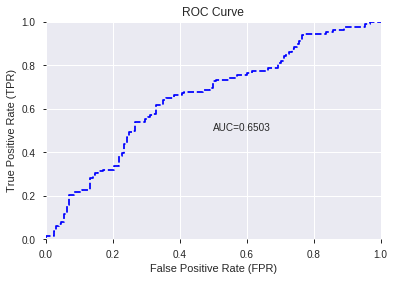

This function is available for GLM models only


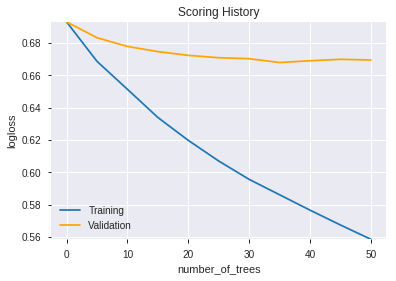

--2019-08-22 12:40:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


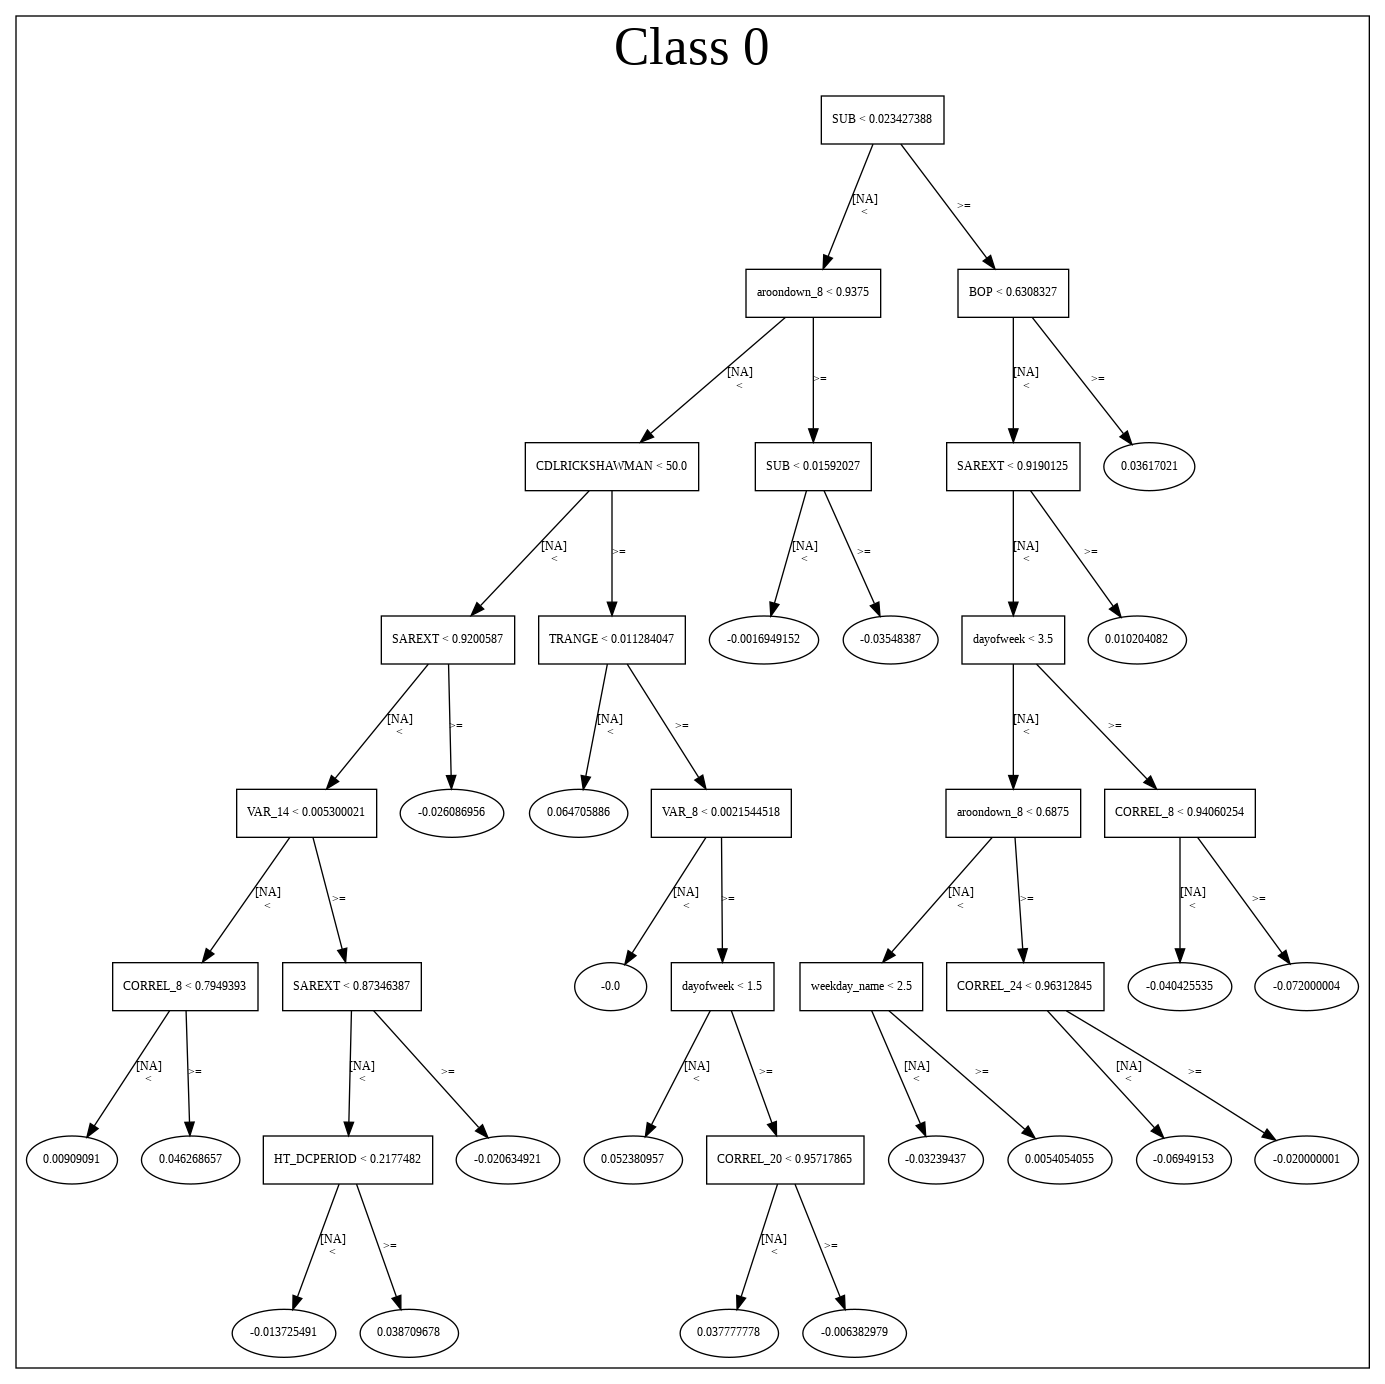

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190822_124024',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190822_124024',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_a5f6',
   'type

['BOP',
 'SAREXT',
 'HT_DCPERIOD',
 'DIV',
 'VAR_8',
 'aroondown_8',
 'CORREL_20',
 'CORREL_8',
 'CORREL_30',
 'SUB',
 'VAR_12',
 'TRANGE',
 'VAR_14',
 'dayofweek',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'weekday',
 'HT_TRENDMODE',
 'weekday_name',
 'CDLTAKURI',
 'CEIL',
 'FLOOR']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124101_model_1  0.591309  0.687031              0.449219  0.495455  0.245475

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.192248           1.000000  1.730502e-02
1                          DIV             0.147848           0.769049  1.330841e-02
2                          SUB             0.133639           0.695142  1.202944e-02
3               CDLRICKSHAWMAN             0.131458           0.683793  1.183306e-02
4                  aroondown_8             0.119659           0.622421  1.077101e-02
...                        ...                  ...                ...           ...
1017  BBANDS_middleband_20_3_2             0.000046           0.000237  4.106265e-06
1018   BBANDS_lowerband_20_6_2             0.000045           0.000235  4.071902e-06
1019   BBANDS_lowerband_12_4_5             0.000023           0.000121  2.089662e-06
1020    BBANDS_lowerband_8_0_3             0.000014           0.000070  1.217496e-06
1021                    RSI_24             0.000002           0.000013  2.234092e-07

[1022 rows x 4 columns]

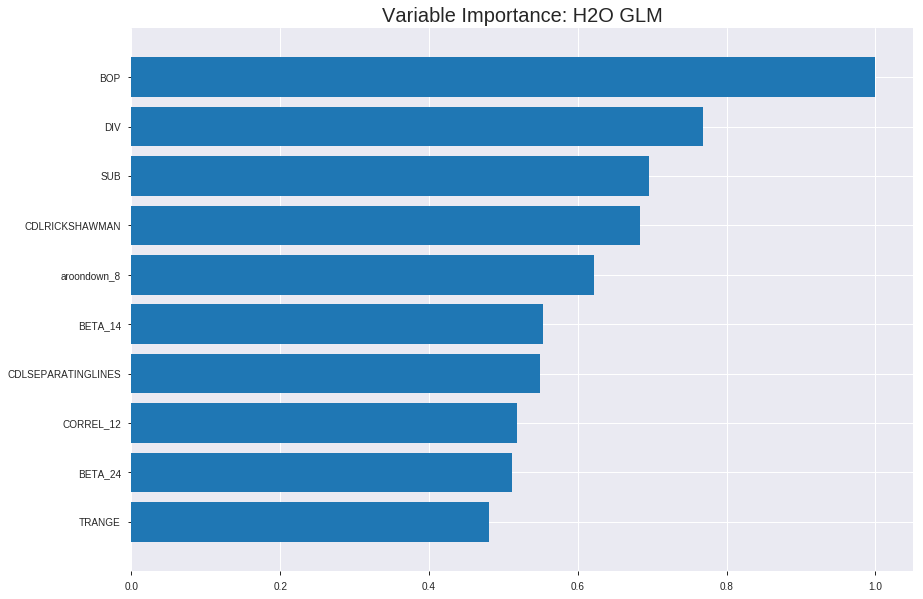

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124101_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2172074507996529
RMSE: 0.4660552014511295
LogLoss: 0.6230547913945249
Null degrees of freedom: 1784
Residual degrees of freedom: 762
Null deviance: 2474.2390678544516
Residual deviance: 2224.305605278454
AIC: 4270.305605278454
AUC: 0.710971793918817
pr_auc: 0.6774882168400315
Gini: 0.4219435878376341
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3988529586289714: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      330  574   0.635    (574.0/904.0)
1      86   795   0.0976   (86.0/881.0)
Total  416  1369  0.3697   (660.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398853     0.706667  262
max f2                       0.260021     0.837994  334
max f0point5                 0.502158     0.646942  189
max accuracy                 0.502158     0.652101  189
max precision                0.916834     1         0
max recall                   0.179303     1         367
max specificity              0.916834     1         0
max absolute_mcc             0.427875     0.324668  244
max min_per_class_accuracy   0.506991     0.649336  186
max mean_per_class_accuracy  0.499807     0.652339  191

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.785986           1.35074   1.35074            0.666667         0.841748  0.666667                    0.841748            0.0136209       0.0136209                  35.0738   35.0738
    2        0.0201681                   0.757928           1.57586   1.4633             0.777778         0.772355  0.722222                    0.807052            0.015891        0.0295119                  57.5861   46.3299
    3        0.0302521                   0.737974           1.80098   1.57586            0.888889         0.746958  0.777778                    0.78702             0.0181612       0.0476731                  80.0984   57.5861
    4        0.0403361                   0.724445           1.68842   1.604              0.833333         0.731645  0.791667                    0.773177            0.0170261       0.0646992                  68.8422   60.4001
    5        0.0504202                   0.712845           1.4633    1.57586            0.722222         0.7193    0.777778                    0.762401            0.014756        0.0794552                  46.3299   57.5861
    6        0.10028                     0.667709           1.59357   1.58466            0.786517         0.688253  0.782123                    0.725534            0.0794552       0.15891                    59.3567   58.4664
    7        0.15014                     0.638629           1.5708    1.58006            0.775281         0.65139   0.779851                    0.700912            0.0783201       0.23723                    57.0802   58.0061
    8        0.2                         0.614504           1.32038   1.51532            0.651685         0.62644   0.747899                    0.682346            0.0658343       0.303065                   32.0384   51.5323
    9        0.30028                     0.574379           1.16586   1.39862            0.575419         0.594977  0.690299                    0.653168            0.116913        0.419977                   16.586    39.8618
    10       0.4                         0.539308           1.20656   1.35074            0.595506         0.556226  0.666667                    0.629001            0.120318        0.540295                   20.6558   35.0738
    11       0.50028                     0.50655            1.1319    1.30687            0.558659         0.522831  0.645017                    0.607719            0.113507        0.653802                   13.1903   30.6873
    12       0.6                         0.468104           0.91061   1.24101            0.449438         0.486923  0.612512                    0.587643            0.0908059       0.744608                   -8.93902  24.1014
    13       0.69972                     0.431282           1.0472    1.21339            0.516854         0.450459  0.598879                    0.568092            0.104427        0.849035                   4.72012   21.3393
    14       0.8                         0.373173           0.724418  1.1521             0.357542         0.405221  0.568627                    0.547676            0.0726447       0.92168                    -27.5582  15.21
    15       0.89972                     0.301782           0.500835  1.07992            0.247191         0.341028  0.533001                    0.524773            0.0499432       0.971623                   -49.9165  7.99174
    16       1                           7.69438e-06        0.282976  1                  0.139665         0.213492  0.493557                    0.493557           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2371900109563721
RMSE: 0.48702157134604634
LogLoss: 0.6658690540623284
Null degrees of freedom: 509
Residual degrees of freedom: -513
Null deviance: 706.7340007881703
Residual deviance: 679.1864351435748
AIC: 2725.1864351435747
AUC: 0.6170816917015514
pr_auc: 0.5888505672551185
Gini: 0.23416338340310272
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3894875978056001: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   191  0.729    (191.0/262.0)
1      24   224  0.0968   (24.0/248.0)
Total  95   415  0.4216   (215.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389488     0.675716  313
max f2                       0.293804     0.831629  368
max f0point5                 0.426579     0.587729  280
max accuracy                 0.539424     0.586275  157
max precision                0.795007     1         0
max recall                   0.173871     1         397
max specificity              0.795007     1         0
max absolute_mcc             0.389488     0.223658  313
max min_per_class_accuracy   0.509483     0.564885  195
max mean_per_class_accuracy  0.426579     0.590787  280

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 49.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.753367           2.05645   2.05645            1                0.766007  1                           0.766007            0.0241935       0.0241935                  105.645   105.645
    2        0.0215686                   0.726607           1.64516   1.8695             0.8              0.738205  0.909091                    0.75337             0.016129        0.0403226                  64.5161   86.9501
    3        0.0313725                   0.703828           1.23387   1.67087            0.6              0.709204  0.8125                      0.739568            0.0120968       0.0524194                  23.3871   67.0867
    4        0.0411765                   0.686819           1.23387   1.56682            0.6              0.692228  0.761905                    0.728297            0.0120968       0.0645161                  23.3871   56.682
    5        0.0509804                   0.681932           1.23387   1.50279            0.6              0.684803  0.730769                    0.719933            0.0120968       0.0766129                  23.3871   50.2792
    6        0.1                         0.648826           1.06935   1.29032            0.52             0.662642  0.627451                    0.691849            0.0524194       0.129032                   6.93548   29.0323
    7        0.15098                     0.621395           1.18641   1.25524            0.576923         0.633158  0.61039                     0.672031            0.0604839       0.189516                   18.6414   25.5237
    8        0.2                         0.604118           1.23387   1.25               0.6              0.612687  0.607843                    0.657486            0.0604839       0.25                       23.3871   25
    9        0.3                         0.571405           1.08871   1.19624            0.529412         0.590015  0.581699                    0.634996            0.108871        0.358871                   8.87097   19.6237
    10       0.4                         0.536617           1.25      1.20968            0.607843         0.554131  0.588235                    0.61478             0.125           0.483871                   25        20.9677
    11       0.5                         0.509247           0.846774  1.1371             0.411765         0.522521  0.552941                    0.596328            0.0846774       0.568548                   -15.3226  13.7097
    12       0.6                         0.47656            1.08871   1.12903            0.529412         0.493444  0.54902                     0.579181            0.108871        0.677419                   8.87097   12.9032
    13       0.7                         0.442282           1.04839   1.11751            0.509804         0.460492  0.543417                    0.562225            0.104839        0.782258                   4.83871   11.7512
    14       0.8                         0.396875           1.04839   1.10887            0.509804         0.418795  0.539216                    0.544296            0.104839        0.887097                   4.83871   10.8871
    15       0.9                         0.320281           0.685484  1.06183            0.333333         0.36309   0.51634                     0.524162            0.0685484       0.955645                   -31.4516  6.1828
    16       1                           0.0585168          0.443548  1                  0.215686         0.260826  0.486275                    0.497829            0.04


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:41:06  0.000 sec   2            .68E1     1022          1.365222295766972   1.3780930567635417
     2019-08-22 12:41:08  2.301 sec   4            .5E1      1022          1.3607032653494557  1.3757997966007296
     2019-08-22 12:41:10  4.574 sec   6            .36E1     1022          1.3553447185734433  1.372907611259552
     2019-08-22 12:41:13  6.868 sec   8            .26E1     1022          1.3490854555684249  1.369403339176755
     2019-08-22 12:41:15  9.143 sec   10           .19E1     1023          1.3419001695947321  1.3653869702417651
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:41:43  36.890 sec  34           .43E-1    1023          1.2391692216453107  1.3320214166955295
     2019-08-22 12:41:45  39.131 sec  36           .31E-1    1023          1.2325493997472858  1.3327891602045134
     2019-08-22 12:41:47  41.364 sec  38           .23E-1    1023          1.2261637216450896  1.334015493023866
     2019-08-22 12:41:50  43.629 sec  40           .16E-1    1023          1.220027052181469   1.3356715124760654
     2019-08-22 12:41:52  46.022 sec  42           .12E-1    1023          1.2141557340405427  1.337804344164161


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6015625)

('F1', 0.6778711484593838)

('auc', 0.59130859375)

('logloss', 0.6870306502505314)

('mean_per_class_error', 0.3984375)

('rmse', 0.49545457027009404)

('mse', 0.24547523120152354)

glm prediction progress: |████████████████████████████████████████████████| 100%


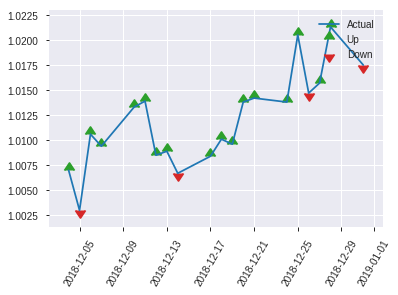


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24547523120152354
RMSE: 0.49545457027009404
LogLoss: 0.6870306502505314
Null degrees of freedom: 255
Residual degrees of freedom: -767
Null deviance: 354.9338629373763
Residual deviance: 351.7596929282721
AIC: 2397.759692928272
AUC: 0.59130859375
pr_auc: 0.5570148342887576
Gini: 0.1826171875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3711551773762091: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   108  0.8438   (108.0/128.0)
1      7    121  0.0547   (7.0/128.0)
Total  27   229  0.4492   (115.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371155     0.677871  228
max f2                       0.304326     0.835526  247
max f0point5                 0.465818     0.60625   167
max accuracy                 0.46755      0.601562  165
max precision                0.64093      0.666667  32
max recall                   0.195927     1         254
max specificity              0.932692     0.992188  0
max absolute_mcc             0.465818     0.213834  167
max min_per_class_accuracy   0.51691      0.546875  126
max mean_per_class_accuracy  0.46755      0.601562  165

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.749669           0.666667  0.666667           0.333333         0.814907  0.333333                    0.814907            0.0078125       0.0078125                  -33.3333  -33.3333
    2        0.0234375                   0.732593           0.666667  0.666667           0.333333         0.739667  0.333333                    0.777287            0.0078125       0.015625                   -33.3333  -33.3333
    3        0.03125                     0.723054           2         1                  1                0.727383  0.5                         0.764811            0.015625        0.03125                    100       0
    4        0.0429688                   0.713146           1.33333   1.09091            0.666667         0.718601  0.545455                    0.752208            0.015625        0.046875                   33.3333   9.09091
    5        0.0507812                   0.70467            1         1.07692            0.5              0.707482  0.538462                    0.745327            0.0078125       0.0546875                  0         7.69231
    6        0.101562                    0.652101           1.38462   1.23077            0.692308         0.672573  0.615385                    0.70895             0.0703125       0.125                      38.4615   23.0769
    7        0.152344                    0.627661           1.38462   1.28205            0.692308         0.641193  0.641026                    0.686365            0.0703125       0.195312                   38.4615   28.2051
    8        0.203125                    0.606816           0.615385  1.11538            0.307692         0.615446  0.557692                    0.668635            0.03125         0.226562                   -38.4615  11.5385
    9        0.300781                    0.566071           1.44      1.22078            0.72             0.584694  0.61039                     0.641381            0.140625        0.367188                   44        22.0779
    10       0.402344                    0.542609           0.769231  1.1068             0.384615         0.553744  0.553398                    0.619259            0.078125        0.445312                   -23.0769  10.6796
    11       0.5                         0.51617            1.04      1.09375            0.52             0.528454  0.546875                    0.601524            0.101562        0.546875                   4         9.375
    12       0.601562                    0.48136            1.23077   1.11688            0.615385         0.499575  0.558442                    0.584312            0.125           0.671875                   23.0769   11.6883
    13       0.699219                    0.455749           0.88      1.0838             0.44             0.467203  0.541899                    0.567956            0.0859375       0.757812                   -12       8.37989
    14       0.800781                    0.415988           0.923077  1.06341            0.461538         0.434724  0.531707                    0.551058            0.09375         0.851562                   -7.69231  6.34146
    15       0.898438                    0.367915           0.96      1.05217            0.48             0.392256  0.526087                    0.533797            0.09375         0.945312                   -4        5.21739
    16       1                           0.151001           0.538462  1                  0.269231         0.309987  0.5                         0.511066            0.0

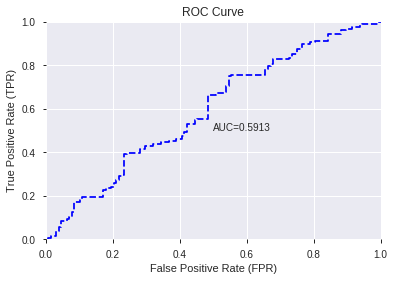

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


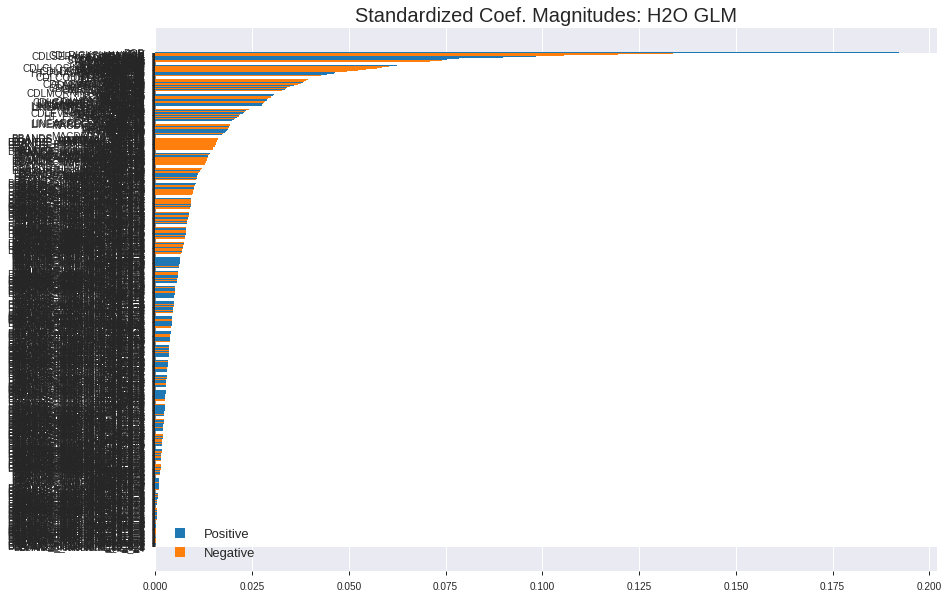

'log_likelihood'
--2019-08-22 12:42:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


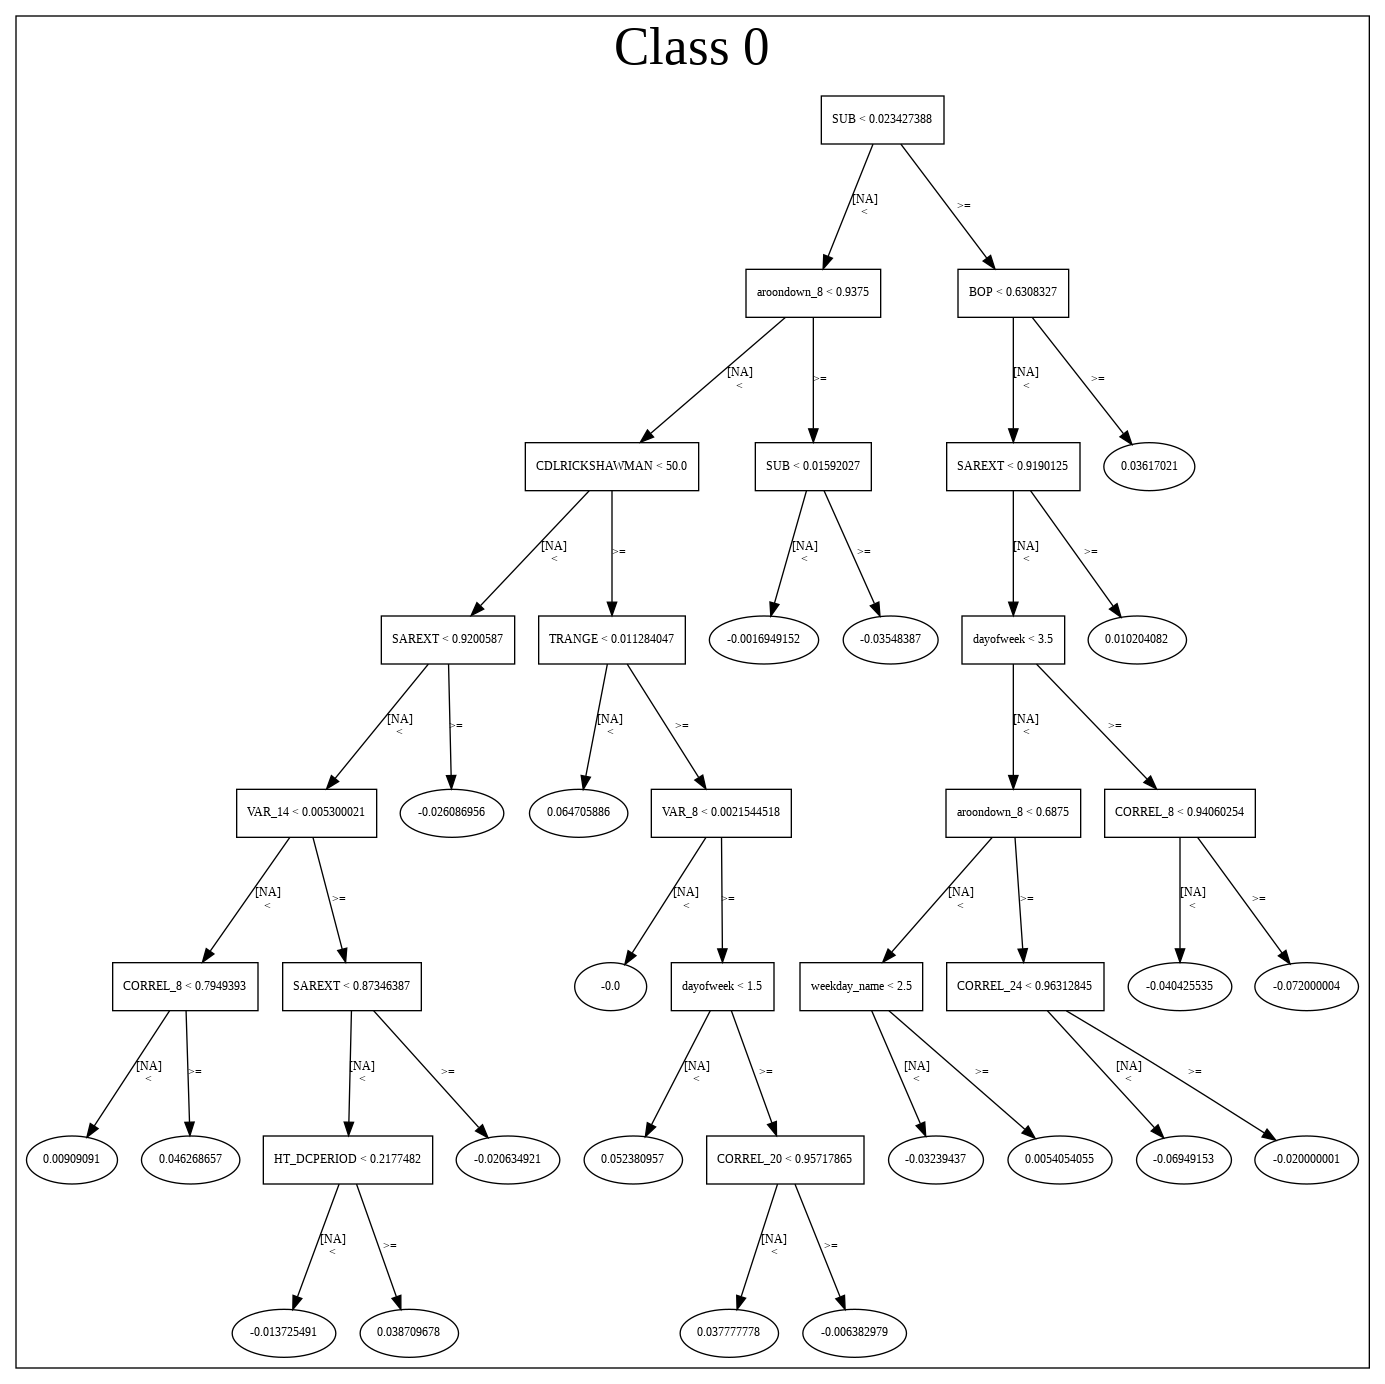

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124101_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124101_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

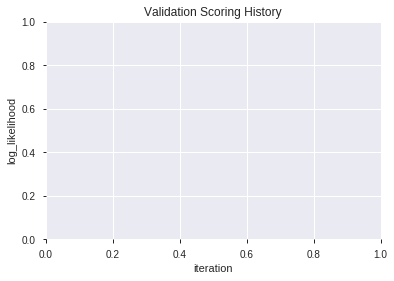

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124233_model_6  0.635193  0.661357              0.425781  0.484349  0.234594
1               XGBoost_3_AutoML_20190822_124233  0.611145  0.668001              0.410156  0.487865  0.238012
2  XGBoost_grid_1_AutoML_20190822_124233_model_4  0.601807  0.671766              0.386719  0.489483  0.239594
3  XGBoost_grid_1_AutoML_20190822_124233_model_2  0.591675  0.679577              0.421875  0.493335  0.243380
4               XGBoost_1_AutoML_20190822_124233  0.587036  0.685996              0.425781  0.496461  0.246474
5  XGBoost_grid_1_AutoML_20190822_124233_model_1  0.586731  0.676606              0.390625  0.492013  0.242077
6  XGBoost_grid_1_AutoML_20190822_124233_model_3  0.581177  0.689852              0.378906  0.497548  0.247554
7               XGBoost_2_AutoML_20190822_124233  0.569153  0.686573              0.429688  0.496750  0.246760
8  XGBoost_grid_1_AutoML_20190822_124233_model_7  0.553528  0.698896              0.433594  0.502669  0.252676
9  XGBoost_grid_1_AutoML_20190822_124233_model_5  0.539673  0.718667              0.433594  0.510438  0.260547

variable  relative_importance  scaled_importance  percentage
0                        BOP           410.355438           1.000000    0.046171
1                        DIV           275.569672           0.671539    0.031006
2                        SUB           265.057159           0.645921    0.029823
3                aroondown_8           139.641968           0.340295    0.015712
4                     ULTOSC           117.386574           0.286061    0.013208
..                       ...                  ...                ...         ...
339  BBANDS_lowerband_14_7_5             2.899383           0.007066    0.000326
340  BBANDS_lowerband_30_1_2             2.890218           0.007043    0.000325
341   BBANDS_upperband_8_3_3             2.456624           0.005987    0.000276
342   BBANDS_upperband_8_3_2             2.406115           0.005863    0.000271
343  BBANDS_upperband_14_5_2             0.791297           0.001928    0.000089

[344 rows x 4 columns]

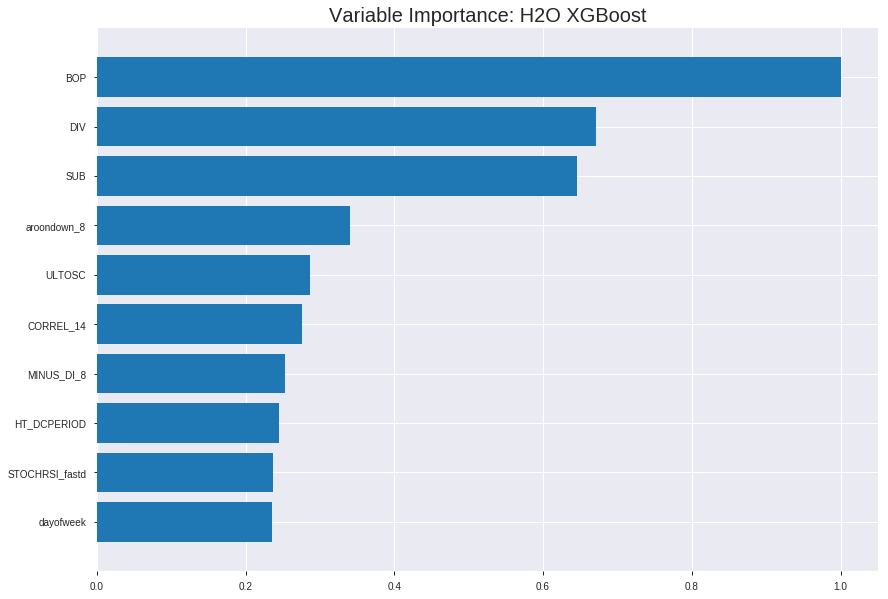

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124233_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15745698966979735
RMSE: 0.3968085050371241
LogLoss: 0.49783778528993794
Mean Per-Class Error: 0.11985010496921245
AUC: 0.9488683163741927
pr_auc: 0.9475954961657241
Gini: 0.8977366327483853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5070809721946716: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      793  111  0.1228   (111.0/904.0)
1      103  778  0.1169   (103.0/881.0)
Total  896  889  0.1199   (214.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507081     0.879096  185
max f2                       0.442288     0.917293  228
max f0point5                 0.540493     0.888804  161
max accuracy                 0.509602     0.880112  183
max precision                0.857304     1         0
max recall                   0.22279      1         360
max specificity              0.857304     1         0
max absolute_mcc             0.507081     0.760243  185
max min_per_class_accuracy   0.508346     0.879425  184
max mean_per_class_accuracy  0.507081     0.88015   185

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.795757           2.02611    2.02611            1                0.823249  1                           0.823249            0.0204313       0.0204313                  102.611   102.611
    2        0.0201681                   0.765507           2.02611    2.02611            1                0.778791  1                           0.80102             0.0204313       0.0408627                  102.611   102.611
    3        0.0302521                   0.748947           2.02611    2.02611            1                0.757479  1                           0.786506            0.0204313       0.061294                   102.611   102.611
    4        0.0403361                   0.73771            2.02611    2.02611            1                0.744239  1                           0.775939            0.0204313       0.0817253                  102.611   102.611
    5        0.0504202                   0.725218           2.02611    2.02611            1                0.732252  1                           0.767202            0.0204313       0.102157                   102.611   102.611
    6        0.10028                     0.689551           2.02611    2.02611            1                0.706036  1                           0.73679             0.101022        0.203178                   102.611   102.611
    7        0.15014                     0.659471           2.02611    2.02611            1                0.674565  1                           0.716126            0.101022        0.3042                     102.611   102.611
    8        0.2                         0.636133           1.95781    2.00908            0.966292         0.647467  0.991597                    0.699009            0.0976163       0.401816                   95.7811   100.908
    9        0.30028                     0.592569           1.83368    1.95051            0.905028         0.614331  0.962687                    0.67073             0.183882        0.585698                   83.3683   95.0506
    10       0.4                         0.54973            1.66186    1.87855            0.820225         0.572961  0.927171                    0.646357            0.165721        0.751419                   66.1863   87.8547
    11       0.50028                     0.506124           1.32433    1.76745            0.653631         0.528041  0.87234                     0.622641            0.132804        0.884222                   32.4327   76.7455
    12       0.6                         0.457275           0.69434    1.5891             0.342697         0.481678  0.784314                    0.599213            0.0692395       0.953462                   -30.566   58.9103
    13       0.69972                     0.408789           0.295948   1.40481            0.146067         0.433235  0.693355                    0.575558            0.0295119       0.982974                   -70.4052  40.4811
    14       0.8                         0.348966           0.124509   1.24432            0.0614525        0.380472  0.614146                    0.551104            0.0124858       0.99546                    -87.5491  24.4325
    15       0.89972                     0.278981           0.0341479  1.1102             0.0168539        0.316521  0.547945                    0.525104            0.00340522      0.998865                   -96.5852  11.0195
    16       1                           0.0972927          0.011319   1                  0.00558659       0.216223  0.493557                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24004362367316104
RMSE: 0.48994246975860445
LogLoss: 0.6725311213696258
Mean Per-Class Error: 0.4025332430435853
AUC: 0.6162967865057868
pr_auc: 0.5891294050310915
Gini: 0.23259357301157357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3546832501888275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   241  0.9198   (241.0/262.0)
1      2    246  0.0081   (2.0/248.0)
Total  23   487  0.4765   (243.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354683     0.669388  376
max f2                       0.354683     0.831643  376
max f0point5                 0.546661     0.586066  182
max accuracy                 0.546661     0.598039  182
max precision                0.723988     1         0
max recall                   0.317682     1         390
max specificity              0.723988     1         0
max absolute_mcc             0.546661     0.195076  182
max min_per_class_accuracy   0.54358      0.58871   188
max mean_per_class_accuracy  0.546661     0.597467  182

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 52.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.703876           1.71371   1.71371            0.833333         0.716029  0.833333                    0.716029            0.0201613       0.0201613                  71.371    71.371
    2        0.0215686                   0.682471           0.822581  1.30865            0.4              0.690374  0.636364                    0.704368            0.00806452      0.0282258                  -17.7419  30.8651
    3        0.0313725                   0.680414           1.64516   1.41381            0.8              0.681264  0.6875                      0.697148            0.016129        0.0443548                  64.5161   41.381
    4        0.0411765                   0.671099           1.23387   1.37097            0.6              0.676712  0.666667                    0.692282            0.0120968       0.0564516                  23.3871   37.0968
    5        0.0509804                   0.665671           1.64516   1.4237             0.8              0.668396  0.692308                    0.687689            0.016129        0.0725806                  64.5161   42.3697
    6        0.1                         0.643655           1.48065   1.45161            0.72             0.653793  0.705882                    0.671073            0.0725806       0.145161                   48.0645   45.1613
    7        0.15098                     0.628006           0.949132  1.28194            0.461538         0.635561  0.623377                    0.659082            0.0483871       0.193548                   -5.08685  28.1944
    8        0.2                         0.613771           1.06935   1.22984            0.52             0.621185  0.598039                    0.649794            0.0524194       0.245968                   6.93548   22.9839
    9        0.3                         0.590068           1.12903   1.19624            0.54902          0.60177   0.581699                    0.633786            0.112903        0.358871                   12.9032   19.6237
    10       0.4                         0.561822           1.20968   1.1996             0.588235         0.575113  0.583333                    0.619118            0.120968        0.479839                   20.9677   19.9597
    11       0.5                         0.541431           1.08871   1.17742            0.529412         0.550956  0.572549                    0.605485            0.108871        0.58871                    8.87097   17.7419
    12       0.6                         0.512958           0.887097  1.12903            0.431373         0.52599   0.54902                     0.592236            0.0887097       0.677419                   -11.2903  12.9032
    13       0.7                         0.48378            1.00806   1.11175            0.490196         0.499445  0.540616                    0.57898             0.100806        0.778226                   0.806452  11.1751
    14       0.8                         0.442031           0.806452  1.07359            0.392157         0.466287  0.522059                    0.564894            0.0806452       0.858871                   -19.3548  7.35887
    15       0.9                         0.396775           0.887097  1.05287            0.431373         0.418428  0.511983                    0.54862             0.0887097       0.947581                   -11.2903  5.28674
    16       1                           0.213855           0.524194  1                  0.254902         0.347902  0.486275                    0.528548           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:43:24  30.636 sec  0                  0.5              0.693147            0.5             0                  1                0.506443                         0.5                0.693147              0.5               0                    1                  0.513725
    2019-08-22 12:43:25  31.906 sec  5                  0.483324         0.66023             0.79649         0.781064           2.02611          0.284034                         0.496128           0.685404              0.590787          0.56769              1.37097            0.47451
    2019-08-22 12:43:25  32.157 sec  10                 0.469465         0.633345            0.832202        0.822083           2.02611          0.256583                         0.49443            0.681986              0.604616          0.585578             1.37097            0.468627
    2019-08-22 12:43:26  32.412 sec  15                 0.458627         0.612458            0.851571        0.84452            2.02611          0.261625                         0.493889           0.680878              0.604331          0.586443             1.71371            0.488235
    2019-08-22 12:43:26  32.734 sec  20                 0.448281         0.592884            0.878853        0.873723           2.02611          0.212325                         0.49412            0.681348              0.600122          0.580961             1.71371            0.484314
    2019-08-22 12:43:26  32.991 sec  25                 0.438599         0.574336            0.889198        0.883523           2.02611          0.203922                         0.492976           0.679026              0.609448          0.576192             1.37097            0.460784
    2019-08-22 12:43:27  33.257 sec  30                 0.428951         0.556433            0.910794        0.90794            2.02611          0.180952                         0.492059           0.677119              0.612795          0.578489             1.71371            0.468627
    2019-08-22 12:43:27  33.525 sec  35                 0.419287         0.538718            0.927591        0.924749           2.02611          0.163025                         0.491362           0.675694              0.612203          0.578859             1.71371            0.492157
    2019-08-22 12:43:27  33.778 sec  40                 0.413118         0.52722             0.931928        0.929743           2.02611          0.148459                         0.491126           0.67516               0.612418          0.575329             1.71371            0.47451
    2019-08-22 12:43:27  34.047 sec  45                 0.405591         0.513478            0.940028        0.938237           2.02611          0.137815                         0.4907             0.674229              0.613442          0.586542             1.71371            0.484314
    2019-08-22 12:43:28  34.351 sec  50                 0.396809         0.497838            0.948868        0.947595           2.02611          0.119888                         0.489942           0.672531              0.616297          0.589129             1.71371            0.476471

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      410.3554382324219      1.0                    0.046171209917648184
DIV                      275.5696716308594      0.671538978057308      0.031005767123766906
SUB                      265.0571594238281      0.645920913258866      0.029822950076274127
aroondown_8              139.6419677734375      0.34029515576773095    0.015711839070910692
ULTOSC                   117.3865737915039      0.28606072408139294    0.013207769740756428
---                      ---                    ---                    ---
BBANDS_lowerband_14_7_5  2.8993825912475586     0.007065539581335761   0.00032622451119130544
BBANDS_lowerband_30_1_2  2.8902180194854736     0.0070432063284816965  0.00032519335788563653
BBANDS_upperband_8_3_3   2.4566240310668945     0.005986576031863098   0.0002764074586551123
BBANDS_upperband_8_3_2   2.4061145782470703     0.005863488951459362   0.000270724379227641
BBANDS_upperband_14_5_2  0.7912968993186951     0.0019283207326973723  8.903290133792353e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6015625)

('F1', 0.6997245179063362)

('auc', 0.63519287109375)

('logloss', 0.6613572300725706)

('mean_per_class_error', 0.3984375)

('rmse', 0.48434854431681434)

('mse', 0.23459351238181708)

xgboost prediction progress: |████████████████████████████████████████████| 100%


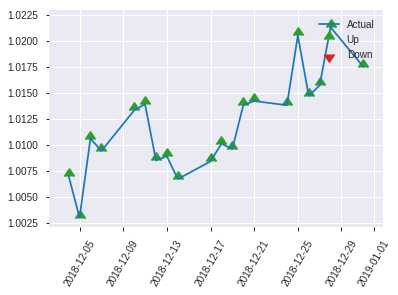


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23459351238181708
RMSE: 0.48434854431681434
LogLoss: 0.6613572300725706
Mean Per-Class Error: 0.3984375
AUC: 0.63519287109375
pr_auc: 0.5931249024141287
Gini: 0.2703857421875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3721228539943695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   108  0.8438   (108.0/128.0)
1      1    127  0.0078   (1.0/128.0)
Total  21   235  0.4258   (109.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372123     0.699725  234
max f2                       0.372123     0.850067  234
max f0point5                 0.450292     0.609244  205
max accuracy                 0.564097     0.601562  121
max precision                0.670936     0.769231  12
max recall                   0.263816     1         251
max specificity              0.715923     0.992188  0
max absolute_mcc             0.372123     0.270464  234
max min_per_class_accuracy   0.555911     0.59375   126
max mean_per_class_accuracy  0.564097     0.601562  121

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 53.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.682766           0.666667  0.666667           0.333333         0.694961  0.333333                    0.694961            0.0078125       0.0078125                  -33.3333  -33.3333
    2        0.0234375                   0.676794           1.33333   1                  0.666667         0.679399  0.5                         0.68718             0.015625        0.0234375                  33.3333   0
    3        0.03125                     0.675409           2         1.25               1                0.676492  0.625                       0.684508            0.015625        0.0390625                  100       25
    4        0.0429688                   0.672244           2         1.45455            1                0.673583  0.727273                    0.681529            0.0234375       0.0625                     100       45.4545
    5        0.0507812                   0.668077           2         1.53846            1                0.671071  0.769231                    0.67992             0.015625        0.078125                   100       53.8462
    6        0.101562                    0.65877            1.07692   1.30769            0.538462         0.662412  0.653846                    0.671166            0.0546875       0.132812                   7.69231   30.7692
    7        0.152344                    0.641593           0.923077  1.17949            0.461538         0.647947  0.589744                    0.663426            0.046875        0.179688                   -7.69231  17.9487
    8        0.203125                    0.628772           1.38462   1.23077            0.692308         0.635468  0.615385                    0.656437            0.0703125       0.25                       38.4615   23.0769
    9        0.300781                    0.597027           1.28      1.24675            0.64             0.609104  0.623377                    0.641069            0.125           0.375                      28        24.6753
    10       0.402344                    0.576594           1         1.18447            0.5              0.586691  0.592233                    0.627343            0.101562        0.476562                   0         18.4466
    11       0.5                         0.553174           1.2       1.1875             0.6              0.567078  0.59375                     0.615572            0.117188        0.59375                    20        18.75
    12       0.601562                    0.528102           0.846154  1.12987            0.423077         0.540195  0.564935                    0.602846            0.0859375       0.679688                   -15.3846  12.987
    13       0.699219                    0.49698            1.2       1.13966            0.6              0.509815  0.569832                    0.589853            0.117188        0.796875                   20        13.9665
    14       0.800781                    0.453212           1         1.12195            0.5              0.46922   0.560976                    0.574553            0.101562        0.898438                   0         12.1951
    15       0.898438                    0.383984           0.72      1.07826            0.36             0.418835  0.53913                     0.557627            0.0703125       0.96875                    -28       7.82609
    16       1                           0.248063           0.307692  1                  0.153846         0.319891  0.5                         0.533482            0.03125   

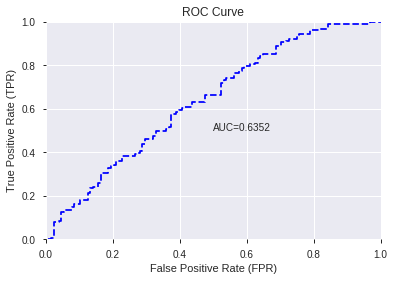

This function is available for GLM models only


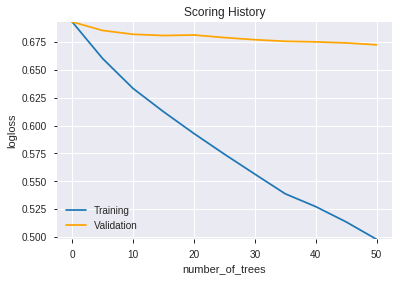

--2019-08-22 12:43:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

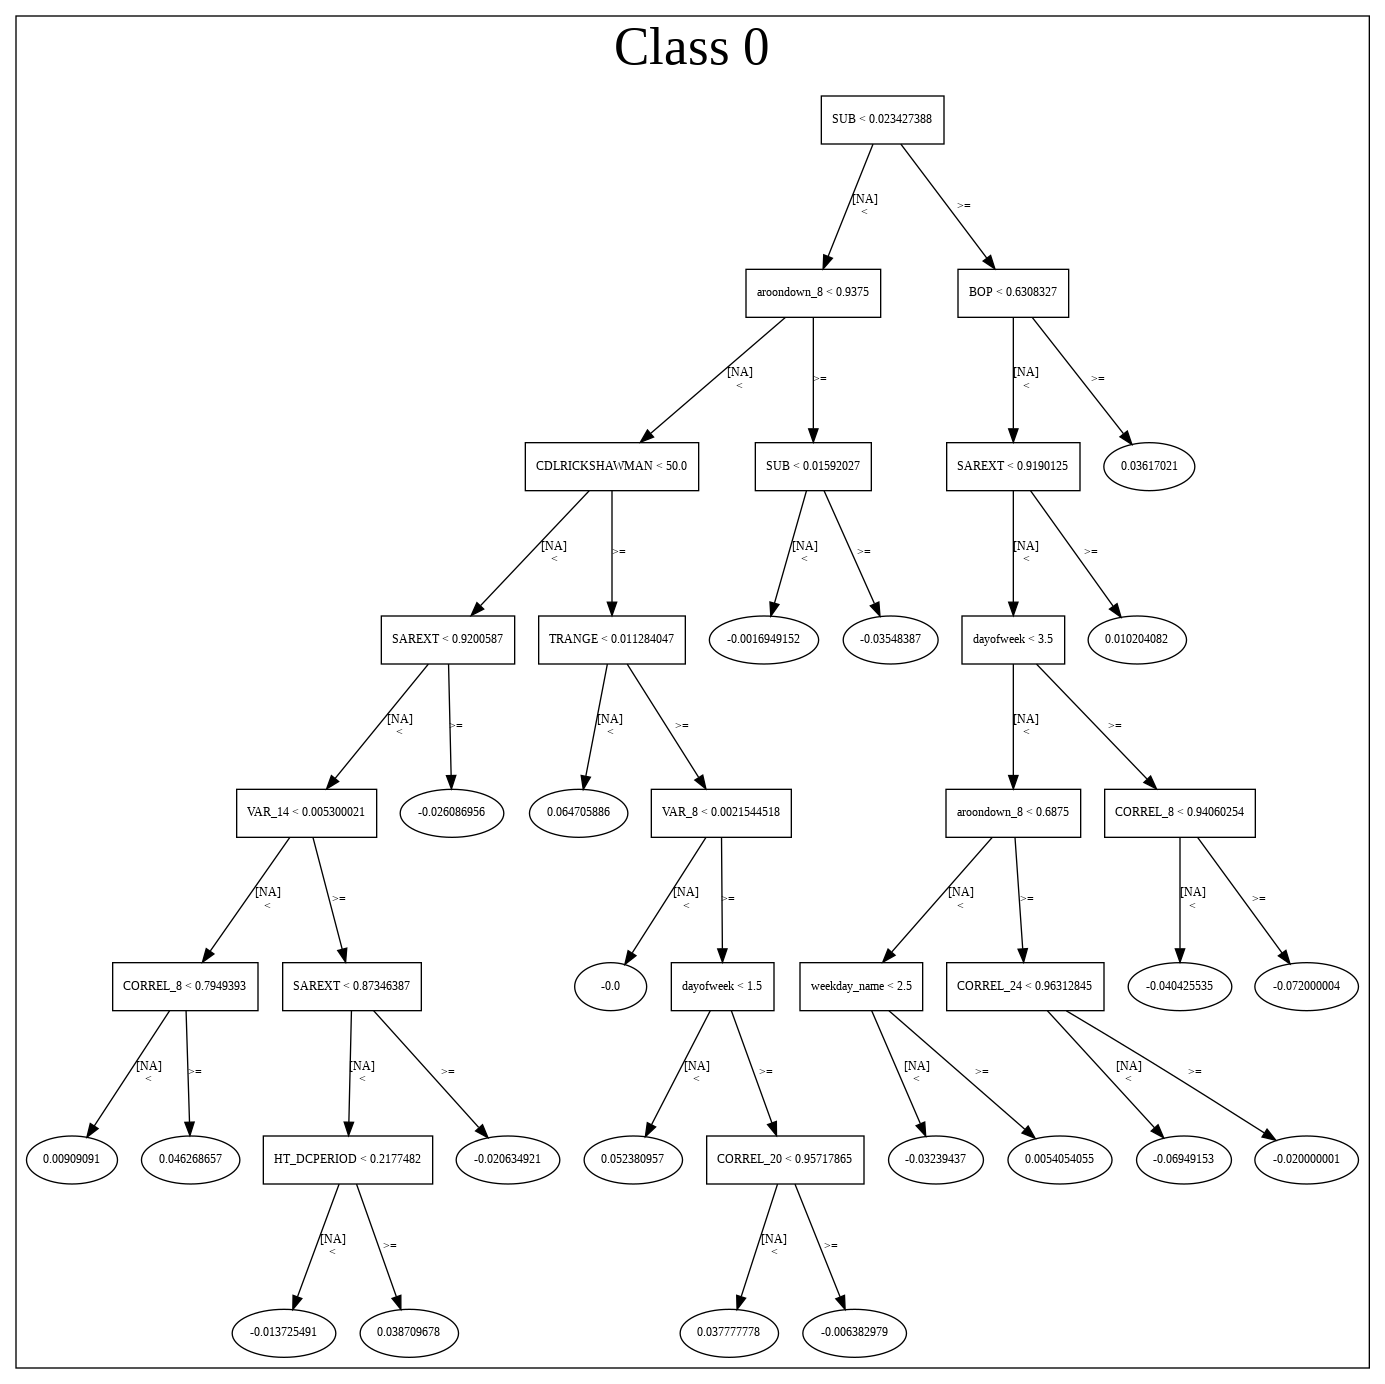

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124233_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124233_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_124349_model_1  0.588684  1.140755              0.429688  0.548003  0.300307
1  DeepLearning_grid_1_AutoML_20190822_124349_model_8  0.586060  0.684955              0.468750  0.496019  0.246035
2  DeepLearning_grid_1_AutoML_20190822_124349_model_3  0.574158  0.746504              0.488281  0.512736  0.262898
3  DeepLearning_grid_1_AutoML_20190822_124349_model_5  0.572449  0.688189              0.457031  0.497583  0.247589
4  DeepLearning_grid_1_AutoML_20190822_124349_model_4  0.564758  0.817734              0.445312  0.531438  0.282426
5  DeepLearning_grid_1_AutoML_20190822_124349_model_9  0.557007  0.686935              0.464844  0.496927  0.246936
6  DeepLearning_grid_1_AutoML_20190822_124349_model_6  0.551514  0.687463              0.457031  0.497501  0.247508
7  DeepLearning_grid_1_AutoML_20190822_124349_model_2  0.541809  0.822691              0.496094  0.534049  0.285209
8               DeepLearning_1_AutoML_20190822_124349  0.513306  0.735135              0.464844  0.516876  0.267160
9  DeepLearning_grid_1_AutoML_20190822_124349_model_7  0.506775  0.729359              0.500000  0.515552  0.265794

variable  relative_importance  scaled_importance  percentage
0       CDLADVANCEBLOCK             1.000000           1.000000    0.026132
1        CDLEVENINGSTAR             0.967532           0.967532    0.025284
2           CDLPIERCING             0.958231           0.958231    0.025041
3             CDLONNECK             0.955500           0.955500    0.024969
4          CDLTASUKIGAP             0.951404           0.951404    0.024862
5    CDLSEPARATINGLINES             0.931485           0.931485    0.024342
6        CDL3LINESTRIKE             0.902174           0.902174    0.023576
7    CDLEVENINGDOJISTAR             0.885097           0.885097    0.023130
8                 VAR_8             0.856395           0.856395    0.022380
9           CDL3OUTSIDE             0.856204           0.856204    0.022375
10           CDL3INSIDE             0.848620           0.848620    0.022176
11               TRANGE             0.845060           0.845060    0.022083
12  CDLXSIDEGAP3METHODS             0.840297           0.840297    0.021959
13        days_in_month             0.834247           0.834247    0.021801
14         CDLENGULFING             0.832290           0.832290    0.021750
15         HT_TRENDMODE             0.831293           0.831293    0.021724
16   CDLMORNINGDOJISTAR             0.828685           0.828685    0.021656
17               VAR_14             0.828373           0.828373    0.021647
18               VAR_12             0.804955           0.804955    0.021035
19                  SUB             0.803653           0.803653    0.021001
20       CDLMATCHINGLOW             0.796341           0.796341    0.020810
21            CORREL_30             0.793802           0.793802    0.020744
22       CDLHARAMICROSS             0.787989           0.787989    0.020592
23       CDLRICKSHAWMAN             0.787355           0.787355    0.020575
24                  DIV             0.779323           0.779323    0.020366
25         weekday_name             0.774787           0.774787    0.020247
26          HT_DCPERIOD             0.761947           0.761947    0.019911
27     CDLCOUNTERATTACK             0.755759           0.755759    0.019750
28            CORREL_24             0.745099           0.745099    0.019471
29            CORREL_20             0.741471           0.741471    0.019376
30              CDLDOJI             0.739148           0.739148    0.019316
31       is_quarter_end             0.728102           0.728102    0.019027
32               SAREXT             0.727831           0.727831    0.019020
33       CDLMORNINGSTAR             0.718472           0.718472    0.018775
34                  BOP             0.716030           0.716030    0.018712
35     is_quarter_start             0.705668           0.705668    0.018441
36    CDLLONGLEGGEDDOJI             0.701431           0.701431    0.018330
37             CORREL_8             0.695087           0.695087    0.018164
38          aroondown_8             0.684281           0.684281    0.017882
39         is_month_end             0.661430           0.661430    0.017285
40                FLOOR             0.651931           0.651931    0.017037
41            dayofweek             0.625256           0.625256    0.016339
42       is_month_start             0.611995           0.611995    0.015993
43      CDLSHOOTINGSTAR             0.597708           0.597708    0.015620
44                 CEIL             0.596032           0.596032    0.015576
45            CDLHAMMER             0.578146           0.578146    0.015108
46        CDLHANGINGMAN             0.568849           0.568849    0.014865
47              weekday             0.565168           0.565168    0.014769
48            CDLTAKURI             0.560454           0.560454    0.014646
49     CDLDRAGONFLYDOJI             0.548328           0.548328    0.014329

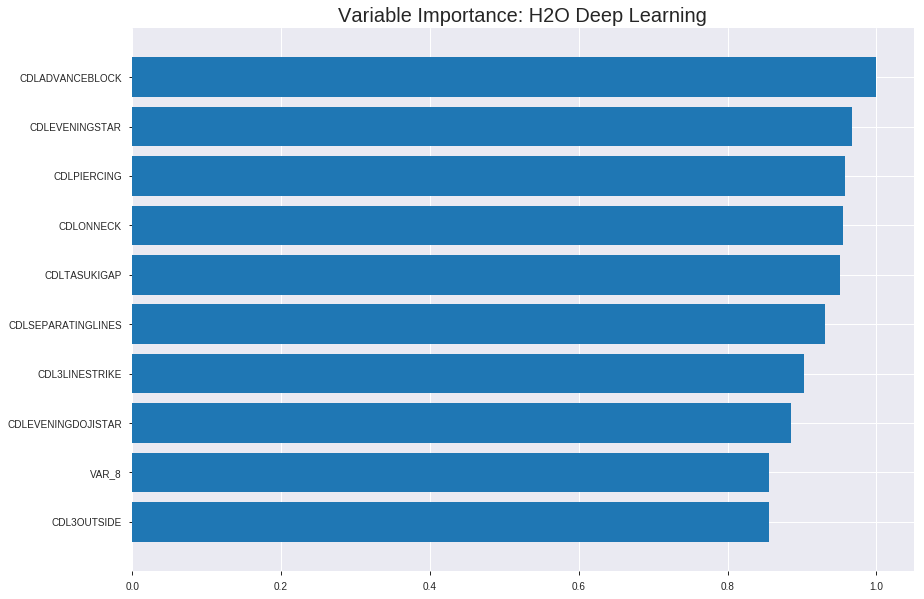

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_124349_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21051335358030598
RMSE: 0.45881734228373056
LogLoss: 0.7927154081952933
Mean Per-Class Error: 0.30785674464857915
AUC: 0.7475572057095216
pr_auc: 0.678009541128638
Gini: 0.4951144114190431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37755649739335806: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      451  453   0.5011   (453.0/904.0)
1      136  745   0.1544   (136.0/881.0)
Total  587  1198  0.33     (589.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377556     0.716691  259
max f2                       0.128252     0.8405    354
max f0point5                 0.62076      0.690544  160
max accuracy                 0.539532     0.691877  195
max precision                0.91145      0.794595  34
max recall                   0.000187927  1         399
max specificity              0.999963     0.980088  0
max absolute_mcc             0.49454      0.385172  214
max min_per_class_accuracy   0.552791     0.687855  189
max mean_per_class_accuracy  0.539532     0.692143  195

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 52.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    1                  1.4633    1.4633             0.722222         1          0.722222                    1                   0.014756        0.014756                   46.3299   46.3299
    2        0.0201681                   0.999998           1.23818   1.35074            0.611111         1          0.666667                    1                   0.0124858       0.0272418                  23.8176   35.0738
    3        0.0302521                   0.997538           1.23818   1.31322            0.611111         0.999405   0.648148                    0.999802            0.0124858       0.0397276                  23.8176   31.3217
    4        0.0403361                   0.983607           1.57586   1.37888            0.777778         0.991845   0.680556                    0.997812            0.015891        0.0556186                  57.5861   37.8878
    5        0.0504202                   0.97219            1.57586   1.41827            0.777778         0.97838    0.7                         0.993926            0.015891        0.0715096                  57.5861   41.8275
    6        0.10028                     0.913791           1.77569   1.59598            0.876404         0.940265   0.787709                    0.967245            0.0885358       0.160045                   77.5689   59.5983
    7        0.15014                     0.862596           1.52527   1.5725             0.752809         0.889016   0.776119                    0.941266            0.0760499       0.236095                   52.5271   57.2501
    8        0.2                         0.816346           1.5708    1.57208            0.775281         0.84084    0.77591                     0.91623             0.0783201       0.314415                   57.0802   57.2077
    9        0.30028                     0.719001           1.38092   1.50824            0.681564         0.764789   0.744403                    0.865656            0.138479        0.452894                   38.0922   50.824
    10       0.4                         0.634753           1.309     1.45857            0.646067         0.677867   0.719888                    0.81884             0.130533        0.583428                   30.9002   45.857
    11       0.50028                     0.548958           1.06399   1.37948            0.52514          0.591381   0.680851                    0.773246            0.106697        0.690125                   6.3989    37.9477
    12       0.6                         0.459771           0.967523  1.31101            0.477528         0.508749   0.647059                    0.729287            0.0964813       0.786606                   -3.24771  31.101
    13       0.69972                     0.349404           0.728488  1.22799            0.359551         0.402261   0.606085                    0.682681            0.0726447       0.859251                   -27.1512  22.7993
    14       0.8                         0.251467           0.656504  1.15636            0.324022         0.299091   0.570728                    0.634598            0.0658343       0.925085                   -34.3496  15.6356
    15       0.89972                     0.104594           0.534983  1.08749            0.264045         0.183397   0.536737                    0.584589            0.0533485       0.978434                   -46.5017  8.74869
    16       1                           8.14107e-15        0.215062  1                  0.106145         0.0329779  0.493557                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.304579066721701
RMSE: 0.5518868241965023
LogLoss: 1.007994835218741
Mean Per-Class Error: 0.4411628909135681
AUC: 0.5627000738734302
pr_auc: 0.5263610482701662
Gini: 0.12540014774686048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005579479028592708: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    260  0.9924   (260.0/262.0)
1      0    248  0        (0.0/248.0)
Total  2    508  0.5098   (260.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000557948  0.656085  398
max f2                       0.000557948  0.826667  398
max f0point5                 0.224426     0.554223  359
max accuracy                 0.696302     0.560784  151
max precision                0.999988     0.727273  0
max recall                   0.000557948  1         398
max specificity              0.999988     0.98855   0
max absolute_mcc             0.680789     0.118888  160
max min_per_class_accuracy   0.622143     0.545802  192
max mean_per_class_accuracy  0.680789     0.558837  160

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 59.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   1                  1.37097   1.37097            0.666667         1          0.666667                    1                   0.016129        0.016129                   37.0968   37.0968
    2        0.0215686                   0.999647           1.64516   1.4956             0.8              0.999974   0.727273                    0.999988            0.016129        0.0322581                  64.5161   49.5601
    3        0.0313725                   0.981146           1.23387   1.41381            0.6              0.993735   0.6875                      0.998034            0.0120968       0.0443548                  23.3871   41.381
    4        0.0411765                   0.971267           0.822581  1.27304            0.4              0.975405   0.619048                    0.992646            0.00806452      0.0524194                  -17.7419  27.3041
    5        0.0509804                   0.960602           1.23387   1.26551            0.6              0.965669   0.615385                    0.987458            0.0120968       0.0645161                  23.3871   26.5509
    6        0.1                         0.924796           1.23387   1.25               0.6              0.946779   0.607843                    0.967517            0.0604839       0.125                      23.3871   25
    7        0.15098                     0.88706            1.26551   1.25524            0.615385         0.905928   0.61039                     0.946721            0.0645161       0.189516                   26.5509   25.5237
    8        0.2                         0.857085           0.987097  1.18952            0.48             0.871072   0.578431                    0.92818             0.0483871       0.237903                   -1.29032  18.9516
    9        0.3                         0.784457           1.04839   1.14247            0.509804         0.822917   0.555556                    0.893092            0.104839        0.342742                   4.83871   14.2473
    10       0.4                         0.703364           1.12903   1.13911            0.54902          0.74683    0.553922                    0.856527            0.112903        0.455645                   12.9032   13.9113
    11       0.5                         0.621646           0.927419  1.09677            0.45098          0.659458   0.533333                    0.817113            0.0927419       0.548387                   -7.25806  9.67742
    12       0.6                         0.545397           0.967742  1.07527            0.470588         0.585961   0.522876                    0.778588            0.0967742       0.645161                   -3.22581  7.52688
    13       0.7                         0.464104           0.806452  1.03687            0.392157         0.505646   0.504202                    0.739596            0.0806452       0.725806                   -19.3548  3.68664
    14       0.8                         0.354393           0.927419  1.02319            0.45098          0.414347   0.497549                    0.69894             0.0927419       0.818548                   -7.25806  2.31855
    15       0.9                         0.224191           1.12903   1.03495            0.54902          0.289447   0.503268                    0.653441            0.112903        0.931452                   12.9032   3.49462
    16       1                           3.73348e-17        0.685484  1                  0.333333         0.0958338  0.486275                    0.597


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:43:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:43:57  6.096 sec         2689 obs/sec      9         1             16065      0.548593         1.06556             -0.204016      0.610807        0.567677           1.4633           0.462745                         0.593987           1.13436               -0.412347        0.568502          0.540049             1.71371            0.501961
    2019-08-22 12:44:02  11.813 sec        2767 obs/sec      18        2             32130      0.517842         0.886358            -0.0728213     0.666366        0.61855            1.68842          0.434174                         0.579942           1.04848               -0.346345        0.57896           0.54607              1.37097            0.503922
    2019-08-22 12:44:08  17.362 sec        2822 obs/sec      27        3             48195      0.532505         0.947654            -0.134435      0.670164        0.624479           1.68842          0.438655                         0.604068           1.18828               -0.460693        0.544155          0.519963             1.71371            0.505882
    2019-08-22 12:44:13  22.731 sec        2872 obs/sec      36        4             64260      0.488483         0.845061            0.0453797      0.695567        0.623443           1.57586          0.397199                         0.55947            1.02038               -0.252969        0.550219          0.523927             1.71371            0.513725
    2019-08-22 12:44:18  27.905 sec        2925 obs/sec      45        5             80325      0.480347         0.822719            0.0769145      0.715135        0.649924           1.23818          0.383754                         0.557292           1.0369                -0.243233        0.555151          0.511575             1.37097            0.513725
    2019-08-22 12:44:23  32.921 sec        2976 obs/sec      54        6             96390      0.478234         0.792441            0.0850156      0.722285        0.657365           1.80098          0.373669                         0.558227           1.04066               -0.247409        0.583315          0.536969             1.37097            0.503922
    2019-08-22 12:44:33  42.605 sec        3061 obs/sec      72        8             128520     0.458817         0.792715            0.157807       0.747557        0.67801            1.4633           0.329972                         0.551887           1.00799               -0.219235        0.5627            0.526361             1.37097            0.509804
    2019-08-22 12:44:42  51.904 sec        3141 obs/sec      90        10            160650     0.460851         0.779282            0.150323       0.745724        0.679912           1.35074          0.32437                          0.554692           1.02282               -0.231661        0.568233          0.537697             1.37097            0.507843
    2019-08-22 12:44:51

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLADVANCEBLOCK   1.0                    1.0                  0.026132369715657824
CDLEVENINGSTAR    0.9675324559211731     0.9675324559211731   0.0252839158500305
CDLPIERCING       0.9582308530807495     0.9582308530807495   0.02504084292565634
CDLONNECK         0.9554997086524963     0.9554997086524963   0.02496947164971037
CDLTASUKIGAP      0.9514038562774658     0.9514038562774658   0.024862437321145316
---               ---                    ---                  ---
CDLHAMMER         0.5781458616256714     0.5781458616256714   0.015108321405579593
CDLHANGINGMAN     0.5688492655754089     0.5688492655754089   0.01486537932049701
weekday           0.5651678442955017     0.5651678442955017   0.014769175058531385
CDLTAKURI         0.5604541897773743     0.5604541897773743   0.014645996095951798
CDLDRAGONFLYDOJI  0.5483277440071106     0.5483277440071106   0.014329103331746394


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6802325581395349)

('auc', 0.58868408203125)

('logloss', 1.1407547137558125)

('mean_per_class_error', 0.4140625)

('rmse', 0.5480028283715518)

('mse', 0.30030709990322046)

deeplearning prediction progress: |███████████████████████████████████████| 100%


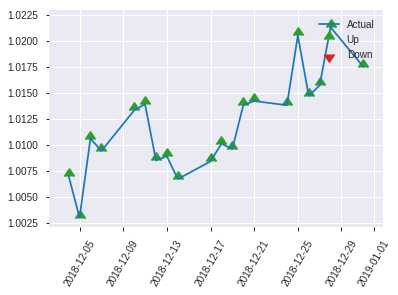


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.30030709990322046
RMSE: 0.5480028283715518
LogLoss: 1.1407547137558125
Mean Per-Class Error: 0.4140625
AUC: 0.58868408203125
pr_auc: 0.5387790320249369
Gini: 0.1773681640625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39496753493800996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      29   99   0.7734   (99.0/128.0)
1      11   117  0.0859   (11.0/128.0)
Total  40   216  0.4297   (110.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394968     0.680233  213
max f2                       0.0180335    0.833333  247
max f0point5                 0.526308     0.596065  181
max accuracy                 0.526308     0.585938  181
max precision                1            0.666667  0
max recall                   0.00442789   1         253
max specificity              1            0.992188  0
max absolute_mcc             0.394968     0.193649  213
max min_per_class_accuracy   0.69858      0.570312  125
max mean_per_class_accuracy  0.526308     0.585938  181

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 65.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   1                  1.33333   1.33333            0.666667         1         0.666667                    1                   0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.999927           0         0.666667           0                0.999999  0.333333                    1                   0               0.015625                   -100      -33.3333
    3        0.03125                     0.997308           1         0.75               0.5              0.998832  0.375                       0.999708            0.0078125       0.0234375                  0         -25
    4        0.0429688                   0.994984           0.666667  0.727273           0.333333         0.996136  0.363636                    0.998734            0.0078125       0.03125                    -33.3333  -27.2727
    5        0.0507812                   0.99057            1         0.769231           0.5              0.992774  0.384615                    0.997817            0.0078125       0.0390625                  0         -23.0769
    6        0.101562                    0.960038           1.23077   1                  0.615385         0.977275  0.5                         0.987546            0.0625          0.101562                   23.0769   0
    7        0.152344                    0.926844           1.38462   1.12821            0.692308         0.944229  0.564103                    0.973107            0.0703125       0.171875                   38.4615   12.8205
    8        0.203125                    0.895879           1.53846   1.23077            0.769231         0.90932   0.615385                    0.95716             0.078125        0.25                       53.8462   23.0769
    9        0.300781                    0.835423           1.12      1.19481            0.56             0.865223  0.597403                    0.92731             0.109375        0.359375                   12        19.4805
    10       0.402344                    0.77251            1.07692   1.16505            0.538462         0.800076  0.582524                    0.895193            0.109375        0.46875                    7.69231   16.5049
    11       0.5                         0.698478           1.04      1.14062            0.52             0.741531  0.570312                    0.865181            0.101562        0.570312                   4         14.0625
    12       0.601562                    0.619524           0.923077  1.1039             0.461538         0.657189  0.551948                    0.830065            0.09375         0.664062                   -7.69231  10.3896
    13       0.699219                    0.53927            1.12      1.10615            0.56             0.574846  0.553073                    0.79442             0.109375        0.773438                   12        10.6145
    14       0.800781                    0.430558           0.846154  1.07317            0.423077         0.487918  0.536585                    0.755547            0.0859375       0.859375                   -15.3846  7.31707
    15       0.898438                    0.266501           0.64      1.02609            0.32             0.368592  0.513043                    0.713487            0.0625          0.921875                   -36       2.6087
    16       1                           0.00442789         0.769231  1                  0.384615         0.120081  0.5                         0.653219            0.078

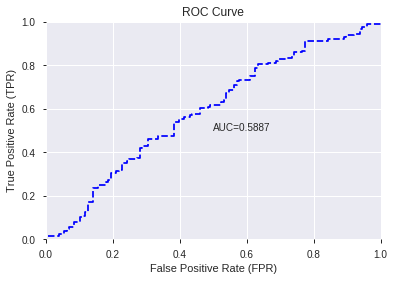

This function is available for GLM models only


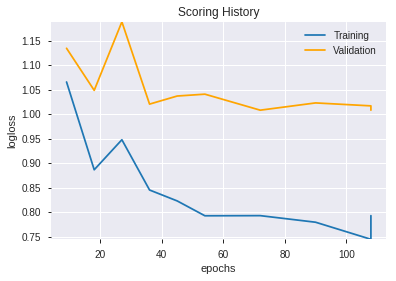

--2019-08-22 12:52:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


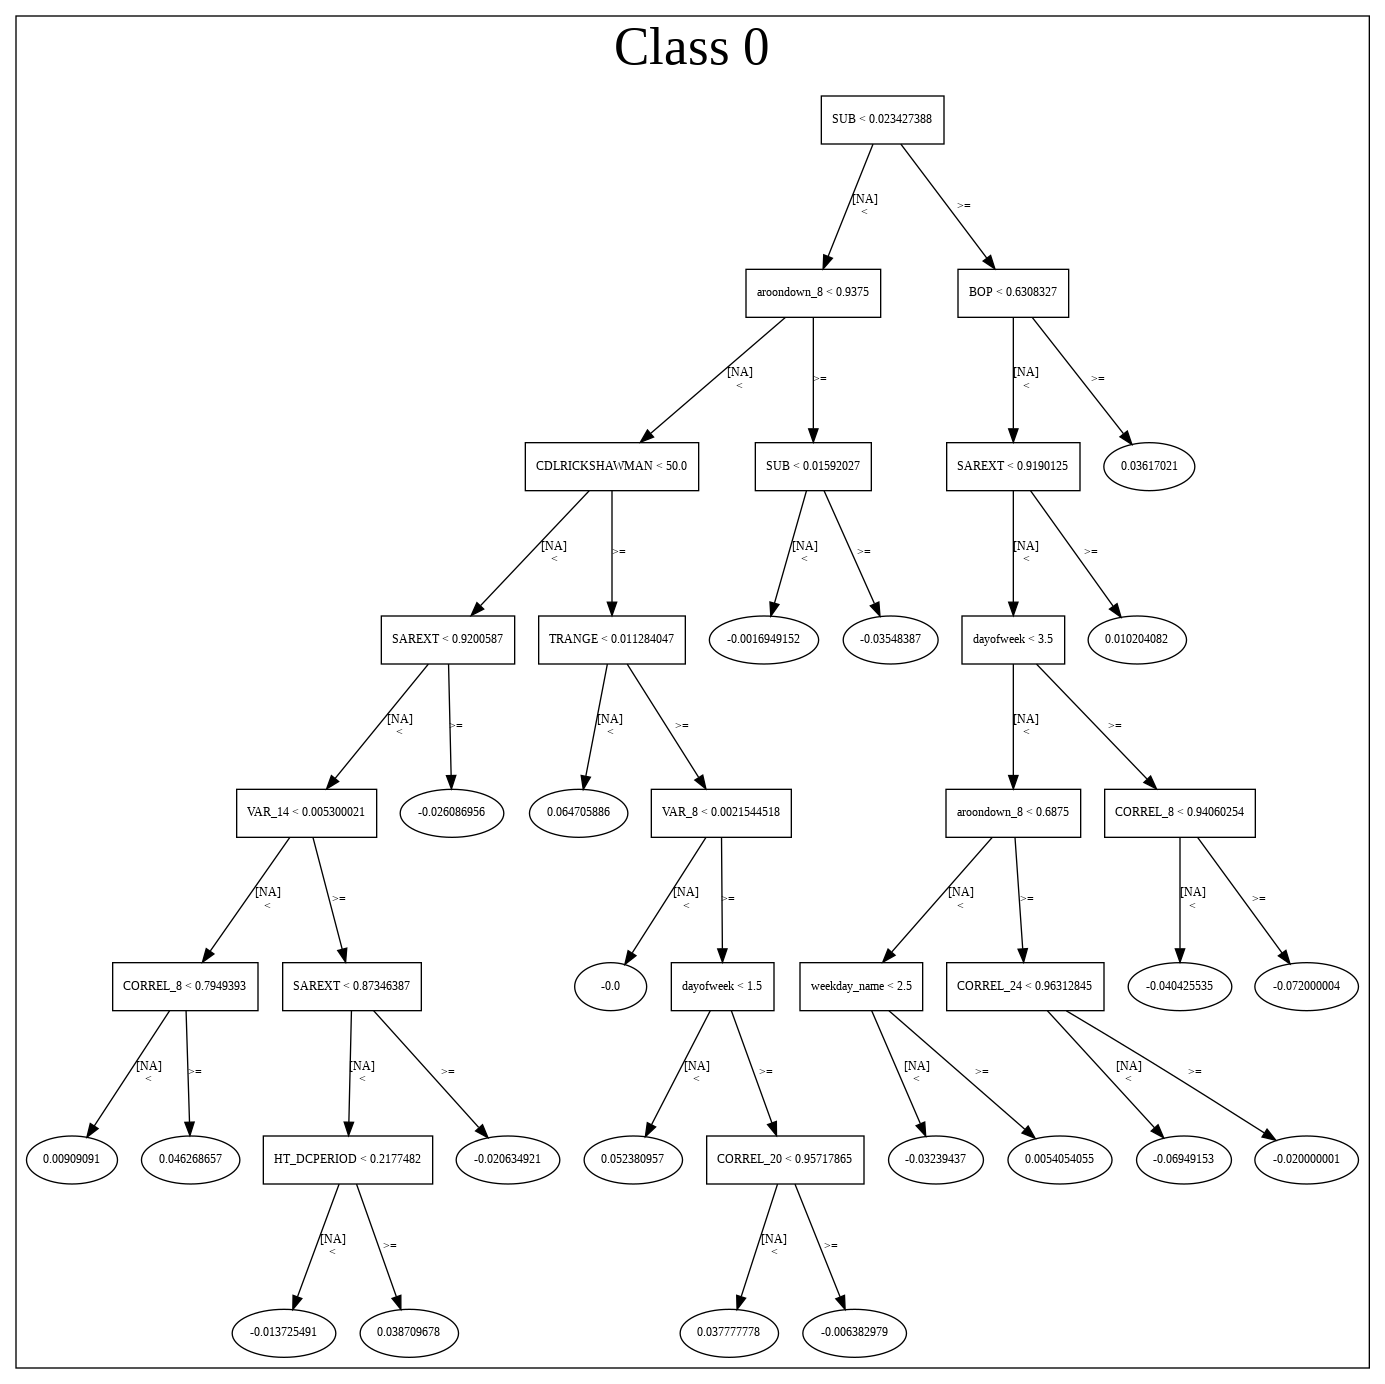

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_124349_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_124349_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLADVANCEBLOCK',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'VAR_8',
 'CDL3OUTSIDE',
 'CDL3INSIDE',
 'TRANGE',
 'CDLXSIDEGAP3METHODS',
 'days_in_month',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'VAR_14',
 'VAR_12',
 'SUB',
 'CDLMATCHINGLOW',
 'CORREL_30',
 'CDLHARAMICROSS',
 'CDLRICKSHAWMAN',
 'DIV',
 'weekday_name',
 'HT_DCPERIOD',
 'CDLCOUNTERATTACK',
 'CORREL_24',
 'CORREL_20',
 'CDLDOJI',
 'is_quarter_end',
 'SAREXT',
 'CDLMORNINGSTAR',
 'BOP',
 'is_quarter_start',
 'CDLLONGLEGGEDDOJI',
 'CORREL_8',
 'aroondown_8',
 'is_month_end',
 'FLOOR',
 'dayofweek',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CEIL',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'weekday',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_125219_model_1  0.565369  0.688771              0.472656  0.497764  0.247769

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.129363           1.000000    0.085238
1           aroondown_8             0.097542           0.754022    0.064271
2        CDLRICKSHAWMAN             0.090824           0.702084    0.059844
3             CDLTAKURI             0.068514           0.529627    0.045144
4      CDLDRAGONFLYDOJI             0.067810           0.524186    0.044680
5                   DIV             0.062839           0.485758    0.041405
6                   SUB             0.061248           0.473459    0.040357
7             dayofweek             0.056285           0.435090    0.037086
8               weekday             0.056280           0.435058    0.037083
9                TRANGE             0.052184           0.403395    0.034384
10   CDLSEPARATINGLINES             0.050027           0.386715    0.032963
11               VAR_14             0.046110           0.356439    0.030382
12       is_quarter_end             0.040936           0.316441    0.026973
13          CDL3OUTSIDE             0.040765           0.315118    0.026860
14            CDLHAMMER             0.035402           0.273661    0.023326
15         weekday_name             0.034048           0.263194    0.022434
16               VAR_12             0.032686           0.252670    0.021537
17         CDLENGULFING             0.030137           0.232966    0.019857
18                FLOOR             0.025928           0.200429    0.017084
19         CDLTASUKIGAP             0.025470           0.196890    0.016782
20       CDLHARAMICROSS             0.025372           0.196129    0.016718
21       is_month_start             0.025339           0.195879    0.016696
22          CDLPIERCING             0.024978           0.193085    0.016458
23        CDLHANGINGMAN             0.023754           0.183626    0.015652
24                 CEIL             0.023329           0.180339    0.015372
25               SAREXT             0.023238           0.179631    0.015311
26      CDLADVANCEBLOCK             0.019790           0.152980    0.013040
27              CDLDOJI             0.019706           0.152329    0.012984
28     is_quarter_start             0.019156           0.148081    0.012622
29   CDLEVENINGDOJISTAR             0.018942           0.146428    0.012481
30        days_in_month             0.017428           0.134718    0.011483
31       CDL3LINESTRIKE             0.016983           0.131284    0.011190
32     CDLCOUNTERATTACK             0.016281           0.125852    0.010727
33       CDLMATCHINGLOW             0.016033           0.123937    0.010564
34            CORREL_24             0.015188           0.117407    0.010007
35            CORREL_20             0.014482           0.111951    0.009542
36         HT_TRENDMODE             0.012836           0.099223    0.008458
37       CDLEVENINGSTAR             0.011854           0.091637    0.007811
38            CDLONNECK             0.010543           0.081501    0.006947
39          HT_DCPERIOD             0.009934           0.076792    0.006546
40           CDL3INSIDE             0.008084           0.062489    0.005326
41   CDLMORNINGDOJISTAR             0.007055           0.054534    0.004648
42  CDLXSIDEGAP3METHODS             0.006371           0.049253    0.004198
43    CDLLONGLEGGEDDOJI             0.005949           0.045989    0.003920
44            CORREL_30             0.005869           0.045366    0.003867
45         is_month_end             0.005652           0.043694    0.003724
46       CDLMORNINGSTAR             0.003966           0.030660    0.002613
47      CDLSHOOTINGSTAR             0.001865           0.014416    0.001229
48                VAR_8             0.001825           0.014111    0.001203
49             CORREL_8             0.001473           0.011383    0.000970

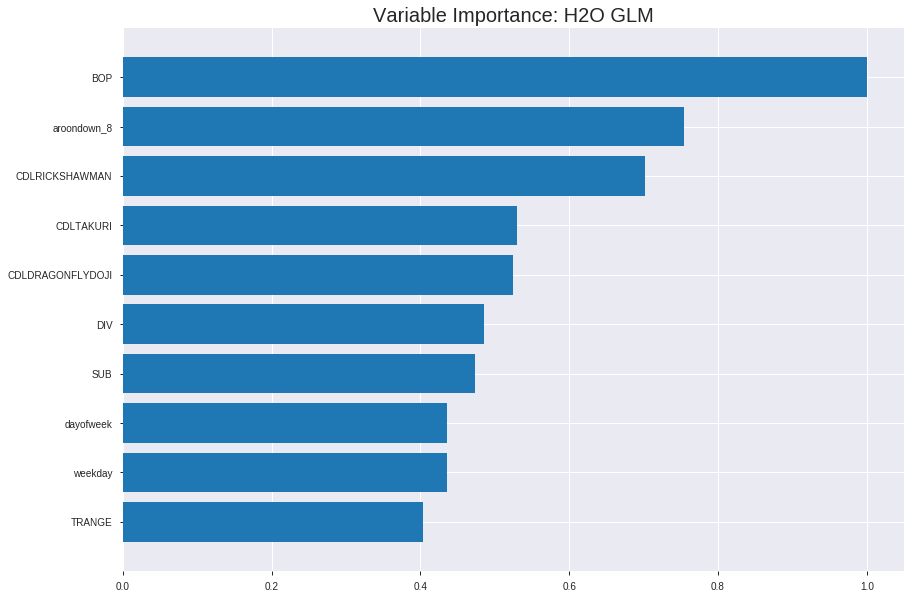

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_125219_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2327585794351048
RMSE: 0.48245059792180256
LogLoss: 0.6573139126409835
Null degrees of freedom: 1784
Residual degrees of freedom: 1734
Null deviance: 2474.2390678544516
Residual deviance: 2346.610668128311
AIC: 2448.610668128311
AUC: 0.6549419655861701
pr_auc: 0.6179798248800805
Gini: 0.30988393117234025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40314030084544855: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      204  700   0.7743   (700.0/904.0)
1      55   826   0.0624   (55.0/881.0)
Total  259  1526  0.423    (755.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40314      0.686332  294
max f2                       0.329943     0.837156  353
max f0point5                 0.506552     0.607297  174
max accuracy                 0.507561     0.612325  173
max precision                0.82508      1         0
max recall                   0.288166     1         373
max specificity              0.82508      1         0
max absolute_mcc             0.422345     0.238021  273
max min_per_class_accuracy   0.505694     0.609513  175
max mean_per_class_accuracy  0.506552     0.612275  174

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.659047           1.35074   1.35074            0.666667         0.710683  0.666667                    0.710683            0.0136209       0.0136209                  35.0738   35.0738
    2        0.0201681                   0.639374           1.35074   1.35074            0.666667         0.647614  0.666667                    0.679149            0.0136209       0.0272418                  35.0738   35.0738
    3        0.0302521                   0.62989            1.68842   1.4633             0.833333         0.634587  0.722222                    0.664295            0.0170261       0.0442679                  68.8422   46.3299
    4        0.0403361                   0.623941           1.4633    1.4633             0.722222         0.627047  0.722222                    0.654983            0.014756        0.0590238                  46.3299   46.3299
    5        0.0504202                   0.616926           1.01305   1.37325            0.5              0.619982  0.677778                    0.647982            0.0102157       0.0692395                  1.30533   37.325
    6        0.10028                     0.595716           1.36591   1.3696             0.674157         0.60496   0.675978                    0.626591            0.0681044       0.137344                   36.5915   36.9603
    7        0.15014                     0.577847           1.22932   1.32302            0.606742         0.586327  0.652985                    0.61322             0.061294        0.198638                   22.9323   32.3017
    8        0.2                         0.565242           1.34315   1.32804            0.662921         0.57165   0.655462                    0.602856            0.0669694       0.265607                   34.3149   32.8036
    9        0.30028                     0.543684           1.25641   1.30412            0.620112         0.553997  0.643657                    0.586539            0.125993        0.3916                     25.6413   30.4117
    10       0.4                         0.523747           1.13826   1.26277            0.561798         0.533162  0.623249                    0.573232            0.113507        0.505108                   13.8262   26.277
    11       0.50028                     0.505227           1.06399   1.22292            0.52514          0.514349  0.603583                    0.561429            0.106697        0.611805                   6.3989    22.2924
    12       0.6                         0.481612           0.91061   1.17102            0.449438         0.493104  0.577965                    0.550074            0.0908059       0.702611                   -8.93902  17.1018
    13       0.69972                     0.458442           1.0472    1.15337            0.516854         0.470266  0.569255                    0.5387              0.104427        0.807037                   4.72012   15.3372
    14       0.8                         0.423833           0.871565  1.11805            0.430168         0.442378  0.551821                    0.526626            0.0874007       0.894438                   -12.8435  11.8048
    15       0.89972                     0.37836            0.717105  1.07361            0.353933         0.403622  0.529888                    0.512993            0.0715096       0.965948                   -28.2895  7.36095
    16       1                           0.001797           0.339571  1                  0.167598         0.31918   0.493557                    0.493557           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24421045683755252
RMSE: 0.4941765442000991
LogLoss: 0.6815699170772536
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.7340007881703
Residual deviance: 695.2013154187987
AIC: 797.2013154187987
AUC: 0.5893791553804482
pr_auc: 0.5352930093302997
Gini: 0.17875831076089632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41876115025794985: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   220  0.8397   (220.0/262.0)
1      13   235  0.0524   (13.0/248.0)
Total  55   455  0.4569   (233.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418761     0.668563  346
max f2                       0.335853     0.826087  392
max f0point5                 0.521123     0.576299  186
max accuracy                 0.529329     0.590196  167
max precision                0.664901     1         0
max recall                   0.202735     1         399
max specificity              0.664901     1         0
max absolute_mcc             0.440404     0.180492  321
max min_per_class_accuracy   0.521123     0.572581  186
max mean_per_class_accuracy  0.529329     0.588217  167

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 50.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.638709           1.02823   1.02823            0.5              0.646224  0.5                         0.646224            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.629813           1.23387   1.1217             0.6              0.632238  0.545455                    0.639867            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.624672           0.822581  1.02823            0.4              0.627683  0.5                         0.636059            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.621716           0.822581  0.979263           0.4              0.623194  0.47619                     0.632996            0.00806452      0.0403226                  -17.7419  -2.07373
    5        0.0509804                   0.617996           0.41129   0.870037           0.2              0.619803  0.423077                    0.630459            0.00403226      0.0443548                  -58.871   -12.9963
    6        0.1                         0.601216           0.987097  0.927419           0.48             0.609665  0.45098                     0.620266            0.0483871       0.0927419                  -1.29032  -7.25806
    7        0.15098                     0.580597           1.4237    1.09499            0.692308         0.588508  0.532468                    0.609542            0.0725806       0.165323                   42.3697   9.49937
    8        0.2                         0.568807           1.06935   1.08871            0.52             0.574409  0.529412                    0.600931            0.0524194       0.217742                   6.93548   8.87097
    9        0.3                         0.550692           1.41129   1.19624            0.686275         0.56007   0.581699                    0.587311            0.141129        0.358871                   41.129    19.6237
    10       0.4                         0.533629           1.20968   1.1996             0.588235         0.542037  0.583333                    0.575992            0.120968        0.479839                   20.9677   19.9597
    11       0.5                         0.519048           0.927419  1.14516            0.45098          0.525837  0.556863                    0.565961            0.0927419       0.572581                   -7.25806  14.5161
    12       0.6                         0.499327           0.967742  1.11559            0.470588         0.50915   0.542484                    0.556493            0.0967742       0.669355                   -3.22581  11.5591
    13       0.7                         0.478497           0.766129  1.06567            0.372549         0.48907   0.518207                    0.546861            0.0766129       0.745968                   -23.3871  6.56682
    14       0.8                         0.450326           1.16935   1.07863            0.568627         0.465822  0.52451                     0.536731            0.116935        0.862903                   16.9355   7.8629
    15       0.9                         0.409961           0.846774  1.05287            0.411765         0.433148  0.511983                    0.525222            0.0846774       0.947581                   -15.3226  5.28674
    16       1                           0.202735           0.524194  1                  0.254902         0.363203  0.486275                    0.50902        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:52:19  0.000 sec   2            6.8       51            1.37622           1.38094
    2019-08-22 12:52:19  0.020 sec   4            4.3       51            1.37125           1.37861
    2019-08-22 12:52:19  0.038 sec   6            2.6       51            1.36447           1.37556
    2019-08-22 12:52:19  0.051 sec   8            1.6       51            1.3558            1.37193
    2019-08-22 12:52:19  0.064 sec   10           1         51            1.34561           1.36819
    2019-08-22 12:52:19  0.077 sec   12           0.63      51            1.33468           1.36503
    2019-08-22 12:52:19  0.090 sec   14           0.39      51            1.32404           1.36321
    2019-08-22 12:52:19  0.108 sec   16           0.24      51            1.31463           1.36314
    2019-08-22 12:52:19  0.126 sec   18           0.15      51            1.30701           1.36481
    2019-08-22 12:52:19  0.144 sec   20           0.094     51            1.30131           1.36781
    2019-08-22 12:52:19  0.157 sec   22           0.058     51            1.29731           1.37154
    2019-08-22 12:52:19  0.175 sec   24           0.036     51            1.29465           1.37536
    2019-08-22 12:52:19  0.187 sec   26           0.023     51            1.29295           1.37883

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.609375)

('F1', 0.675603217158177)

('auc', 0.56536865234375)

('logloss', 0.6887708601292303)

('mean_per_class_error', 0.390625)

('rmse', 0.49776414656751233)

('mse', 0.24776914560808388)

glm prediction progress: |████████████████████████████████████████████████| 100%


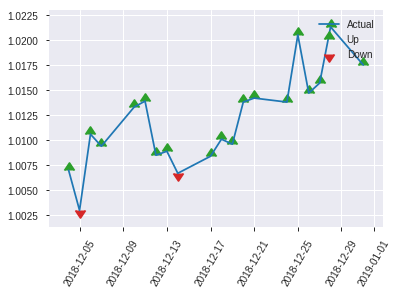


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24776914560808388
RMSE: 0.49776414656751233
LogLoss: 0.6887708601292303
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9338629373763
Residual deviance: 352.65068038616585
AIC: 454.65068038616585
AUC: 0.56536865234375
pr_auc: 0.550856147033081
Gini: 0.1307373046875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37515056488112636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      2    126  0.0156   (2.0/128.0)
Total  11   245  0.4727   (121.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375151     0.675603  244
max f2                       0.313322     0.83442   254
max f0point5                 0.549949     0.603448  83
max accuracy                 0.549949     0.609375  83
max precision                0.552427     0.666667  77
max recall                   0.313322     1         254
max specificity              0.716215     0.992188  0
max absolute_mcc             0.549949     0.232945  83
max min_per_class_accuracy   0.519483     0.523438  125
max mean_per_class_accuracy  0.549949     0.609375  83

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.637689           0         0                  0                0.665692  0                           0.665692            0               0                          -100      -100
    2        0.0234375                   0.629375           2         1                  1                0.633582  0.5                         0.649637            0.0234375       0.0234375                  100       0
    3        0.03125                     0.623062           1         1                  0.5              0.624441  0.5                         0.643338            0.0078125       0.03125                    0         0
    4        0.0429688                   0.620071           0.666667  0.909091           0.333333         0.621605  0.454545                    0.637411            0.0078125       0.0390625                  -33.3333  -9.09091
    5        0.0507812                   0.616314           1         0.923077           0.5              0.617351  0.461538                    0.634325            0.0078125       0.046875                   0         -7.69231
    6        0.101562                    0.595193           1.38462   1.15385            0.692308         0.602937  0.576923                    0.618631            0.0703125       0.117188                   38.4615   15.3846
    7        0.152344                    0.577071           1.53846   1.28205            0.769231         0.585754  0.641026                    0.607672            0.078125        0.195312                   53.8462   28.2051
    8        0.203125                    0.565802           1.23077   1.26923            0.615385         0.571896  0.634615                    0.598728            0.0625          0.257812                   23.0769   26.9231
    9        0.300781                    0.552664           1.44      1.32468            0.72             0.559056  0.662338                    0.585848            0.140625        0.398438                   44        32.4675
    10       0.402344                    0.537955           0.692308  1.16505            0.346154         0.545972  0.582524                    0.575782            0.0703125       0.46875                    -30.7692  16.5049
    11       0.5                         0.515542           0.56      1.04688            0.28             0.526019  0.523438                    0.566063            0.0546875       0.523438                   -44       4.6875
    12       0.601562                    0.492046           0.846154  1.01299            0.423077         0.503263  0.506494                    0.55546             0.0859375       0.609375                   -15.3846  1.2987
    13       0.699219                    0.476422           0.8       0.98324            0.4              0.485095  0.49162                     0.545632            0.078125        0.6875                     -20       -1.67598
    14       0.800781                    0.458199           1.30769   1.02439            0.653846         0.467184  0.512195                    0.535683            0.132812        0.820312                   30.7692   2.43902
    15       0.898438                    0.420429           1.04      1.02609            0.52             0.441109  0.513043                    0.525403            0.101562        0.921875                   4         2.6087
    16       1                           0.305552           0.769231  1                  0.384615         0.36959   0.5                         0.509578            0.078125    

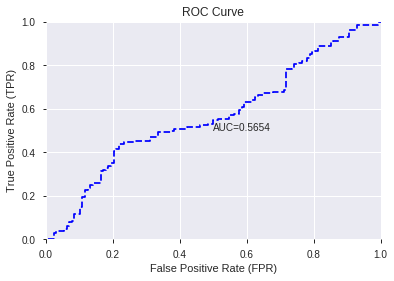

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


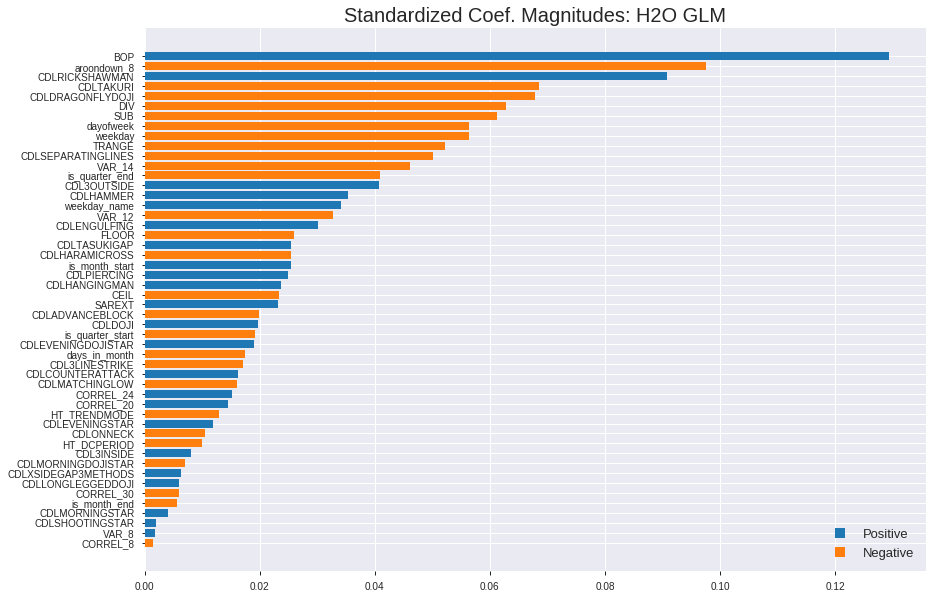

'log_likelihood'
--2019-08-22 12:52:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


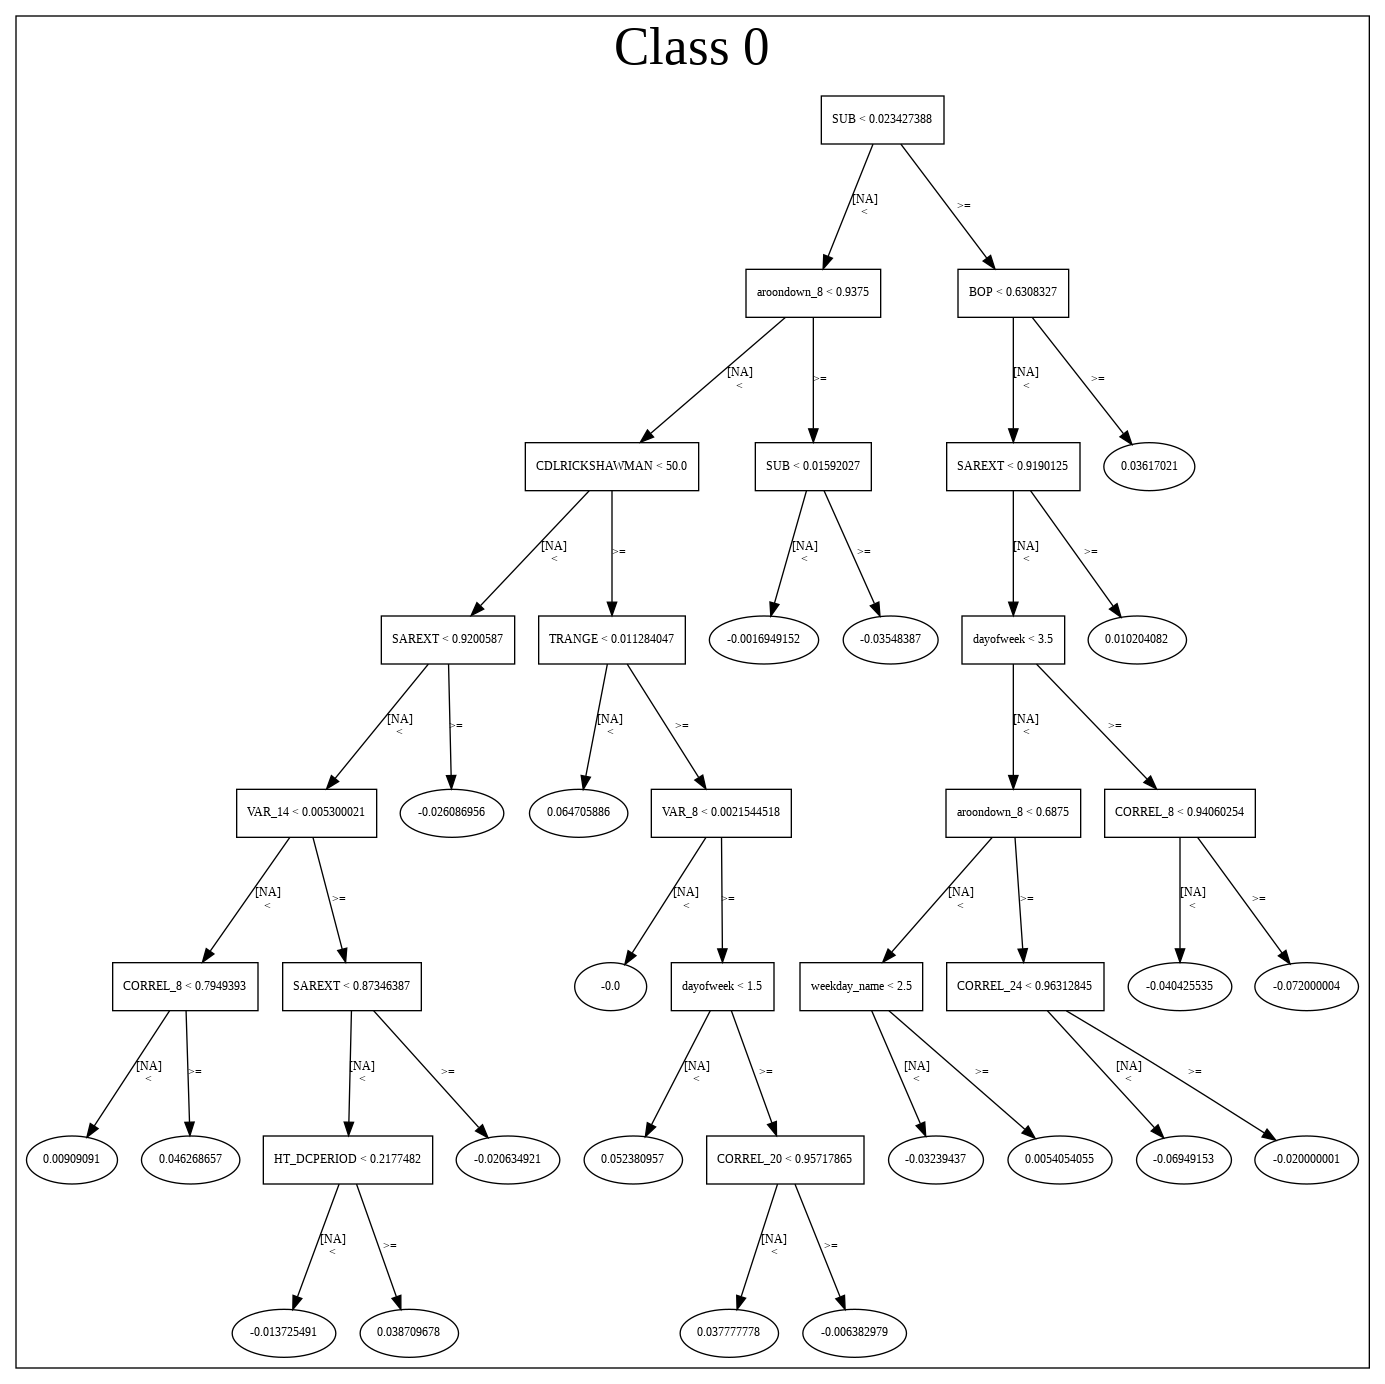

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_125219_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_125219_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'DIV',
 'SUB',
 'dayofweek',
 'weekday',
 'TRANGE',
 'CDLSEPARATINGLINES',
 'VAR_14',
 'is_quarter_end',
 'CDL3OUTSIDE',
 'CDLHAMMER',
 'weekday_name',
 'VAR_12',
 'CDLENGULFING',
 'FLOOR',
 'CDLTASUKIGAP',
 'CDLHARAMICROSS',
 'is_month_start',
 'CDLPIERCING',
 'CDLHANGINGMAN',
 'CEIL',
 'SAREXT',
 'CDLADVANCEBLOCK',
 'CDLDOJI',
 'is_quarter_start',
 'CDLEVENINGDOJISTAR',
 'days_in_month',
 'CDL3LINESTRIKE',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW',
 'CORREL_24',
 'CORREL_20',
 'HT_TRENDMODE',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'HT_DCPERIOD',
 'CDL3INSIDE',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLLONGLEGGEDDOJI',
 'CORREL_30',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'VAR_8',
 'CORREL_8']

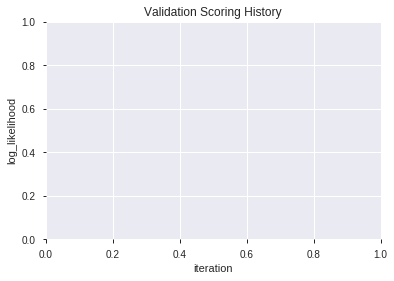

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190822_125235  0.650269  0.666453              0.414062  0.486766  0.236941
1  XGBoost_grid_1_AutoML_20190822_125235_model_7  0.644775  0.669621              0.437500  0.488309  0.238446
2               XGBoost_1_AutoML_20190822_125235  0.644043  0.667419              0.441406  0.487107  0.237273
3  XGBoost_grid_1_AutoML_20190822_125235_model_3  0.637817  0.669343              0.445312  0.488017  0.238160
4  XGBoost_grid_1_AutoML_20190822_125235_model_1  0.626465  0.668681              0.386719  0.487842  0.237990
5  XGBoost_grid_1_AutoML_20190822_125235_model_4  0.625732  0.671948              0.433594  0.489455  0.239566
6               XGBoost_3_AutoML_20190822_125235  0.622559  0.671425              0.394531  0.489202  0.239318
7  XGBoost_grid_1_AutoML_20190822_125235_model_2  0.611389  0.675775              0.414062  0.491232  0.241309
8  XGBoost_grid_1_AutoML_20190822_125235_model_5  0.611145  0.684292              0.421875  0.495439  0.245459
9  XGBoost_grid_1_AutoML_20190822_125235_model_6  0.600037  0.681537              0.421875  0.493966  0.244002

variable  relative_importance  scaled_importance  percentage
0                BOP           480.688293           1.000000    0.100717
1             SAREXT           389.637177           0.810582    0.081640
2        HT_DCPERIOD           384.117065           0.799098    0.080483
3                DIV           369.256012           0.768182    0.077369
4              VAR_8           366.348938           0.762134    0.076760
5        aroondown_8           283.779510           0.590361    0.059460
6          CORREL_20           282.719696           0.588156    0.059238
7           CORREL_8           272.997314           0.567930    0.057200
8          CORREL_30           267.920532           0.557369    0.056137
9                SUB           263.149750           0.547444    0.055137
10            VAR_12           249.057846           0.518128    0.052184
11            TRANGE           224.757324           0.467574    0.047093
12            VAR_14           192.116516           0.399670    0.040254
13         dayofweek           156.091599           0.324725    0.032705
14         CORREL_24           154.138306           0.320662    0.032296
15    CDLRICKSHAWMAN            87.775604           0.182604    0.018391
16     days_in_month            77.088669           0.160371    0.016152
17  CDLDRAGONFLYDOJI            63.369896           0.131832    0.013278
18           weekday            58.026237           0.120715    0.012158
19      HT_TRENDMODE            54.469746           0.113316    0.011413
20      weekday_name            47.755917           0.099349    0.010006
21         CDLTAKURI            29.470423           0.061309    0.006175
22              CEIL            12.184917           0.025349    0.002553
23             FLOOR             5.726425           0.011913    0.001200

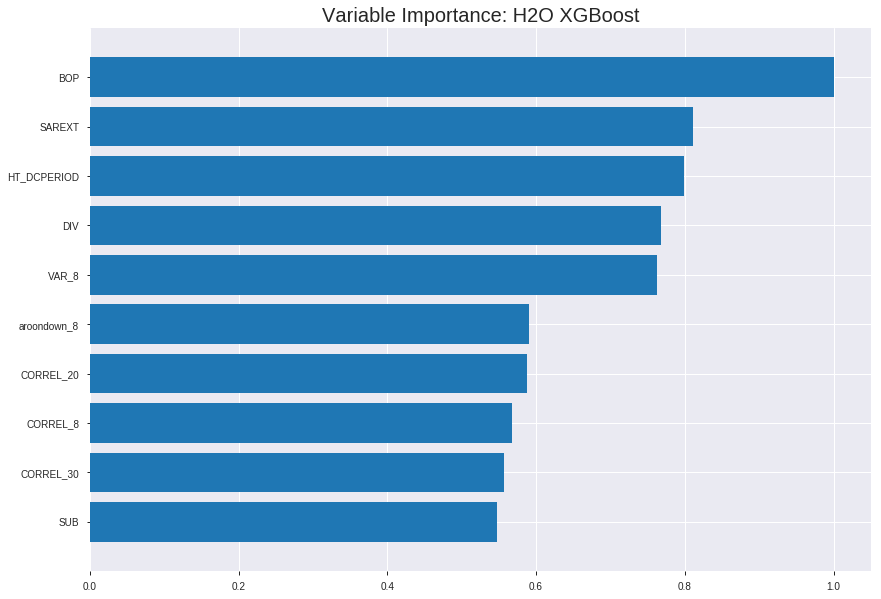

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190822_125235


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18582674454945375
RMSE: 0.43107626303179086
LogLoss: 0.5585044296851334
Mean Per-Class Error: 0.22574282040722027
AUC: 0.8527932357638645
pr_auc: 0.8454496995381858
Gini: 0.7055864715277289
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4814271827538808: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      644  260  0.2876   (260.0/904.0)
1      148  733  0.168    (148.0/881.0)
Total  792  993  0.2286   (408.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481427     0.782284  206
max f2                       0.36378      0.861685  295
max f0point5                 0.546128     0.783429  155
max accuracy                 0.505495     0.77423   188
max precision                0.814384     1         0
max recall                   0.242252     1         367
max specificity              0.814384     1         0
max absolute_mcc             0.491529     0.548689  199
max min_per_class_accuracy   0.506732     0.772985  187
max mean_per_class_accuracy  0.505495     0.774257  188

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.75121            2.02611    2.02611            1                0.771371  1                           0.771371            0.0204313       0.0204313                  102.611   102.611
    2        0.0201681                   0.734174           1.91355    1.96983            0.944444         0.742189  0.972222                    0.75678             0.0192963       0.0397276                  91.3545   96.9826
    3        0.0302521                   0.722057           2.02611    1.98859            1                0.727945  0.981481                    0.747168            0.0204313       0.0601589                  102.611   98.8586
    4        0.0403361                   0.713961           1.91355    1.96983            0.944444         0.71708   0.972222                    0.739646            0.0192963       0.0794552                  91.3545   96.9826
    5        0.0504202                   0.701942           1.91355    1.95857            0.944444         0.708905  0.966667                    0.733498            0.0192963       0.0987514                  91.3545   95.857
    6        0.10028                     0.668973           1.86675    1.91292            0.921348         0.685421  0.944134                    0.709594            0.093076        0.191827                   86.675    91.2916
    7        0.15014                     0.645272           1.79845    1.8749             0.88764          0.655778  0.925373                    0.691722            0.0896708       0.281498                   79.8454   87.4905
    8        0.2                         0.622441           1.84398    1.8672             0.910112         0.633788  0.921569                    0.677279            0.091941        0.373439                   84.3985   86.7196
    9        0.30028                     0.57922            1.6073     1.7804             0.793296         0.59941   0.878731                    0.651274            0.16118         0.53462                    60.7303   78.0403
    10       0.4                         0.542026           1.26347    1.65153            0.623596         0.56056   0.815126                    0.628659            0.125993        0.660613                   26.3471   65.1532
    11       0.50028                     0.504688           1.16586    1.55418            0.575419         0.523392  0.767077                    0.607559            0.116913        0.777526                   16.586    55.418
    12       0.6                         0.465361           0.819549   1.43208            0.404494         0.484971  0.706816                    0.587185            0.0817253       0.859251                   -18.0451  43.2085
    13       0.69972                     0.419293           0.569131   1.3091             0.280899         0.443477  0.646117                    0.566704            0.0567537       0.916005                   -43.0869  30.9102
    14       0.8                         0.360575           0.509356   1.20885            0.251397         0.389934  0.596639                    0.544546            0.0510783       0.967083                   -49.0644  20.8854
    15       0.89972                     0.289901           0.250418   1.10263            0.123596         0.330179  0.544209                    0.520787            0.0249716       0.992054                   -74.9582  10.2626
    16       1                           0.153464           0.0792332  1                  0.0391061        0.244673  0.493557                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2383374689610233
RMSE: 0.4881981861508944
LogLoss: 0.6695263215699087
Mean Per-Class Error: 0.37769330214232943
AUC: 0.6319333292292538
pr_auc: 0.5765910123710322
Gini: 0.26386665845850765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39201316237449646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      48   214  0.8168   (214.0/262.0)
1      14   234  0.0565   (14.0/248.0)
Total  62   448  0.4471   (228.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392013     0.672414  341
max f2                       0.271479     0.828877  393
max f0point5                 0.532335     0.611702  204
max accuracy                 0.546999     0.621569  188
max precision                0.823853     1         0
max recall                   0.271479     1         393
max specificity              0.823853     1         0
max absolute_mcc             0.532335     0.244792  204
max min_per_class_accuracy   0.543096     0.618321  194
max mean_per_class_accuracy  0.532335     0.622307  204

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 53.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.735959           1.02823   1.02823            0.5              0.769608  0.5                         0.769608            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.726581           1.23387   1.1217             0.6              0.729332  0.545455                    0.751301            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.716804           0.822581  1.02823            0.4              0.719916  0.5                         0.741493            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.710739           2.05645   1.27304            1                0.713363  0.619048                    0.734795            0.0201613       0.0524194                  105.645   27.3041
    5        0.0509804                   0.701581           0.822581  1.18641            0.4              0.705199  0.576923                    0.729104            0.00806452      0.0604839                  -17.7419  18.6414
    6        0.1                         0.660521           1.39839   1.29032            0.68             0.681788  0.627451                    0.70591             0.0685484       0.129032                   39.8387   29.0323
    7        0.15098                     0.643709           1.18641   1.25524            0.576923         0.650876  0.61039                     0.687327            0.0604839       0.189516                   18.6414   25.5237
    8        0.2                         0.630754           1.15161   1.22984            0.56             0.636454  0.598039                    0.674858            0.0564516       0.245968                   15.1613   22.9839
    9        0.3                         0.600302           1.04839   1.16935            0.509804         0.615131  0.568627                    0.654949            0.104839        0.350806                   4.83871   16.9355
    10       0.4                         0.574997           1.49194   1.25               0.72549          0.58722   0.607843                    0.638017            0.149194        0.5                        49.1935   25
    11       0.5                         0.541266           1.20968   1.24194            0.588235         0.558265  0.603922                    0.622066            0.120968        0.620968                   20.9677   24.1935
    12       0.6                         0.507188           0.846774  1.17608            0.411765         0.523945  0.571895                    0.605713            0.0846774       0.705645                   -15.3226  17.6075
    13       0.7                         0.473315           0.887097  1.13479            0.431373         0.490086  0.551821                    0.589195            0.0887097       0.794355                   -11.2903  13.4793
    14       0.8                         0.442339           0.766129  1.08871            0.372549         0.457289  0.529412                    0.572707            0.0766129       0.870968                   -23.3871  8.87097
    15       0.9                         0.379921           0.846774  1.06183            0.411765         0.41345   0.51634                     0.555011            0.0846774       0.955645                   -15.3226  6.1828
    16       1                           0.210483           0.443548  1                  0.215686         0.321258  0.486275                    0.531636            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:52:38  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.506443                         0.5                0.693147              0.5               0                    1                  0.513725
    2019-08-22 12:52:38  0.061 sec   5                  0.487667         0.668714            0.744824        0.733518           2.02611          0.354622                         0.495078           0.683328              0.61996           0.572037             1.02823            0.421569
    2019-08-22 12:52:38  0.112 sec   10                 0.478832         0.651396            0.767456        0.762081           2.02611          0.328852                         0.492396           0.677946              0.623984          0.584583             1.37097            0.458824
    2019-08-22 12:52:38  0.172 sec   15                 0.469896         0.63395             0.78595         0.7754             1.91355          0.315966                         0.490802           0.674714              0.623461          0.573384             1.37097            0.445098
    2019-08-22 12:52:38  0.227 sec   20                 0.462622         0.619758            0.799557        0.786716           1.91355          0.309244                         0.48968            0.672408              0.628571          0.576307             1.37097            0.441176
    2019-08-22 12:52:38  0.287 sec   25                 0.456066         0.606975            0.810938        0.802794           2.02611          0.278431                         0.488983           0.670936              0.633011          0.586779             1.37097            0.45098
    2019-08-22 12:52:38  0.365 sec   30                 0.450194         0.595609            0.822956        0.813201           2.02611          0.268347                         0.488676           0.670337              0.634588          0.588947             1.37097            0.447059
    2019-08-22 12:52:38  0.423 sec   35                 0.44536          0.586075            0.8257          0.81706            2.02611          0.258263                         0.487483           0.667958              0.639844          0.590273             1.37097            0.437255
    2019-08-22 12:52:38  0.487 sec   40                 0.440499         0.576544            0.832572        0.821512           1.91355          0.248739                         0.48796            0.66906               0.635104          0.580534             0.685484           0.439216
    2019-08-22 12:52:38  0.550 sec   45                 0.435746         0.567357            0.842623        0.834649           2.02611          0.239776                         0.488396           0.66996               0.631803          0.575304             1.02823            0.443137
    2019-08-22 12:52:38  0.620 sec   50                 0.431076         0.558504            0.852793        0.84545            2.02611          0.228571                         0.488198           0.669526              0.631933          0.576591             1.02823            0.447059

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
BOP           480.68829345703125     1.0                   0.10071740578413364
SAREXT        389.6371765136719      0.8105817882758602    0.08163969489100852
HT_DCPERIOD   384.1170654296875      0.7990980239339316    0.08048307993785313
DIV           369.2560119628906      0.7681818279934842    0.0773692808860173
VAR_8         366.34893798828125     0.7621340959929768    0.0767601690080485
---           ---                    ---                   ---
HT_TRENDMODE  54.46974563598633      0.11331614765204466   0.011412908424965784
weekday_name  47.755916595458984     0.09934903188926503   0.01000617675905194
CDLTAKURI     29.470422744750977     0.061308800621717945  0.006174863350356111
CEIL          12.184917449951172     0.02534889577259984   0.002553075021708648
FLOOR         5.726424694061279      0.011912968907309503  0.0011998433235312583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.64453125)

('F1', 0.6954022988505748)

('auc', 0.6502685546875)

('logloss', 0.6664528015894207)

('mean_per_class_error', 0.35546875)

('rmse', 0.4867655618859564)

('mse', 0.23694071223815083)

xgboost prediction progress: |████████████████████████████████████████████| 100%


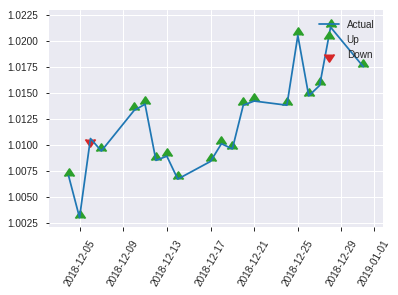


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23694071223815083
RMSE: 0.4867655618859564
LogLoss: 0.6664528015894207
Mean Per-Class Error: 0.35546875
AUC: 0.6502685546875
pr_auc: 0.6140243566547097
Gini: 0.300537109375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4278513789176941: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      29   99   0.7734   (99.0/128.0)
1      7    121  0.0547   (7.0/128.0)
Total  36   220  0.4141   (106.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427851     0.695402  219
max f2                       0.323855     0.837696  251
max f0point5                 0.578767     0.645425  120
max accuracy                 0.578767     0.644531  120
max precision                0.776521     1         0
max recall                   0.323855     1         251
max specificity              0.776521     1         0
max absolute_mcc             0.578767     0.289496  120
max min_per_class_accuracy   0.569595     0.640625  126
max mean_per_class_accuracy  0.578767     0.644531  120

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 55.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.738451           1.33333   1.33333            0.666667         0.759207  0.666667                    0.759207            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.713291           0.666667  1                  0.333333         0.724696  0.5                         0.741951            0.0078125       0.0234375                  -33.3333  0
    3        0.03125                     0.704611           2         1.25               1                0.705687  0.625                       0.732885            0.015625        0.0390625                  100       25
    4        0.0429688                   0.700494           1.33333   1.27273            0.666667         0.702428  0.636364                    0.724579            0.015625        0.0546875                  33.3333   27.2727
    5        0.0507812                   0.696449           1         1.23077            0.5              0.699326  0.615385                    0.720694            0.0078125       0.0625                     0         23.0769
    6        0.101562                    0.680474           1.53846   1.38462            0.769231         0.687148  0.692308                    0.703921            0.078125        0.140625                   53.8462   38.4615
    7        0.152344                    0.663974           1.53846   1.4359             0.769231         0.671725  0.717949                    0.693189            0.078125        0.21875                    53.8462   43.5897
    8        0.203125                    0.650877           1.07692   1.34615            0.538462         0.656425  0.673077                    0.683998            0.0546875       0.273438                   7.69231   34.6154
    9        0.300781                    0.626037           1.12      1.27273            0.56             0.638998  0.636364                    0.669387            0.109375        0.382812                   12        27.2727
    10       0.402344                    0.598493           1.53846   1.33981            0.769231         0.612202  0.669903                    0.654952            0.15625         0.539062                   53.8462   33.9806
    11       0.5                         0.56949            1.04      1.28125            0.52             0.584044  0.640625                    0.641103            0.101562        0.640625                   4         28.125
    12       0.601562                    0.537684           0.615385  1.16883            0.307692         0.554098  0.584416                    0.626414            0.0625          0.703125                   -38.4615  16.8831
    13       0.699219                    0.506008           0.72      1.10615            0.36             0.527022  0.553073                    0.612532            0.0703125       0.773438                   -28       10.6145
    14       0.800781                    0.460051           0.923077  1.08293            0.461538         0.484011  0.541463                    0.596232            0.09375         0.867188                   -7.69231  8.29268
    15       0.898438                    0.403133           0.88      1.06087            0.44             0.431158  0.530435                    0.578289            0.0859375       0.953125                   -12       6.08696
    16       1                           0.243701           0.461538  1                  0.230769         0.347478  0.5                         0.554847            0.046875 

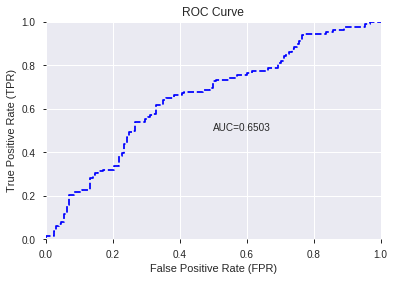

This function is available for GLM models only


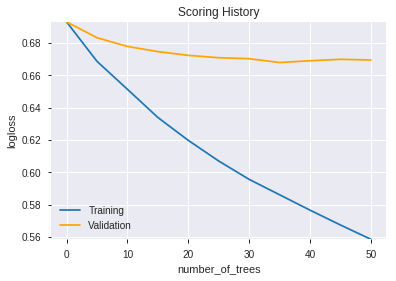

--2019-08-22 12:52:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


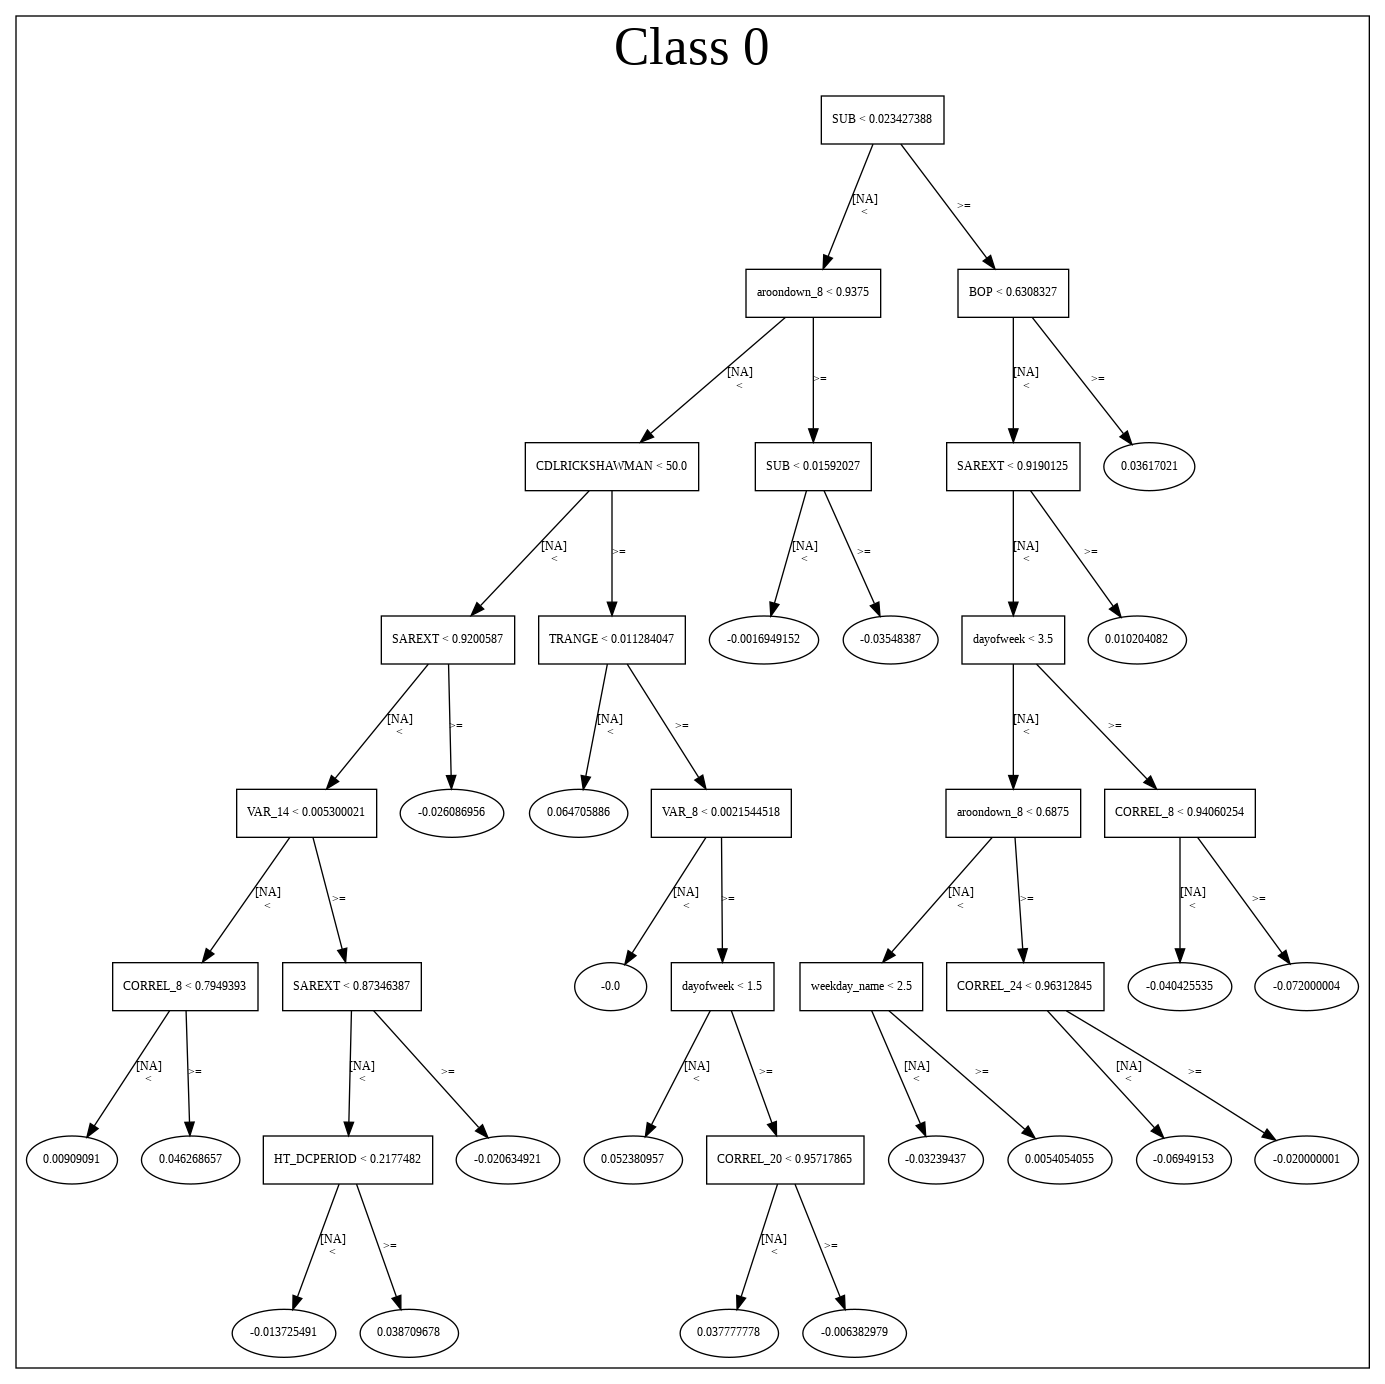

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190822_125235',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190822_125235',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_a5f6',
   'type

['BOP',
 'SAREXT',
 'HT_DCPERIOD',
 'DIV',
 'VAR_8',
 'aroondown_8',
 'CORREL_20',
 'CORREL_8',
 'CORREL_30',
 'SUB',
 'VAR_12',
 'TRANGE',
 'VAR_14',
 'dayofweek',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'weekday',
 'HT_TRENDMODE',
 'weekday_name',
 'CDLTAKURI',
 'CEIL',
 'FLOOR']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [887 919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


10

['dayofweek',
 'weekday',
 'BOP',
 'aroondown_8',
 'AROONOSC_8',
 'MINUS_DM_8',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125307_model_3  0.587036  0.701017              0.464844  0.501703  0.251705
1  DeepLearning_grid_1_AutoML_20190822_125307_model_7  0.582886  0.699355              0.460938  0.502583  0.252589
2  DeepLearning_grid_1_AutoML_20190822_125307_model_6  0.582031  0.693332              0.484375  0.499326  0.249327
3               DeepLearning_1_AutoML_20190822_125307  0.572083  0.698972              0.476562  0.502352  0.252357
4  DeepLearning_grid_1_AutoML_20190822_125307_model_5  0.564270  0.691477              0.449219  0.499116  0.249117
5  DeepLearning_grid_1_AutoML_20190822_125307_model_4  0.558289  0.699205              0.464844  0.503009  0.253018
6  DeepLearning_grid_1_AutoML_20190822_125307_model_2  0.542419  0.729098              0.476562  0.515318  0.265553
7  DeepLearning_grid_1_AutoML_20190822_125307_model_8  0.538757  0.692066              0.425781  0.499703  0.249703
8  DeepLearning_grid_1_AutoML_20190822_125307_model_1  0.437805  0.760263              0.484375  0.529712  0.280595

variable  relative_importance  scaled_importance  percentage
0               SUB             1.000000           1.000000    0.205427
1               BOP             0.679625           0.679625    0.139614
2        MINUS_DM_8             0.526653           0.526653    0.108189
3       aroondown_8             0.504918           0.504918    0.103724
4    CDLRICKSHAWMAN             0.461725           0.461725    0.094851
5        AROONOSC_8             0.360282           0.360282    0.074012
6           weekday             0.357296           0.357296    0.073398
7         dayofweek             0.352970           0.352970    0.072510
8  CDLDRAGONFLYDOJI             0.324518           0.324518    0.066665
9         CDLTAKURI             0.299916           0.299916    0.061611

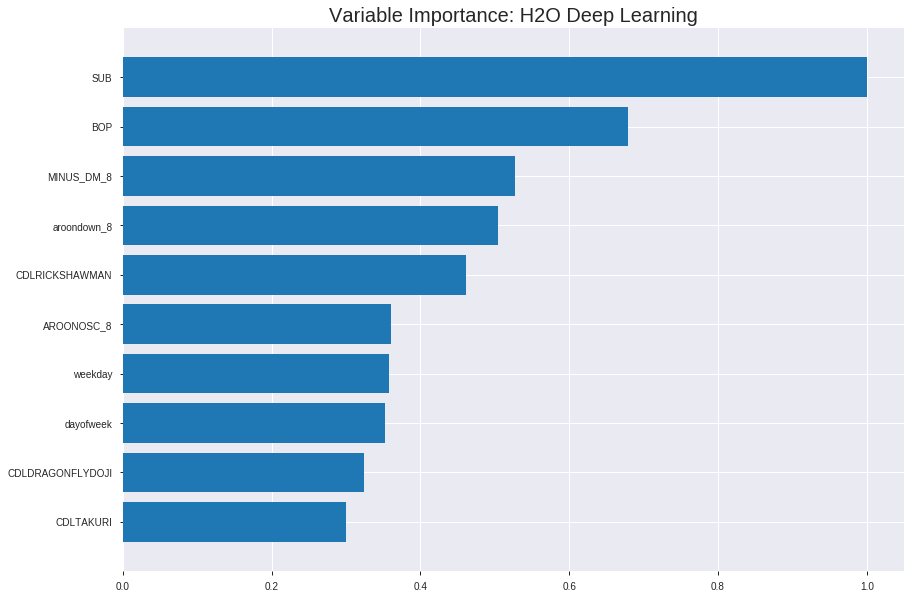

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125307_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2235450219678693
RMSE: 0.4728054800527055
LogLoss: 0.6366481442482068
Mean Per-Class Error: 0.35817981376754093
AUC: 0.6851300312396412
pr_auc: 0.641708916539393
Gini: 0.37026006247928245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4116596130680845: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      342  562   0.6217   (562.0/904.0)
1      110  771   0.1249   (110.0/881.0)
Total  452  1333  0.3765   (672.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41166      0.696477  252
max f2                       0.181083     0.836852  352
max f0point5                 0.555502     0.638068  165
max accuracy                 0.555502     0.642017  165
max precision                0.886218     0.8       4
max recall                   0.0692295    1         382
max specificity              0.948794     0.998894  0
max absolute_mcc             0.41166      0.291406  252
max min_per_class_accuracy   0.536548     0.637911  177
max mean_per_class_accuracy  0.542407     0.64182   173

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 51.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.836953           1.4633    1.4633             0.722222         0.868358  0.722222                    0.868358            0.014756        0.014756                   46.3299   46.3299
    2        0.0201681                   0.818398           1.57586   1.51958            0.777778         0.825283  0.75                        0.846821            0.015891        0.030647                   57.5861   51.958
    3        0.0302521                   0.804728           1.4633    1.50082            0.722222         0.811191  0.740741                    0.834944            0.014756        0.045403                   46.3299   50.082
    4        0.0403361                   0.792416           1.57586   1.51958            0.777778         0.79907   0.75                        0.825976            0.015891        0.061294                   57.5861   51.958
    5        0.0504202                   0.784423           1.4633    1.50832            0.722222         0.788864  0.744444                    0.818554            0.014756        0.0760499                  46.3299   50.8324
    6        0.10028                     0.734995           1.34315   1.4262             0.662921         0.757018  0.703911                    0.787958            0.0669694       0.143019                   34.3149   42.6198
    7        0.15014                     0.700104           1.27485   1.37594            0.629213         0.717211  0.679104                    0.764463            0.0635641       0.206583                   27.4854   37.5938
    8        0.2                         0.671841           1.34315   1.36776            0.662921         0.686227  0.67507                     0.744959            0.0669694       0.273553                   34.3149   36.7764
    9        0.30028                     0.623004           1.23377   1.32302            0.608939         0.645857  0.652985                    0.711864            0.123723        0.397276                   23.3774   32.3017
    10       0.4                         0.578008           1.309     1.31952            0.646067         0.60049   0.651261                    0.684098            0.130533        0.527809                   30.9002   31.9523
    11       0.50028                     0.535151           1.12058   1.27965            0.553073         0.556809  0.631579                    0.658583            0.112372        0.640182                   12.0584   27.9646
    12       0.6                         0.493863           0.978905  1.22966            0.483146         0.514871  0.606909                    0.634698            0.0976163       0.737798                   -2.10945  22.9663
    13       0.69972                     0.442897           0.944758  1.18906            0.466292         0.469623  0.586869                    0.611173            0.0942111       0.832009                   -5.52424  18.906
    14       0.8                         0.369238           0.758375  1.13507            0.374302         0.407801  0.560224                    0.58568             0.0760499       0.908059                   -24.1625  13.5074
    15       0.89972                     0.272041           0.614662  1.07739            0.303371         0.324896  0.531756                    0.556776            0.061294        0.969353                   -38.5338  7.73942
    16       1                           5.69775e-20        0.305614  1                  0.150838         0.153071  0.493557                    0.516293            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2501265406904989
RMSE: 0.5001265246820037
LogLoss: 0.6991323388006232
Mean Per-Class Error: 0.40422617581876386
AUC: 0.6028610563900517
pr_auc: 0.5368848581857623
Gini: 0.20572211278010344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3914976259203769: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   216  0.8244   (216.0/262.0)
1      8    240  0.0323   (8.0/248.0)
Total  54   456  0.4392   (224.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391498     0.681818  348
max f2                       0.335439     0.831636  371
max f0point5                 0.460329     0.588889  290
max accuracy                 0.557721     0.596078  189
max precision                0.834309     0.6       8
max recall                   0.186969     1         396
max specificity              0.911323     0.996183  0
max absolute_mcc             0.391498     0.232802  348
max min_per_class_accuracy   0.555815     0.58871   191
max mean_per_class_accuracy  0.557721     0.595774  189

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 56.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.844882           1.02823   1.02823            0.5              0.873827  0.5                         0.873827            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.832983           1.23387   1.1217             0.6              0.834964  0.545455                    0.856162            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.819708           0.41129   0.899698           0.2              0.825046  0.4375                      0.846438            0.00403226      0.0282258                  -58.871   -10.0302
    4        0.0411765                   0.809249           0.822581  0.881336           0.4              0.813773  0.428571                    0.838661            0.00806452      0.0362903                  -17.7419  -11.8664
    5        0.0509804                   0.801376           0.41129   0.790943           0.2              0.804702  0.384615                    0.83213             0.00403226      0.0403226                  -58.871   -20.9057
    6        0.1                         0.749288           1.15161   0.967742           0.56             0.776643  0.470588                    0.804931            0.0564516       0.0967742                  15.1613   -3.22581
    7        0.15098                     0.723598           1.3446    1.09499            0.653846         0.73495   0.532468                    0.781301            0.0685484       0.165323                   34.4603   9.49937
    8        0.2                         0.697726           1.23387   1.12903            0.6              0.710625  0.54902                     0.763978            0.0604839       0.225806                   23.3871   12.9032
    9        0.3                         0.652768           1.20968   1.15591            0.588235         0.674163  0.562092                    0.73404             0.120968        0.346774                   20.9677   15.5914
    10       0.4                         0.59619            1.16935   1.15927            0.568627         0.62024   0.563725                    0.70559             0.116935        0.46371                    16.9355   15.9274
    11       0.5                         0.554138           1.29032   1.18548            0.627451         0.569497  0.576471                    0.678371            0.129032        0.592742                   29.0323   18.5484
    12       0.6                         0.51993            0.806452  1.12231            0.392157         0.536874  0.545752                    0.654789            0.0806452       0.673387                   -19.3548  12.2312
    13       0.7                         0.486012           0.967742  1.10023            0.470588         0.502735  0.535014                    0.633067            0.0967742       0.770161                   -3.22581  10.023
    14       0.8                         0.448468           1.12903   1.10383            0.54902          0.466125  0.536765                    0.612199            0.112903        0.883065                   12.9032   10.3831
    15       0.9                         0.389493           0.846774  1.07527            0.411765         0.418354  0.522876                    0.590661            0.0846774       0.967742                   -15.3226  7.52688
    16       1                           0.113635           0.322581  1                  0.156863         0.302054  0.486275                    0.5618        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:54:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:54:12  1 min  3.458 sec  12916 obs/sec     10        1             17850      0.495593         0.687192            0.017389       0.622274        0.589214           1.4633           0.434734                         0.507782           0.714328              -0.0321487       0.594358          0.540817             1.02823            0.44902
    2019-08-22 12:54:17  1 min  8.578 sec  16596 obs/sec     60        6             107100     0.480781         0.652882            0.0752454      0.657471        0.621637           1.68842          0.389916                         0.504856           0.709257              -0.0202885       0.591465          0.528658             1.37097            0.458824
    2019-08-22 12:54:22  1 min 13.616 sec  20273 obs/sec     130       13            232050     0.472805         0.636648            0.105671       0.68513         0.641709           1.4633           0.376471                         0.500127           0.699132              -0.00126067      0.602861          0.536885             1.02823            0.439216
    2019-08-22 12:54:27  1 min 18.725 sec  22719 obs/sec     210       21            374850     0.471042         0.633696            0.112331       0.696312        0.65503            1.80098          0.385994                         0.510909           0.73569               -0.0448994       0.592603          0.529504             0.685484           0.427451
    2019-08-22 12:54:33  1 min 24.217 sec  24484 obs/sec     300       30            535500     0.462753         0.61523             0.143298       0.720305        0.684985           1.68842          0.364706                         0.507026           0.719656              -0.0290783       0.583785          0.521078             0.685484           0.443137
    2019-08-22 12:54:38  1 min 29.454 sec  25724 obs/sec     390       39            696150     0.465162         0.619838            0.134352       0.710176        0.676437           1.80098          0.366387                         0.514216           0.740168              -0.0584702       0.562454          0.513737             0.685484           0.447059
    2019-08-22 12:54:38  1 min 29.502 sec  25719 obs/sec     390       39            696150     0.472805         0.636648            0.105671       0.68513         0.641709           1.4633           0.376471                         0.500127           0.699132              -0.00126067      0.602861          0.536885             1.02823            0.439216

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
SUB               1                      1                    0.205427
BOP               0.679625               0.679625             0.139614
MINUS_DM_8        0.526653               0.526653             0.108189
aroondown_8       0.504918               0.504918             0.103724
CDLRICKSHAWMAN    0.461725               0.461725             0.0948509
AROONOSC_8        0.360282               0.360282             0.0740117
weekday           0.357296               0.357296             0.0733984
dayofweek         0.35297                0.35297              0.0725096
CDLDRAGONFLYDOJI  0.324518               0.324518             0.0666648
CDLTAKURI         0.299916               0.299916             0.061611

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58203125)

('F1', 0.6809651474530831)

('auc', 0.5870361328125)

('logloss', 0.701017337635351)

('mean_per_class_error', 0.41796875)

('rmse', 0.5017025836037364)

('mse', 0.2517054823946641)

deeplearning prediction progress: |███████████████████████████████████████| 100%


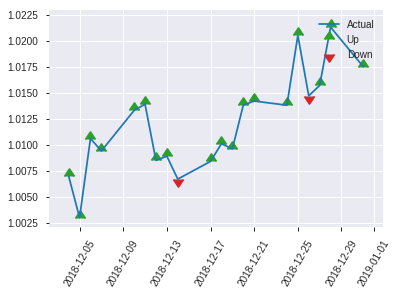


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2517054823946641
RMSE: 0.5017025836037364
LogLoss: 0.701017337635351
Mean Per-Class Error: 0.41796875
AUC: 0.5870361328125
pr_auc: 0.55507687230068
Gini: 0.174072265625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34778683833164764: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   118  0.9219   (118.0/128.0)
1      1    127  0.0078   (1.0/128.0)
Total  11   245  0.4648   (119.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347787     0.680965  244
max f2                       0.314467     0.839895  249
max f0point5                 0.451479     0.584016  211
max accuracy                 0.648544     0.582031  84
max precision                0.697708     0.666667  47
max recall                   0.314467     1         249
max specificity              0.91936      0.992188  0
max absolute_mcc             0.648544     0.174185  84
max min_per_class_accuracy   0.574961     0.539062  126
max mean_per_class_accuracy  0.648544     0.582031  84

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 57.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.826575           0         0                  0                0.866562  0                           0.866562            0               0                          -100      -100
    2        0.0234375                   0.814158           1.33333   0.666667           0.666667         0.818506  0.333333                    0.842534            0.015625        0.015625                   33.3333   -33.3333
    3        0.03125                     0.80625            2         1                  1                0.807788  0.5                         0.833847            0.015625        0.03125                    100       0
    4        0.0429688                   0.795609           0.666667  0.909091           0.333333         0.802175  0.454545                    0.82521             0.0078125       0.0390625                  -33.3333  -9.09091
    5        0.0507812                   0.790443           1         0.923077           0.5              0.79257   0.461538                    0.820188            0.0078125       0.046875                   0         -7.69231
    6        0.101562                    0.743199           1.38462   1.15385            0.692308         0.759036  0.576923                    0.789612            0.0703125       0.117188                   38.4615   15.3846
    7        0.152344                    0.716082           1.23077   1.17949            0.615385         0.727884  0.589744                    0.769036            0.0625          0.179688                   23.0769   17.9487
    8        0.203125                    0.690205           1.38462   1.23077            0.692308         0.70003   0.615385                    0.751785            0.0703125       0.25                       38.4615   23.0769
    9        0.300781                    0.654202           1.2       1.22078            0.6              0.672865  0.61039                     0.726161            0.117188        0.367188                   20        22.0779
    10       0.402344                    0.605857           1         1.16505            0.5              0.633662  0.582524                    0.702812            0.101562        0.46875                    0         16.5049
    11       0.5                         0.572669           0.72      1.07812            0.36             0.591486  0.539062                    0.681069            0.0703125       0.539062                   -28       7.8125
    12       0.601562                    0.53295            1.07692   1.07792            0.538462         0.554471  0.538961                    0.659695            0.109375        0.648438                   7.69231   7.79221
    13       0.699219                    0.500183           0.88      1.05028            0.44             0.515219  0.52514                     0.639517            0.0859375       0.734375                   -12       5.02793
    14       0.800781                    0.468078           1.23077   1.07317            0.615385         0.485603  0.536585                    0.619996            0.125           0.859375                   23.0769   7.31707
    15       0.898438                    0.412428           0.88      1.05217            0.44             0.437431  0.526087                    0.600152            0.0859375       0.945312                   -12       5.21739
    16       1                           0.10017            0.538462  1                  0.269231         0.340646  0.5                         0.573796            0.05

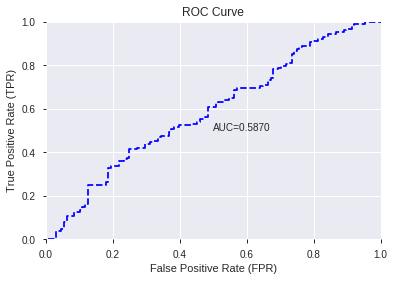

This function is available for GLM models only


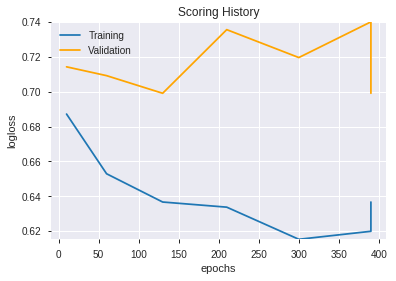

--2019-08-22 13:00:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


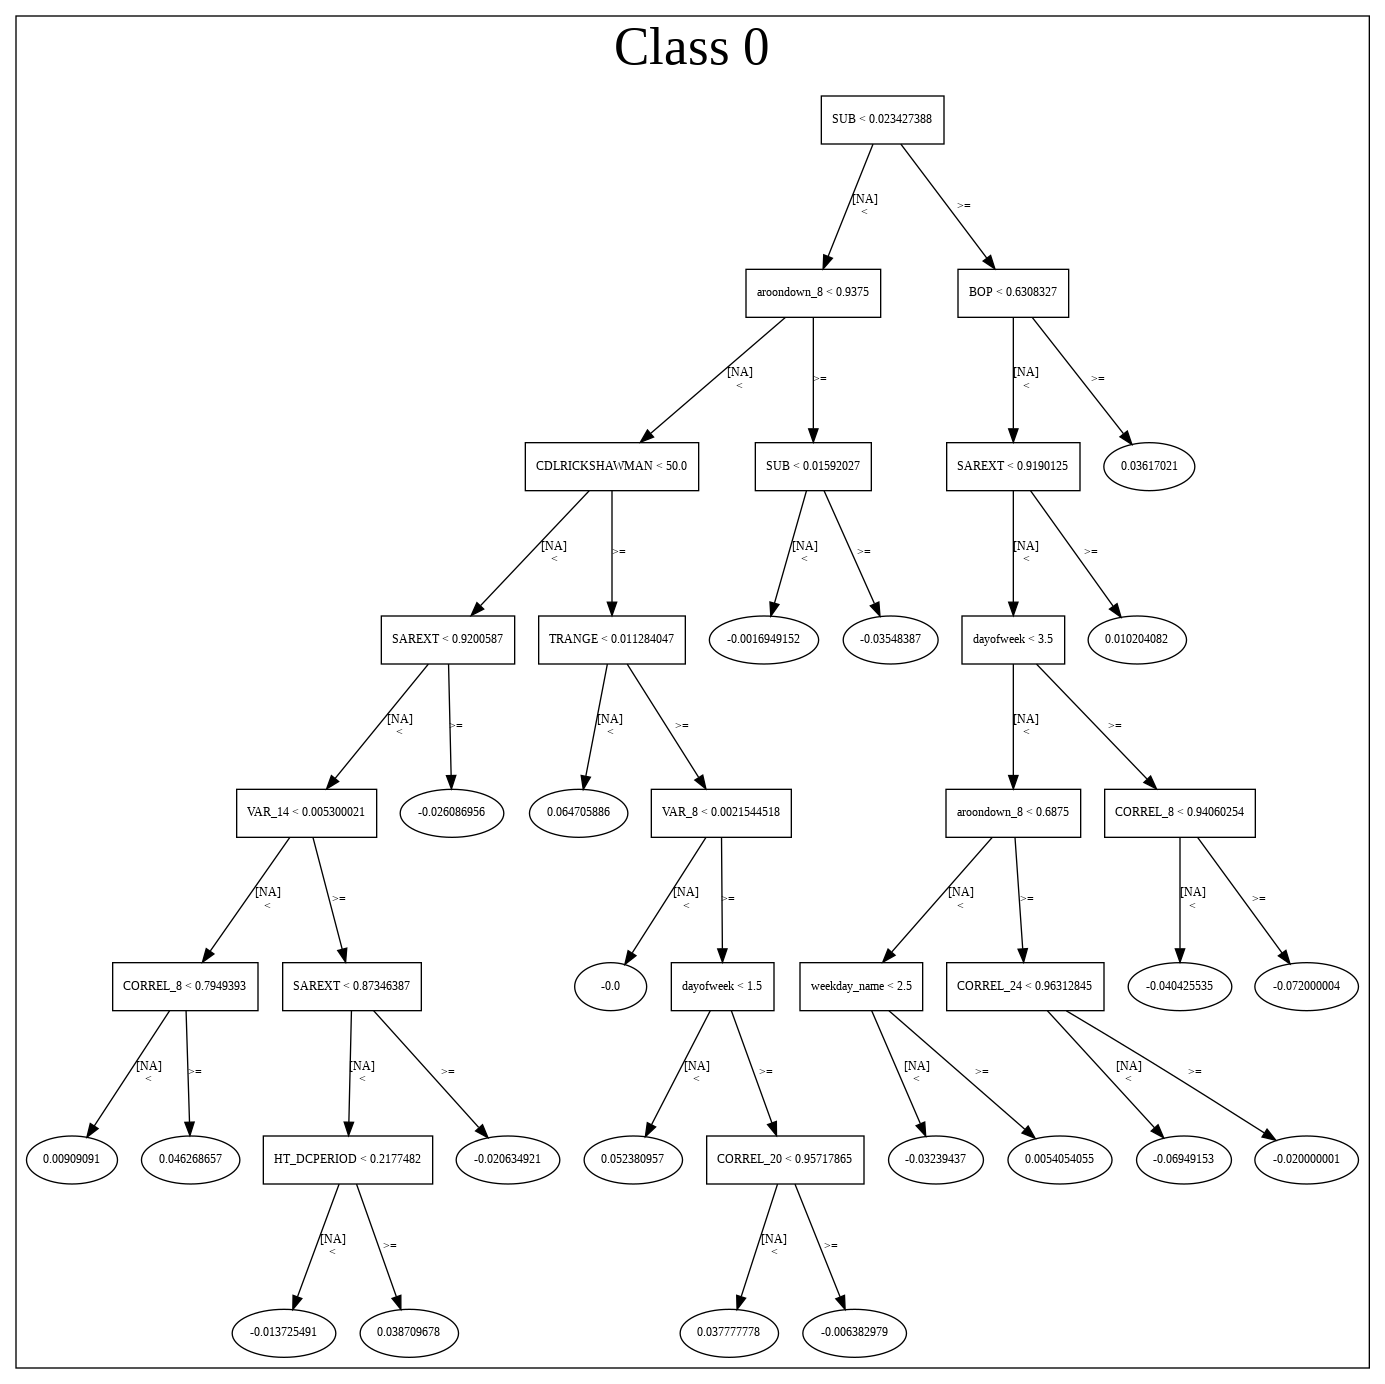

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125307_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125307_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SUB',
 'BOP',
 'MINUS_DM_8',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'AROONOSC_8',
 'weekday',
 'dayofweek',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_130018_model_1  0.563904  0.693961              0.488281  0.500207  0.250207

variable  relative_importance  scaled_importance  percentage
0               SUB             0.508875           1.000000    0.326023
1               BOP             0.282924           0.555979    0.181262
2         CDLTAKURI             0.140521           0.276141    0.090028
3       aroondown_8             0.135703           0.266672    0.086941
4    CDLRICKSHAWMAN             0.134571           0.264448    0.086216
5         dayofweek             0.088940           0.174778    0.056982
6           weekday             0.088231           0.173384    0.056527
7        AROONOSC_8             0.085285           0.167596    0.054640
8  CDLDRAGONFLYDOJI             0.058247           0.114462    0.037317
9        MINUS_DM_8             0.037558           0.073807    0.024063

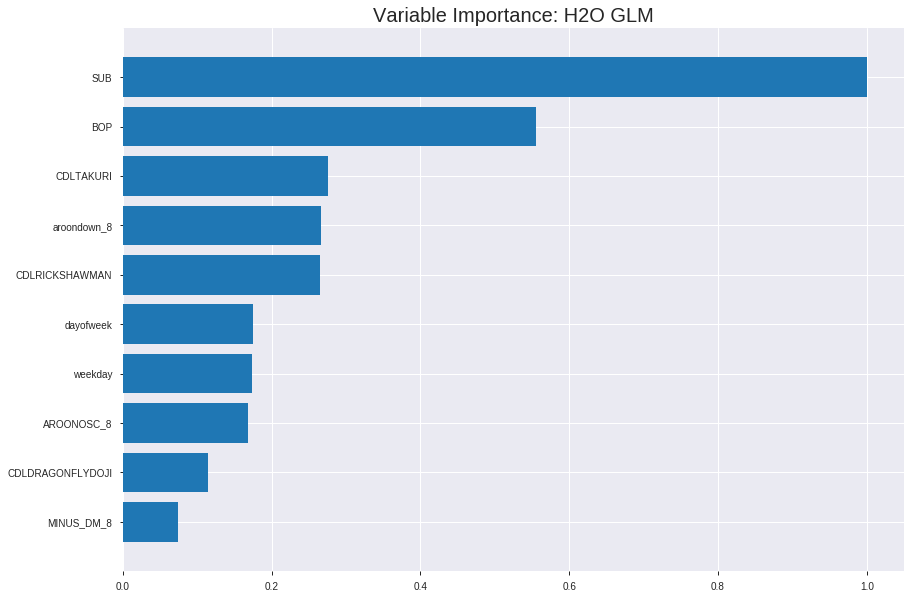

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_130018_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2325939371506625
RMSE: 0.4822799365002265
LogLoss: 0.6566442429660141
Null degrees of freedom: 1784
Residual degrees of freedom: 1774
Null deviance: 2474.2390678544516
Residual deviance: 2344.2199473886703
AIC: 2366.2199473886703
AUC: 0.6469788705513645
pr_auc: 0.6029958562674376
Gini: 0.293957741102729
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3481473706979961: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      202  702   0.7765   (702.0/904.0)
1      59   822   0.067    (59.0/881.0)
Total  261  1524  0.4263   (761.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348147     0.683576  310
max f2                       0.235695     0.835238  368
max f0point5                 0.473601     0.610347  216
max accuracy                 0.475231     0.612885  215
max precision                0.702425     0.701493  33
max recall                   0.156238     1         391
max specificity              0.848951     0.998894  0
max absolute_mcc             0.42211      0.234976  258
max min_per_class_accuracy   0.508036     0.60177   187
max mean_per_class_accuracy  0.473601     0.614185  216

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.75211            1.01305   1.01305            0.5              0.792594  0.5                         0.792594            0.0102157       0.0102157                  1.30533   1.30533
    2        0.0201681                   0.723112           1.35074   1.1819             0.666667         0.735457  0.583333                    0.764026            0.0136209       0.0238365                  35.0738   18.1896
    3        0.0302521                   0.7083             1.4633    1.2757             0.722222         0.716339  0.62963                     0.74813             0.014756        0.0385925                  46.3299   27.5697
    4        0.0403361                   0.697821           1.80098   1.40702            0.888889         0.70376   0.694444                    0.737038            0.0181612       0.0567537                  80.0984   40.7019
    5        0.0504202                   0.687657           1.12561   1.35074            0.555556         0.692609  0.666667                    0.728152            0.0113507       0.0681044                  12.5615   35.0738
    6        0.10028                     0.654988           1.36591   1.35828            0.674157         0.669463  0.670391                    0.698971            0.0681044       0.136209                   36.5915   35.8284
    7        0.15014                     0.626613           1.22932   1.31546            0.606742         0.63865   0.649254                    0.678939            0.061294        0.197503                   22.9323   31.5457
    8        0.2                         0.606467           1.29762   1.31101            0.640449         0.615677  0.647059                    0.663168            0.0646992       0.262202                   29.7619   31.101
    9        0.30028                     0.572262           1.15454   1.25876            0.569832         0.58871   0.621269                    0.638302            0.115778        0.37798                    15.4541   25.8757
    10       0.4                         0.537451           1.16103   1.23439            0.573034         0.554866  0.609244                    0.617502            0.115778        0.493757                   16.1027   23.4393
    11       0.50028                     0.506639           1.08663   1.20477            0.536313         0.52318   0.594625                    0.598595            0.108967        0.602724                   8.66271   20.4773
    12       0.6                         0.472906           1.12688   1.19183            0.55618          0.490398  0.588235                    0.580613            0.112372        0.715096                   12.688    19.1827
    13       0.69972                     0.433079           0.921992  1.15337            0.455056         0.452798  0.569255                    0.562398            0.091941        0.807037                   -7.80076  15.3372
    14       0.8                         0.382081           0.81497   1.11095            0.402235         0.40845   0.548319                    0.5431              0.0817253       0.888763                   -18.503   11.0953
    15       0.89972                     0.309898           0.648809  1.05973            0.320225         0.349009  0.523039                    0.521588            0.0646992       0.953462                   -35.1191  5.9732
    16       1                           1.42859e-08        0.46408   1                  0.22905          0.242065  0.493557                    0.493557           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24204579647965438
RMSE: 0.49198150013964387
LogLoss: 0.6773857861818924
Null degrees of freedom: 509
Residual degrees of freedom: 499
Null deviance: 706.7340007881703
Residual deviance: 690.9335019055303
AIC: 712.9335019055303
AUC: 0.6068779241566117
pr_auc: 0.5423413294166751
Gini: 0.21375584831322336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.416049188659463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      65   197  0.7519   (197.0/262.0)
1      20   228  0.0806   (20.0/248.0)
Total  85   425  0.4255   (217.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416049     0.677563  319
max f2                       0.249106     0.827218  396
max f0point5                 0.483395     0.587662  244
max accuracy                 0.546294     0.594118  168
max precision                0.72638      0.75      3
max recall                   0.249106     1         396
max specificity              0.733542     0.996183  0
max absolute_mcc             0.416049     0.224568  319
max min_per_class_accuracy   0.526448     0.587786  193
max mean_per_class_accuracy  0.483395     0.593927  244

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 51.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.719659           1.37097   1.37097            0.666667         0.726369  0.666667                    0.726369            0.016129        0.016129                   37.0968   37.0968
    2        0.0215686                   0.714531           0.822581  1.1217             0.4              0.717389  0.545455                    0.722287            0.00806452      0.0241935                  -17.7419  12.1701
    3        0.0313725                   0.704206           0         0.771169           0                0.708291  0.375                       0.717913            0               0.0241935                  -100      -22.8831
    4        0.0411765                   0.699874           0.822581  0.78341            0.4              0.701708  0.380952                    0.714055            0.00806452      0.0322581                  -17.7419  -21.659
    5        0.0509804                   0.68851            0.822581  0.790943           0.4              0.695337  0.384615                    0.710455            0.00806452      0.0403226                  -17.7419  -20.9057
    6        0.1                         0.651969           1.31613   1.04839            0.64             0.671365  0.509804                    0.691294            0.0645161       0.104839                   31.6129   4.83871
    7        0.15098                     0.624344           1.10732   1.06829            0.538462         0.634983  0.519481                    0.67228             0.0564516       0.16129                    10.732    6.82866
    8        0.2                         0.60827            1.06935   1.06855            0.52             0.616477  0.519608                    0.658603            0.0524194       0.21371                    6.93548   6.85484
    9        0.3                         0.582923           1.41129   1.1828             0.686275         0.595331  0.575163                    0.637512            0.141129        0.354839                   41.129    18.2796
    10       0.4                         0.555476           1.25      1.1996             0.607843         0.566755  0.583333                    0.619823            0.125           0.479839                   25        19.9597
    11       0.5                         0.525836           1.08871   1.17742            0.529412         0.540998  0.572549                    0.604058            0.108871        0.58871                    8.87097   17.7419
    12       0.6                         0.49596            0.967742  1.14247            0.470588         0.512357  0.555556                    0.588774            0.0967742       0.685484                   -3.22581  14.2473
    13       0.7                         0.464427           0.887097  1.10599            0.431373         0.478074  0.537815                    0.57296             0.0887097       0.774194                   -11.2903  10.5991
    14       0.8                         0.430859           1.04839   1.09879            0.509804         0.44785   0.534314                    0.557321            0.104839        0.879032                   4.83871   9.87903
    15       0.9                         0.366622           0.766129  1.06183            0.372549         0.402929  0.51634                     0.540167            0.0766129       0.955645                   -23.3871  6.1828
    16       1                           0.206837           0.443548  1                  0.215686         0.3129    0.486275                    0.51744         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:00:19  0.000 sec   2            .68E1     11            1.3785165707090503  1.3812774984495073
     2019-08-22 13:00:19  0.007 sec   4            .43E1     11            1.3745885039401655  1.3790492442457902
     2019-08-22 13:00:19  0.013 sec   6            .26E1     11            1.369152953454644   1.376069175745451
     2019-08-22 13:00:19  0.017 sec   8            .16E1     11            1.3621483258021856  1.3724383049281135
     2019-08-22 13:00:19  0.025 sec   10           .1E1      11            1.353927335404439   1.3685376218135115
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:00:19  0.074 sec   31           .34E-2    11            1.3133675382650825  1.355283114009666
     2019-08-22 13:00:19  0.077 sec   32           .21E-2    11            1.313321939297476   1.3550631587848403
     2019-08-22 13:00:19  0.080 sec   33           .13E-2    11            1.3133016870145364  1.3549189102409114
     2019-08-22 13:00:19  0.083 sec   34           .8E-3     11            1.313292659885908   1.3548288643419157
     2019-08-22 13:00:19  0.086 sec   35           .5E-3     11            1.3132884859320282  1.354771572363785


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.59375)

('F1', 0.6719160104986877)

('auc', 0.56390380859375)

('logloss', 0.6939605275878769)

('mean_per_class_error', 0.40625)

('rmse', 0.5002068026128481)

('mse', 0.2502068453801688)

glm prediction progress: |████████████████████████████████████████████████| 100%


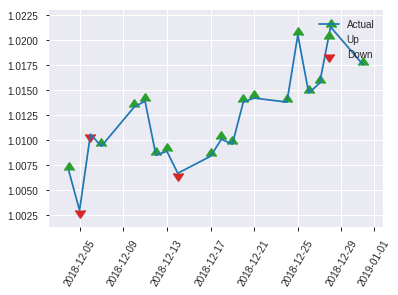


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2502068453801688
RMSE: 0.5002068026128481
LogLoss: 0.6939605275878769
Null degrees of freedom: 255
Residual degrees of freedom: 245
Null deviance: 354.9338629373763
Residual deviance: 355.30779012499295
AIC: 377.30779012499295
AUC: 0.56390380859375
pr_auc: 0.5483027702630218
Gini: 0.1278076171875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27009533029765553: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    125  0.9766   (125.0/128.0)
1      0    128  0        (0.0/128.0)
Total  3    253  0.4883   (125.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270095     0.671916  252
max f2                       0.270095     0.836601  252
max f0point5                 0.565427     0.584677  91
max accuracy                 0.565427     0.59375   91
max precision                0.746518     1         0
max recall                   0.270095     1         252
max specificity              0.746518     1         0
max absolute_mcc             0.565427     0.195387  91
max min_per_class_accuracy   0.529141     0.539062  124
max mean_per_class_accuracy  0.565427     0.59375   91

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.729749           1.33333   1.33333            0.666667         0.739919  0.666667                    0.739919            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.712113           1.33333   1.33333            0.666667         0.719722  0.666667                    0.729821            0.015625        0.03125                    33.3333   33.3333
    3        0.03125                     0.705632           0         1                  0                0.710083  0.5                         0.724886            0               0.03125                    -100      0
    4        0.0429688                   0.690336           0.666667  0.909091           0.333333         0.695243  0.454545                    0.716802            0.0078125       0.0390625                  -33.3333  -9.09091
    5        0.0507812                   0.681631           2         1.07692            1                0.686666  0.538462                    0.712165            0.015625        0.0546875                  100       7.69231
    6        0.101562                    0.648328           1.07692   1.07692            0.538462         0.664211  0.538462                    0.688188            0.0546875       0.109375                   7.69231   7.69231
    7        0.152344                    0.629297           1.53846   1.23077            0.769231         0.639772  0.615385                    0.672049            0.078125        0.1875                     53.8462   23.0769
    8        0.203125                    0.607264           1.07692   1.19231            0.538462         0.617435  0.596154                    0.658396            0.0546875       0.242188                   7.69231   19.2308
    9        0.300781                    0.58203            1.28      1.22078            0.64             0.594494  0.61039                     0.637648            0.125           0.367188                   28        22.0779
    10       0.402344                    0.551609           1         1.16505            0.5              0.56767   0.582524                    0.619984            0.101562        0.46875                    0         16.5049
    11       0.5                         0.526351           0.72      1.07812            0.36             0.539901  0.539062                    0.604343            0.0703125       0.539062                   -28       7.8125
    12       0.601562                    0.501505           0.846154  1.03896            0.423077         0.513087  0.519481                    0.588936            0.0859375       0.625                      -15.3846  3.8961
    13       0.699219                    0.465958           0.96      1.02793            0.48             0.484415  0.513966                    0.574338            0.09375         0.71875                    -4        2.7933
    14       0.800781                    0.423093           1.07692   1.03415            0.538462         0.446819  0.517073                    0.558165            0.109375        0.828125                   7.69231   3.41463
    15       0.898438                    0.386805           0.96      1.02609            0.48             0.403353  0.513043                    0.541337            0.09375         0.921875                   -4        2.6087
    16       1                           0.21837            0.769231  1                  0.384615         0.319189  0.5                         0.518775            0.0781

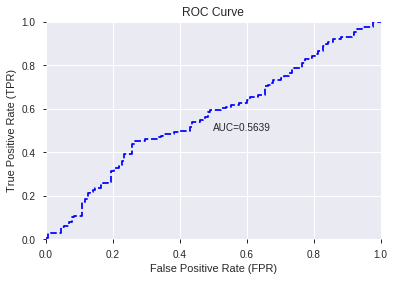

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


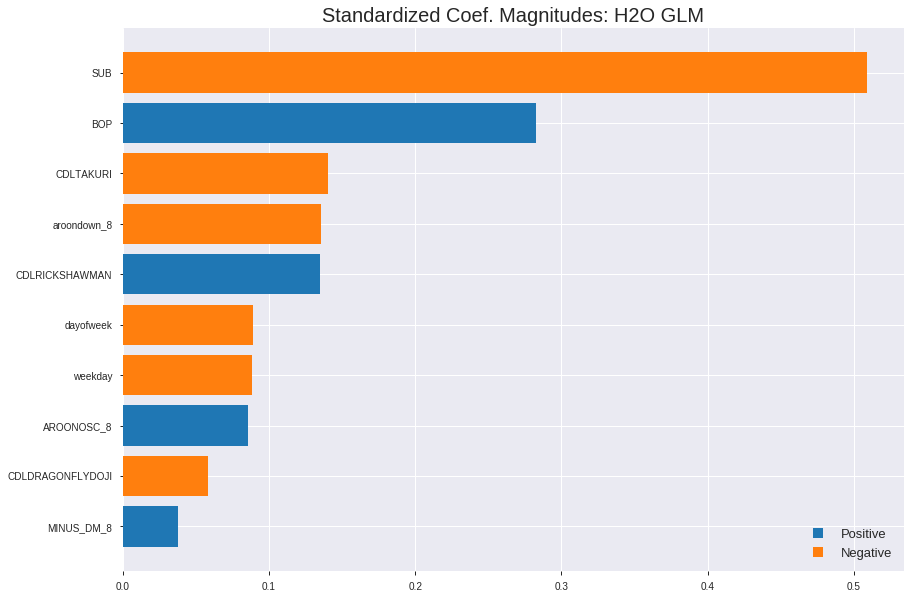

'log_likelihood'
--2019-08-22 13:00:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


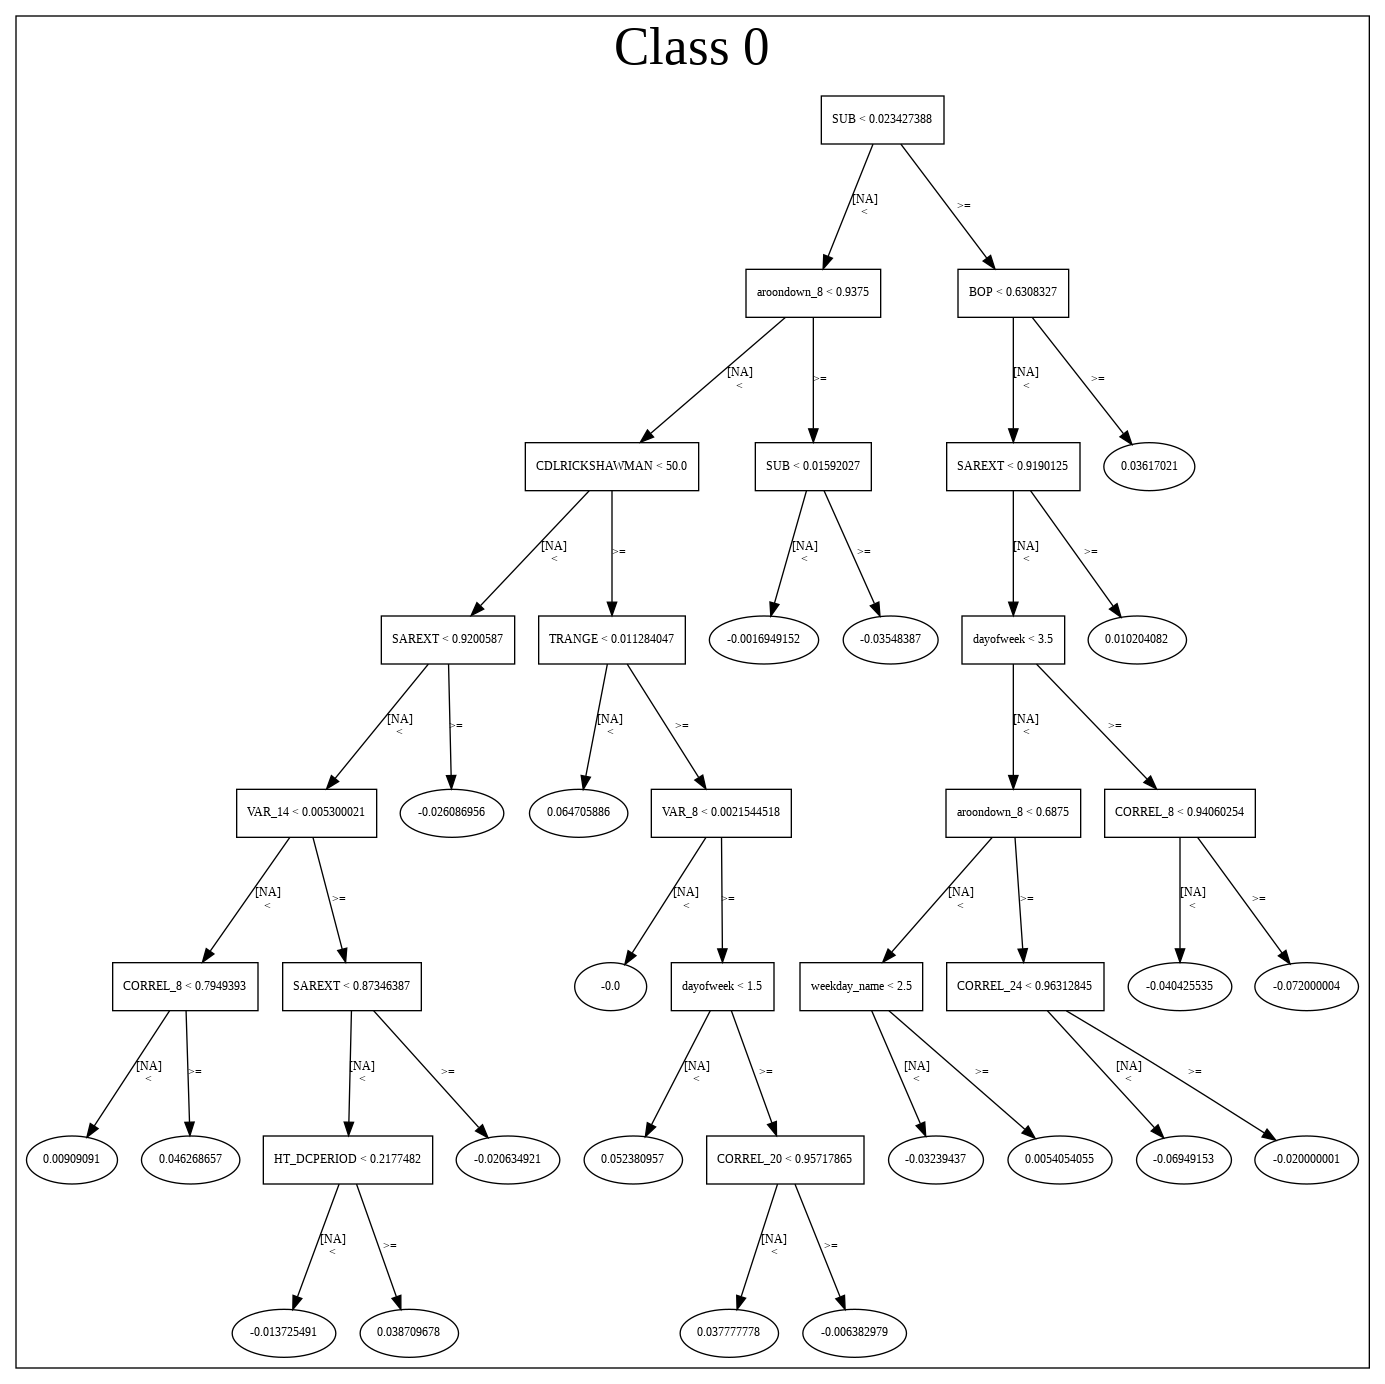

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_130018_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_130018_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'BOP',
 'CDLTAKURI',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'AROONOSC_8',
 'CDLDRAGONFLYDOJI',
 'MINUS_DM_8']

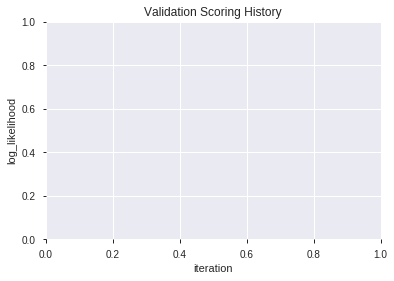

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_130036_model_2  0.610535  0.672614              0.406250  0.489773  0.239878
1  XGBoost_grid_1_AutoML_20190822_130036_model_1  0.608246  0.674558              0.390625  0.490700  0.240787
2               XGBoost_3_AutoML_20190822_130036  0.603455  0.673879              0.425781  0.490557  0.240646
3               XGBoost_2_AutoML_20190822_130036  0.592285  0.680043              0.417969  0.493387  0.243431
4  XGBoost_grid_1_AutoML_20190822_130036_model_4  0.591492  0.677826              0.429688  0.492439  0.242496
5  XGBoost_grid_1_AutoML_20190822_130036_model_3  0.587585  0.681213              0.433594  0.494089  0.244124
6  XGBoost_grid_1_AutoML_20190822_130036_model_6  0.579712  0.686031              0.457031  0.496398  0.246411
7               XGBoost_1_AutoML_20190822_130036  0.577148  0.688262              0.421875  0.497225  0.247233
8  XGBoost_grid_1_AutoML_20190822_130036_model_5  0.572205  0.704200              0.449219  0.503928  0.253944
9  XGBoost_grid_1_AutoML_20190822_130036_model_7  0.565247  0.693947              0.437500  0.499863  0.249863

variable  relative_importance  scaled_importance  percentage
0               SUB           925.898743           1.000000    0.243421
1               BOP           887.891785           0.958951    0.233429
2        MINUS_DM_8           659.303101           0.712068    0.173332
3       aroondown_8           375.454071           0.405502    0.098708
4        AROONOSC_8           307.528015           0.332140    0.080850
5         dayofweek           276.612762           0.298751    0.072722
6    CDLRICKSHAWMAN           145.292877           0.156921    0.038198
7  CDLDRAGONFLYDOJI           113.652710           0.122749    0.029880
8           weekday            70.078644           0.075687    0.018424
9         CDLTAKURI            41.982922           0.045343    0.011037

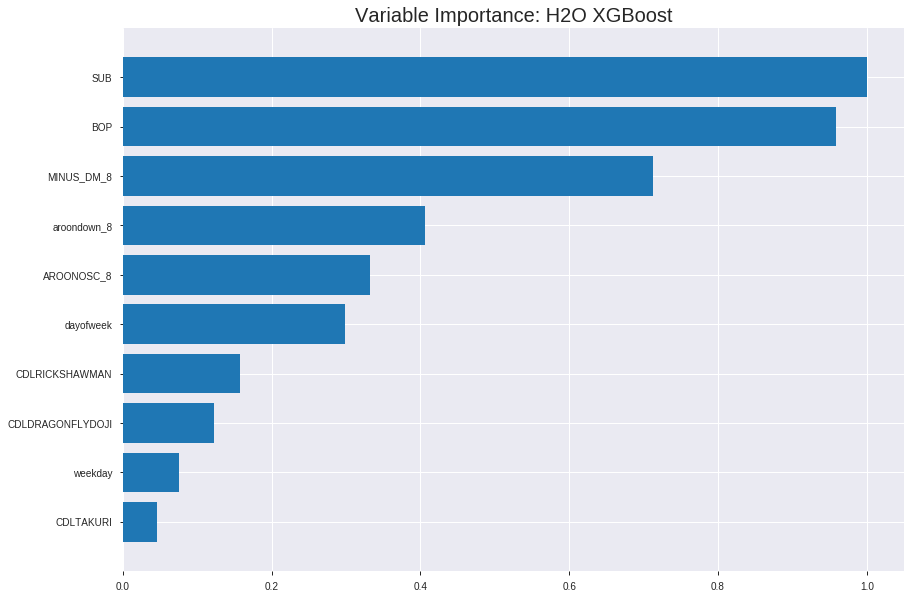

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_130036_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20743970950495674
RMSE: 0.4554554967337168
LogLoss: 0.6047013411516357
Mean Per-Class Error: 0.2937850943718421
AUC: 0.7775870641768706
pr_auc: 0.769633761708143
Gini: 0.5551741283537412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4470044622818629: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  460   0.5088   (460.0/904.0)
1      124  757   0.1407   (124.0/881.0)
Total  568  1217  0.3272   (584.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447004     0.72164   235
max f2                       0.31637      0.842904  337
max f0point5                 0.564158     0.720774  126
max accuracy                 0.554662     0.707563  137
max precision                0.730282     1         0
max recall                   0.241622     1         384
max specificity              0.730282     1         0
max absolute_mcc             0.554662     0.422229  137
max min_per_class_accuracy   0.51679      0.694665  175
max mean_per_class_accuracy  0.554662     0.706215  137

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.696993           2.02611   2.02611            1                0.710716  1                           0.710716            0.0204313       0.0204313                  102.611   102.611
    2        0.0201681                   0.689442           1.91355   1.96983            0.944444         0.694251  0.972222                    0.702483            0.0192963       0.0397276                  91.3545   96.9826
    3        0.0302521                   0.680154           1.80098   1.91355            0.888889         0.684296  0.944444                    0.696421            0.0181612       0.0578888                  80.0984   91.3545
    4        0.0403361                   0.669261           1.91355   1.91355            0.944444         0.673824  0.944444                    0.690772            0.0192963       0.077185                   91.3545   91.3545
    5        0.0504202                   0.664223           1.91355   1.91355            0.944444         0.666891  0.944444                    0.685996            0.0192963       0.0964813                  91.3545   91.3545
    6        0.10028                     0.64482            1.6391    1.77709            0.808989         0.653512  0.877095                    0.669844            0.0817253       0.178207                   63.9098   77.7088
    7        0.15014                     0.625507           1.73016   1.7615             0.853933         0.635563  0.869403                    0.65846             0.0862656       0.264472                   73.0159   76.1503
    8        0.2                         0.60816            1.5708    1.71396            0.775281         0.616044  0.845938                    0.647885            0.0783201       0.342792                   57.0802   71.3961
    9        0.30028                     0.579546           1.47147   1.63298            0.726257         0.592955  0.80597                     0.629541            0.14756         0.490352                   47.1474   63.2982
    10       0.4                         0.551506           1.17241   1.51816            0.578652         0.565274  0.7493                      0.613519            0.116913        0.607264                   17.241    51.8161
    11       0.50028                     0.514619           0.916842  1.39763            0.452514         0.531403  0.68981                     0.597059            0.091941        0.699205                   -8.31584  39.7628
    12       0.6                         0.479133           0.91061   1.31669            0.449438         0.496294  0.64986                     0.580312            0.0908059       0.790011                   -8.93902  31.6686
    13       0.69972                     0.436005           0.785401  1.24097            0.38764          0.45976   0.61249                     0.563132            0.0783201       0.868331                   -21.4599  24.097
    14       0.8                         0.384418           0.633866  1.16487            0.312849         0.411196  0.57493                     0.544086            0.0635641       0.931896                   -36.6134  16.4869
    15       0.89972                     0.317705           0.489453  1.09001            0.241573         0.353849  0.537983                    0.523002            0.0488082       0.980704                   -51.0547  9.00101
    16       1                           0.196435           0.192424  1                  0.0949721        0.274038  0.493557                    0.498036          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2391427043343419
RMSE: 0.48902219206733544
LogLoss: 0.6708872855748006
Mean Per-Class Error: 0.39967064762373794
AUC: 0.6146885003693672
pr_auc: 0.5567258460787533
Gini: 0.22937700073873435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4395393133163452: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      68   194  0.7405   (194.0/262.0)
1      18   230  0.0726   (18.0/248.0)
Total  86   424  0.4157   (212.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439539     0.684524  323
max f2                       0.340159     0.832769  377
max f0point5                 0.488382     0.594548  277
max accuracy                 0.488382     0.594118  277
max precision                0.716109     1         0
max recall                   0.322039     1         387
max specificity              0.716109     1         0
max absolute_mcc             0.439539     0.249572  323
max min_per_class_accuracy   0.548137     0.572581  192
max mean_per_class_accuracy  0.488382     0.600329  277

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 53.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.701693           1.02823   1.02823            0.5              0.712109  0.5                         0.712109            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.687488           1.23387   1.1217             0.6              0.692368  0.545455                    0.703136            0.0120968       0.0241935                  23.3871   12.1701
    3        0.0313725                   0.673699           0.822581  1.02823            0.4              0.67844   0.5                         0.695419            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.670828           2.05645   1.27304            1                0.672624  0.619048                    0.689991            0.0201613       0.0524194                  105.645   27.3041
    5        0.0509804                   0.667227           0.822581  1.18641            0.4              0.668719  0.576923                    0.685901            0.00806452      0.0604839                  -17.7419  18.6414
    6        0.1                         0.645596           1.23387   1.20968            0.6              0.656924  0.588235                    0.671696            0.0604839       0.120968                   23.3871   20.9677
    7        0.15098                     0.629291           1.10732   1.17512            0.538462         0.637531  0.571429                    0.66016             0.0564516       0.177419                   10.732    17.5115
    8        0.2                         0.614833           1.31613   1.20968            0.64             0.622581  0.588235                    0.650949            0.0645161       0.241935                   31.6129   20.9677
    9        0.3                         0.588789           1.12903   1.1828             0.54902          0.60028   0.575163                    0.63406             0.112903        0.354839                   12.9032   18.2796
    10       0.4                         0.565859           1.04839   1.14919            0.509804         0.5752    0.558824                    0.619345            0.104839        0.459677                   4.83871   14.9194
    11       0.5                         0.546757           1.12903   1.14516            0.54902          0.557135  0.556863                    0.606903            0.112903        0.572581                   12.9032   14.5161
    12       0.6                         0.526487           1.08871   1.13575            0.529412         0.537444  0.552288                    0.595326            0.108871        0.681452                   8.87097   13.5753
    13       0.7                         0.494413           1.08871   1.12903            0.529412         0.508997  0.54902                     0.582994            0.108871        0.790323                   8.87097   12.9032
    14       0.8                         0.456373           1.04839   1.11895            0.509804         0.477998  0.544118                    0.569869            0.104839        0.895161                   4.83871   11.8952
    15       0.9                         0.400018           0.725806  1.07527            0.352941         0.430461  0.522876                    0.554379            0.0725806       0.967742                   -27.4194  7.52688
    16       1                           0.229008           0.322581  1                  0.156863         0.339273  0.486275                    0.532869         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:00:41  0.826 sec   0                  0.5              0.693147            0.5             0                  1                0.506443                         0.5                0.693147              0.5               0                    1                  0.513725
    2019-08-22 13:00:41  0.903 sec   5                  0.491636         0.676531            0.70895         0.676194           1.57586          0.380952                         0.495984           0.685135              0.617397          0.56395              1.37097            0.441176
    2019-08-22 13:00:41  0.966 sec   10                 0.484815         0.663082            0.725281        0.691642           1.62089          0.369188                         0.493447           0.68006               0.619221          0.578618             1.54234            0.435294
    2019-08-22 13:00:41  1.031 sec   15                 0.47894          0.651512            0.737181        0.712062           1.80098          0.343978                         0.492027           0.677194              0.617944          0.565642             0.881336           0.439216
    2019-08-22 13:00:41  1.094 sec   20                 0.474263         0.642273            0.741693        0.716347           1.59956          0.357423                         0.490225           0.673542              0.624754          0.57047              1.02823            0.445098
    2019-08-22 13:00:41  1.167 sec   25                 0.470304         0.634404            0.748061        0.726933           1.57586          0.344538                         0.490261           0.673549              0.615573          0.556365             1.02823            0.443137
    2019-08-22 13:00:41  1.231 sec   30                 0.467049         0.62787             0.751984        0.733499           1.80098          0.345658                         0.489618           0.672213              0.617767          0.560638             1.02823            0.45098
    2019-08-22 13:00:41  1.301 sec   35                 0.463966         0.621677            0.756788        0.7437             1.91355          0.354622                         0.489499           0.671935              0.615935          0.55876              1.37097            0.437255
    2019-08-22 13:00:41  1.373 sec   40                 0.460997         0.615761            0.763843        0.752011           1.91355          0.334454                         0.488965           0.670818              0.617205          0.557518             1.02823            0.433333
    2019-08-22 13:00:41  1.452 sec   45                 0.458278         0.610312            0.769773        0.760846           2.02611          0.328291                         0.489049           0.670956              0.614804          0.56046              1.02823            0.407843
    2019-08-22 13:00:42  1.532 sec   50                 0.455455         0.604701            0.777587        0.769634           2.02611          0.327171                         0.489022           0.670887              0.614689          0.556726             1.02823            0.415686

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
SUB               925.899                1                    0.243421
BOP               887.892                0.958951             0.233429
MINUS_DM_8        659.303                0.712068             0.173332
aroondown_8       375.454                0.405502             0.0987077
AROONOSC_8        307.528                0.33214              0.0808498
dayofweek         276.613                0.298751             0.0727221
CDLRICKSHAWMAN    145.293                0.156921             0.0381978
CDLDRAGONFLYDOJI  113.653                0.122749             0.0298795
weekday           70.0786                0.0756872            0.0184238
CDLTAKURI         41.9829                0.0453429            0.0110374

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.61328125)

('F1', 0.7011494252873562)

('auc', 0.61053466796875)

('logloss', 0.672613703126369)

('mean_per_class_error', 0.38671875)

('rmse', 0.48977321501508725)

('mse', 0.23987780214621487)

xgboost prediction progress: |████████████████████████████████████████████| 100%


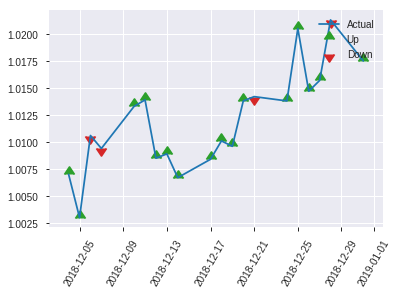


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23987780214621487
RMSE: 0.48977321501508725
LogLoss: 0.672613703126369
Mean Per-Class Error: 0.38671875
AUC: 0.61053466796875
pr_auc: 0.5661931300855131
Gini: 0.2210693359375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4293147623538971: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      30   98   0.7656   (98.0/128.0)
1      6    122  0.0469   (6.0/128.0)
Total  36   220  0.4062   (104.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429315     0.701149  219
max f2                       0.373033     0.839947  243
max f0point5                 0.517182     0.614641  148
max accuracy                 0.519982     0.613281  146
max precision                0.675987     0.666667  8
max recall                   0.324585     1         253
max specificity              0.700016     0.992188  0
max absolute_mcc             0.429315     0.26968   219
max min_per_class_accuracy   0.539159     0.554688  127
max mean_per_class_accuracy  0.519982     0.613281  146

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.688656           0.666667  0.666667           0.333333         0.694711  0.333333                    0.694711            0.0078125       0.0078125                  -33.3333  -33.3333
    2        0.0234375                   0.683176           1.33333   1                  0.666667         0.685961  0.5                         0.690336            0.015625        0.0234375                  33.3333   0
    3        0.03125                     0.676353           2         1.25               1                0.679345  0.625                       0.687588            0.015625        0.0390625                  100       25
    4        0.0429688                   0.667596           1.33333   1.27273            0.666667         0.671671  0.636364                    0.683247            0.015625        0.0546875                  33.3333   27.2727
    5        0.0507812                   0.661151           1         1.23077            0.5              0.663426  0.615385                    0.680198            0.0078125       0.0625                     0         23.0769
    6        0.101562                    0.642312           1.23077   1.23077            0.615385         0.652532  0.615385                    0.666365            0.0625          0.125                      23.0769   23.0769
    7        0.152344                    0.626589           1.23077   1.23077            0.615385         0.632608  0.615385                    0.655113            0.0625          0.1875                     23.0769   23.0769
    8        0.203125                    0.610702           0.923077  1.15385            0.461538         0.617911  0.576923                    0.645812            0.046875        0.234375                   -7.69231  15.3846
    9        0.300781                    0.579408           1.12      1.14286            0.56             0.592049  0.571429                    0.628356            0.109375        0.34375                    12        14.2857
    10       0.402344                    0.559781           1.07692   1.12621            0.538462         0.569606  0.563107                    0.613526            0.109375        0.453125                   7.69231   12.6214
    11       0.5                         0.538629           1.04      1.10938            0.52             0.547556  0.554688                    0.600641            0.101562        0.554688                   4         10.9375
    12       0.601562                    0.51018            1.46154   1.16883            0.730769         0.525471  0.584416                    0.58795             0.148438        0.703125                   46.1538   16.8831
    13       0.699219                    0.486211           0.8       1.11732            0.4              0.500432  0.558659                    0.575727            0.078125        0.78125                    -20       11.7318
    14       0.800781                    0.460689           1         1.10244            0.5              0.474666  0.55122                     0.56291             0.101562        0.882812                   0         10.2439
    15       0.898438                    0.409403           0.8       1.06957            0.4              0.434915  0.534783                    0.548997            0.078125        0.960938                   -20       6.95652
    16       1                           0.237365           0.384615  1                  0.192308         0.366649  0.5                         0.530477            0.03906

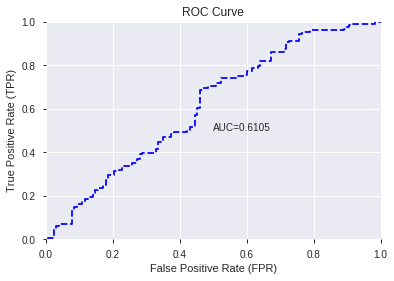

This function is available for GLM models only


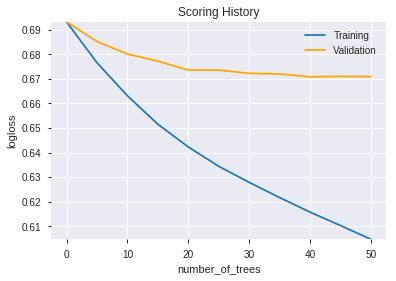

--2019-08-22 13:00:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

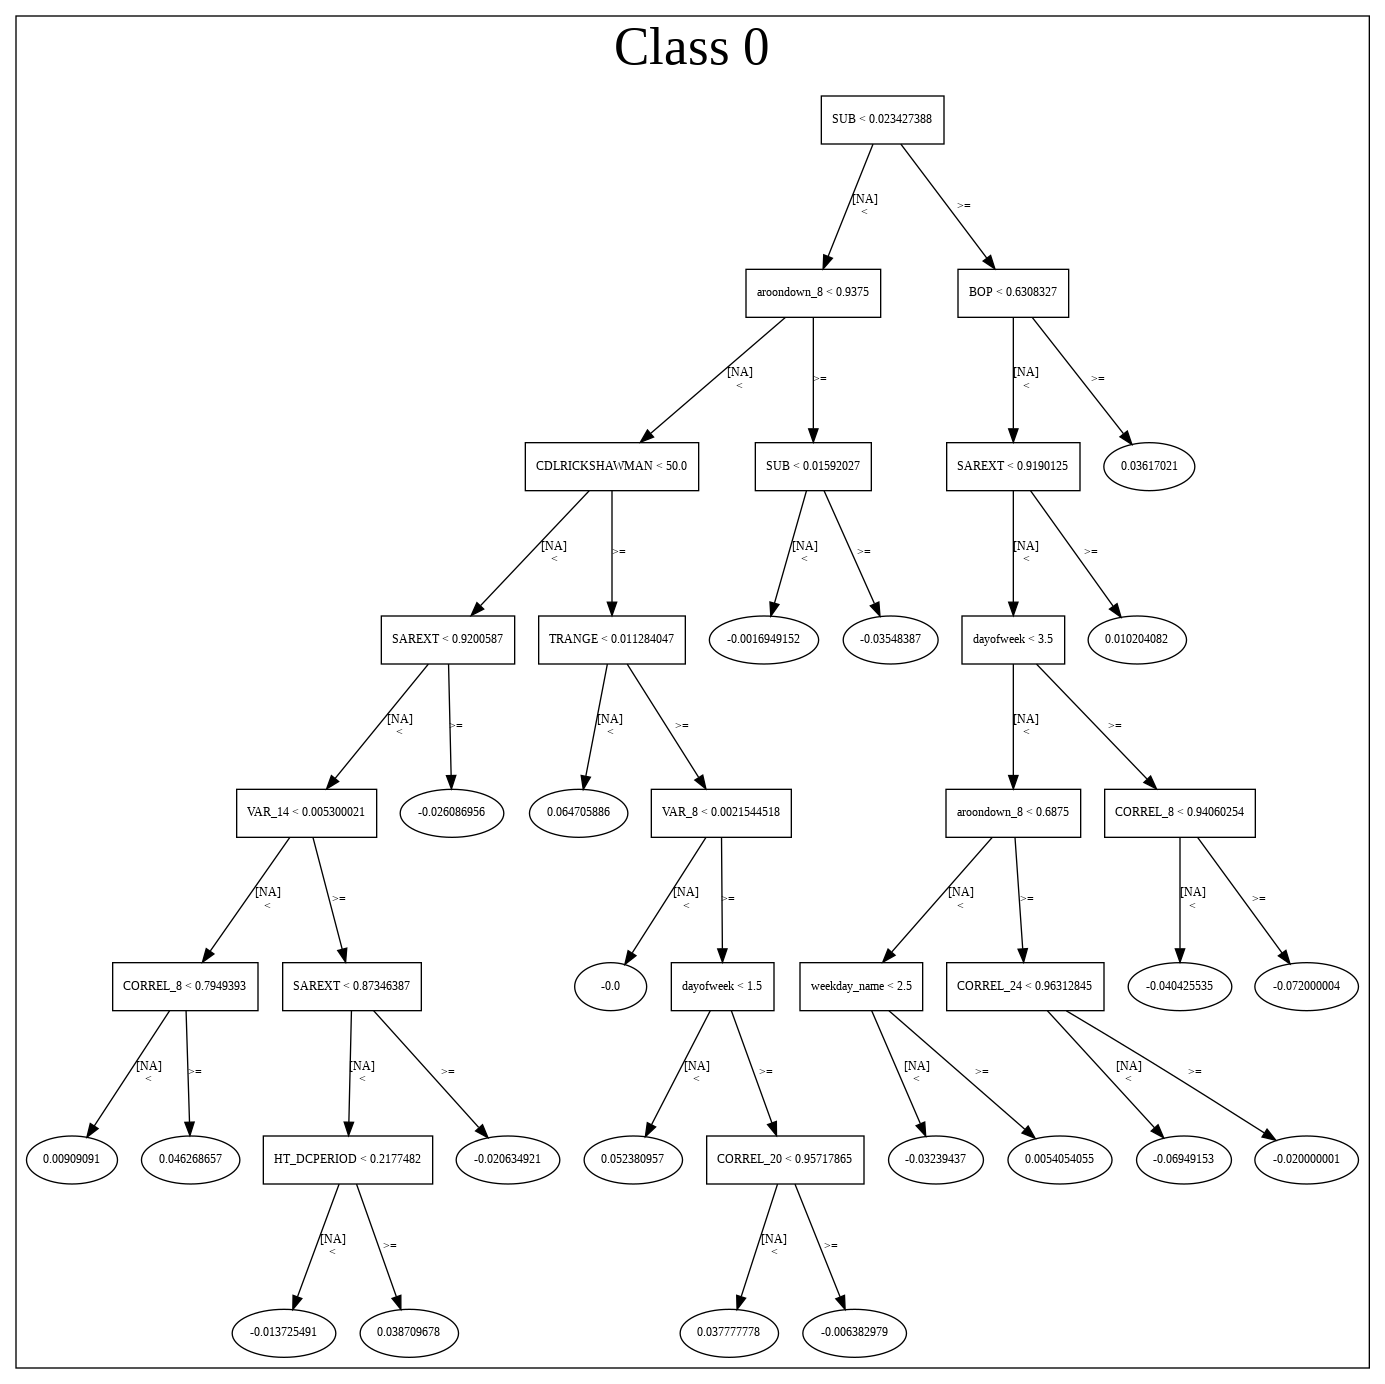

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_130036_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_130036_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SUB',
 'BOP',
 'MINUS_DM_8',
 'aroondown_8',
 'AROONOSC_8',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'CDLDRAGONFLYDOJI',
 'weekday',
 'CDLTAKURI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

65

['BBANDS_upperband_14_0_4',
 'BBANDS_upperband_14_7_2',
 'BBANDS_upperband_20_3_5',
 'MAVP_24_2',
 'BBANDS_lowerband_30_1_5',
 'BOP',
 'aroonup_8',
 'DX_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_8',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'DX_12',
 'MACDFIX_signal_12',
 'MINUS_DM_12',
 'MOM_12',
 'PLUS_DM_12',
 'WILLR_12',
 'ADXR_14',
 'AROONOSC_14',
 'PLUS_DM_14',
 'ROCP_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'MACDFIX_signal_20',
 'MACDFIX_hist_20',
 'MINUS_DI_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'RSI_20',
 'ADX_24',
 'aroonup_24',
 'CCI_24',
 'MACDFIX_hist_24',
 'MINUS_DI_24',
 'WILLR_24',
 'aroonup_30',
 'DX_30',
 'MOM_30',
 'PLUS_DM_30',
 'ROCP_30',
 'ROCR100_30',
 'RSI_30',
 'MACDEXT_signal',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'NATR_12',
 'NATR_24',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLHIGHWAVE',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'LINEARREG_SLOPE_8',
 'TSF_8']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_130229_model_9  0.637024  0.664270              0.386719  0.485614  0.235821
1  DeepLearning_grid_1_AutoML_20190822_130229_model_8  0.601135  0.671506              0.429688  0.489489  0.239600
2  DeepLearning_grid_1_AutoML_20190822_130229_model_2  0.596802  0.792173              0.496094  0.519357  0.269732
3  DeepLearning_grid_1_AutoML_20190822_130229_model_3  0.592651  0.846002              0.480469  0.540926  0.292601
4  DeepLearning_grid_1_AutoML_20190822_130229_model_1  0.587830  1.035381              0.488281  0.561154  0.314894
5  DeepLearning_grid_1_AutoML_20190822_130229_model_7  0.571350  0.743140              0.457031  0.516643  0.266920
6  DeepLearning_grid_1_AutoML_20190822_130229_model_4  0.568604  0.907100              0.476562  0.550002  0.302502
7  DeepLearning_grid_1_AutoML_20190822_130229_model_5  0.552246  0.733698              0.457031  0.517204  0.267500
8  DeepLearning_grid_1_AutoML_20190822_130229_model_6  0.547241  0.701225              0.476562  0.503759  0.253773
9               DeepLearning_1_AutoML_20190822_130229  0.528259  0.815322              0.492188  0.538228  0.289689

variable  relative_importance  scaled_importance  percentage
0           TRANGE             1.000000           1.000000    0.034149
1              BOP             0.936137           0.936137    0.031968
2   CDLRICKSHAWMAN             0.768843           0.768843    0.026255
3       MINUS_DM_8             0.642107           0.642107    0.021927
4     CDLSHORTLINE             0.570735           0.570735    0.019490
..             ...                  ...                ...         ...
60          CCI_24             0.355453           0.355453    0.012138
61          ROCP_8             0.347230           0.347230    0.011858
62        WILLR_24             0.341588           0.341588    0.011665
63           MOM_8             0.337622           0.337622    0.011529
64       ROCR100_8             0.333547           0.333547    0.011390

[65 rows x 4 columns]

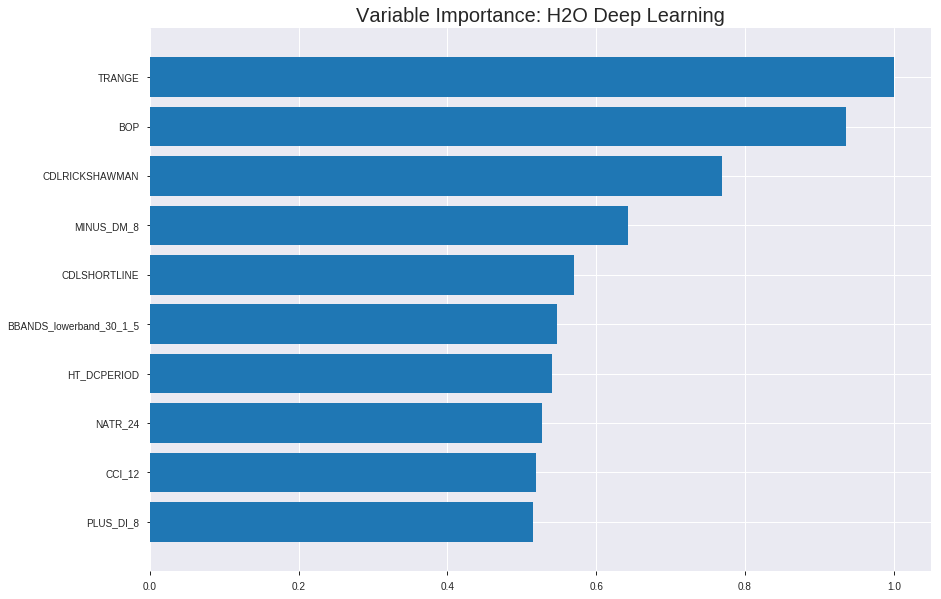

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_130229_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2172454400078813
RMSE: 0.466095955794385
LogLoss: 0.6233204130907378
Mean Per-Class Error: 0.3592357839542757
AUC: 0.7036729179432061
pr_auc: 0.6843066053852239
Gini: 0.40734583588641216
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.429413009667684: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      317  587   0.6493   (587.0/904.0)
1      71   810   0.0806   (71.0/881.0)
Total  388  1397  0.3686   (658.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429413     0.71115   266
max f2                       0.251561     0.840077  355
max f0point5                 0.499522     0.631232  225
max accuracy                 0.499522     0.638095  225
max precision                0.897896     1         0
max recall                   0.172872     1         392
max specificity              0.897896     1         0
max absolute_mcc             0.429413     0.327371  266
max min_per_class_accuracy   0.531551     0.627212  190
max mean_per_class_accuracy  0.499522     0.640764  225

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 51.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.820984           1.91355   1.91355            0.944444         0.84969   0.944444                    0.84969             0.0192963       0.0192963                  91.3545   91.3545
    2        0.0201681                   0.77578            1.68842   1.80098            0.833333         0.797744  0.888889                    0.823717            0.0170261       0.0363224                  68.8422   80.0984
    3        0.0302521                   0.747053           1.4633    1.68842            0.722222         0.760985  0.833333                    0.802806            0.014756        0.0510783                  46.3299   68.8422
    4        0.0403361                   0.731494           1.4633    1.63214            0.722222         0.739369  0.805556                    0.786947            0.014756        0.0658343                  46.3299   63.2142
    5        0.0504202                   0.71716            1.57586   1.62089            0.777778         0.725196  0.8                         0.774597            0.015891        0.0817253                  57.5861   62.0885
    6        0.10028                     0.663823           1.70739   1.6639             0.842697         0.686778  0.821229                    0.730933            0.0851305       0.166856                   70.7393   66.3898
    7        0.15014                     0.633055           1.38868   1.5725             0.685393         0.646548  0.776119                    0.702909            0.0692395       0.236095                   38.868    57.2501
    8        0.2                         0.610933           1.25209   1.49262            0.617978         0.620957  0.736695                    0.682479            0.0624291       0.298524                   25.2088   49.2622
    9        0.30028                     0.57423            1.22246   1.4024             0.603352         0.59184   0.692164                    0.652209            0.122588        0.421112                   22.2455   40.2398
    10       0.4                         0.545122           1.05858   1.31669            0.522472         0.558469  0.64986                     0.62884             0.105562        0.526674                   5.85838   31.6686
    11       0.50028                     0.531158           1.05267   1.26376            0.519553         0.537598  0.62374                     0.610551            0.105562        0.632236                   5.267     26.3764
    12       0.6                         0.521592           0.990288  1.21831            0.488764         0.525937  0.601307                    0.596488            0.0987514       0.730988                   -0.97119  21.8313
    13       0.69972                     0.50139            1.08135   1.19879            0.533708         0.515893  0.591673                    0.585002            0.107832        0.83882                    8.13491   19.8793
    14       0.8                         0.406601           0.916842  1.16345            0.452514         0.460083  0.57423                     0.569343            0.091941        0.93076                    -8.31584  16.3451
    15       0.89972                     0.290005           0.43254   1.08244            0.213483         0.346384  0.534247                    0.544632            0.0431328       0.973893                   -56.746   8.24406
    16       1                           0.0679149          0.260338  1                  0.128492         0.231217  0.493557                    0.513203         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24312453018643226
RMSE: 0.4930765966728012
LogLoss: 0.6797156095517303
Mean Per-Class Error: 0.40370290568825407
AUC: 0.595666092095543
pr_auc: 0.5378012965300053
Gini: 0.191332184191086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36705589593493165: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   218  0.8321   (218.0/262.0)
1      11   237  0.0444   (11.0/248.0)
Total  55   455  0.449    (229.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367056     0.674253  347
max f2                       0.23543      0.830543  391
max f0point5                 0.517335     0.591492  267
max accuracy                 0.517477     0.590196  266
max precision                0.67345      0.652174  22
max recall                   0.23543      1         391
max specificity              0.842966     0.996183  0
max absolute_mcc             0.517335     0.214298  267
max min_per_class_accuracy   0.541915     0.553435  197
max mean_per_class_accuracy  0.517335     0.596297  267

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 52.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.770648           1.02823   1.02823            0.5              0.813012  0.5                         0.813012            0.0120968       0.0120968                  2.82258   2.82258
    2        0.0215686                   0.727211           0.822581  0.934751           0.4              0.742486  0.454545                    0.780955            0.00806452      0.0201613                  -17.7419  -6.52493
    3        0.0313725                   0.698247           1.64516   1.15675            0.8              0.717292  0.5625                      0.76106             0.016129        0.0362903                  64.5161   15.6754
    4        0.0411765                   0.677093           1.64516   1.27304            0.8              0.6843    0.619048                    0.742784            0.016129        0.0524194                  64.5161   27.3041
    5        0.0509804                   0.670286           0.822581  1.18641            0.4              0.672903  0.576923                    0.729345            0.00806452      0.0604839                  -17.7419  18.6414
    6        0.1                         0.629541           0.822581  1.00806            0.4              0.652005  0.490196                    0.691433            0.0403226       0.100806                   -17.7419  0.806452
    7        0.15098                     0.617734           1.02823   1.01487            0.5              0.621928  0.493506                    0.667964            0.0524194       0.153226                   2.82258   1.48722
    8        0.2                         0.603619           1.31613   1.08871            0.64             0.611781  0.529412                    0.654194            0.0645161       0.217742                   31.6129   8.87097
    9        0.3                         0.574349           1.29032   1.15591            0.627451         0.588539  0.562092                    0.632309            0.129032        0.346774                   29.0323   15.5914
    10       0.4                         0.554475           1.00806   1.11895            0.490196         0.562537  0.544118                    0.614866            0.100806        0.447581                   0.806452  11.8952
    11       0.5                         0.541518           1.08871   1.1129             0.529412         0.548677  0.541176                    0.601628            0.108871        0.556452                   8.87097   11.2903
    12       0.6                         0.527927           1.20968   1.12903            0.588235         0.534468  0.54902                     0.590435            0.120968        0.677419                   20.9677   12.9032
    13       0.7                         0.519087           1.12903   1.12903            0.54902          0.522421  0.54902                     0.580718            0.112903        0.790323                   12.9032   12.9032
    14       0.8                         0.463816           0.806452  1.08871            0.392157         0.501917  0.529412                    0.570868            0.0806452       0.870968                   -19.3548  8.87097
    15       0.9                         0.363259           0.846774  1.06183            0.411765         0.421413  0.51634                     0.554262            0.0846774       0.955645                   -15.3226  6.1828
    16       1                           0.187145           0.443548  1                  0.215686         0.288574  0.486275                    0.527693        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:09:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:09:15  2 min 13.510 sec  479 obs/sec       0.594398  1             1061       0.539557         0.822277            -0.164681      0.563525        0.550118           1.35074          0.503641                         0.525573           0.769676              -0.105742        0.564455          0.547036             1.71371            0.501961
    2019-08-22 13:09:26  2 min 24.460 sec  787 obs/sec       5.3619    9             9571       0.495204         0.683548            0.0189298      0.629911        0.606139           1.4633           0.439216                         0.498258           0.689666              0.00620543       0.57796           0.528072             1.02823            0.484314
    2019-08-22 13:09:37  2 min 35.323 sec  922 obs/sec       11.3681   19            20292      0.484796         0.661745            0.0597345      0.633922        0.616391           1.68842          0.420168                         0.499399           0.691986              0.00164836       0.589133          0.538115             1.37097            0.482353
    2019-08-22 13:09:48  2 min 46.286 sec  1004 obs/sec      17.9563   30            32052      0.482006         0.656345            0.0705258      0.654563        0.627863           1.80098          0.40112                          0.494378           0.681636              0.0216257        0.593381          0.541747             1.37097            0.443137
    2019-08-22 13:09:59  2 min 57.033 sec  1075 obs/sec      25.0874   42            44781      0.475526         0.642754            0.0953491      0.670279        0.643702           1.91355          0.396639                         0.495664           0.684448              0.0165261        0.580453          0.533521             0.685484           0.460784
    2019-08-22 13:10:10  3 min  7.881 sec  1139 obs/sec      32.8454   55            58629      0.471599         0.634337            0.110231       0.680315        0.654027           1.80098          0.379272                         0.493985           0.680695              0.0231796        0.580953          0.535256             1.37097            0.44902
    2019-08-22 13:10:21  3 min 18.959 sec  1194 obs/sec      41.1619   69            73474      0.466096         0.62332             0.130874       0.703673        0.684307           1.91355          0.368627                         0.493077           0.679716              0.0267685        0.595666          0.537801             1.02823            0.44902

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
TRANGE          1.0                    1.0                  0.03414885302548531
BOP             0.9361370205879211     0.9361370205879211   0.03196800552777263
CDLRICKSHAWMAN  0.7688429355621338     0.7688429355621338   0.02625510440619398
MINUS_DM_8      0.6421071887016296     0.6421071887016296   0.02192722401357951
CDLSHORTLINE    0.5707346796989441     0.5707346796989441   0.019489934693586675
---             ---                    ---                  ---
CCI_24          0.35545262694358826    0.35545262694358826  0.012138299515019255
ROCP_8          0.34723007678985596    0.34723007678985596  0.011857508858324768
WILLR_24        0.34158846735954285    0.34158846735954285  0.011664854367061814
MOM_8           0.33762234449386597    0.33762234449386597  0.011529415820240798
ROCR100_8       0.33354708552360535    0.33354708552360535  0.011390250400624578


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6171875)

('F1', 0.7027027027027026)

('auc', 0.63702392578125)

('logloss', 0.664270323072195)

('mean_per_class_error', 0.3828125)

('rmse', 0.4856142252125744)

('mse', 0.23582117572880895)

deeplearning prediction progress: |███████████████████████████████████████| 100%


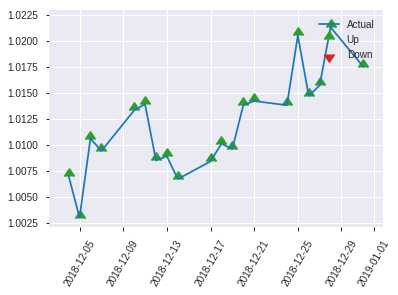


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23582117572880895
RMSE: 0.4856142252125744
LogLoss: 0.664270323072195
Mean Per-Class Error: 0.3828125
AUC: 0.63702392578125
pr_auc: 0.5954154768057592
Gini: 0.2740478515625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48068111361275495: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   88   0.6875   (88.0/128.0)
1      11   117  0.0859   (11.0/128.0)
Total  51   205  0.3867   (99.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480681     0.702703  204
max f2                       0.335814     0.845443  244
max f0point5                 0.504129     0.619518  195
max accuracy                 0.506497     0.617188  193
max precision                0.82755      1         0
max recall                   0.335814     1         244
max specificity              0.82755      1         0
max absolute_mcc             0.480681     0.283619  204
max min_per_class_accuracy   0.544132     0.601562  127
max mean_per_class_accuracy  0.506497     0.617188  193

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 54.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.796507           1.33333   1.33333            0.666667         0.816873  0.666667                    0.816873            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.754354           1.33333   1.33333            0.666667         0.772517  0.666667                    0.794695            0.015625        0.03125                    33.3333   33.3333
    3        0.03125                     0.737539           2         1.5                1                0.744228  0.75                        0.782078            0.015625        0.046875                   100       50
    4        0.0429688                   0.729967           0.666667  1.27273            0.333333         0.73268   0.636364                    0.768606            0.0078125       0.0546875                  -33.3333  27.2727
    5        0.0507812                   0.701198           2         1.38462            1                0.718686  0.692308                    0.760926            0.015625        0.0703125                  100       38.4615
    6        0.101562                    0.660333           1.07692   1.23077            0.538462         0.675515  0.615385                    0.718221            0.0546875       0.125                      7.69231   23.0769
    7        0.152344                    0.640328           1.38462   1.28205            0.692308         0.650502  0.641026                    0.695648            0.0703125       0.195312                   38.4615   28.2051
    8        0.203125                    0.61824            1.07692   1.23077            0.538462         0.630219  0.615385                    0.679291            0.0546875       0.25                       7.69231   23.0769
    9        0.300781                    0.576433           1.2       1.22078            0.6              0.600142  0.61039                     0.653593            0.117188        0.367188                   20        22.0779
    10       0.402344                    0.555874           1.23077   1.2233             0.615385         0.565692  0.61165                     0.631404            0.125           0.492188                   23.0769   22.3301
    11       0.5                         0.543026           1.12      1.20312            0.56             0.549191  0.601562                    0.615347            0.109375        0.601562                   12        20.3125
    12       0.601562                    0.529054           0.846154  1.14286            0.423077         0.53593   0.571429                    0.601939            0.0859375       0.6875                     -15.3846  14.2857
    13       0.699219                    0.518605           1.12      1.13966            0.56             0.524403  0.569832                    0.59111             0.109375        0.796875                   12        13.9665
    14       0.800781                    0.480681           1.15385   1.14146            0.576923         0.505709  0.570732                    0.580279            0.117188        0.914062                   15.3846   14.1463
    15       0.898438                    0.387356           0.4       1.06087            0.2              0.434616  0.530435                    0.564446            0.0390625       0.953125                   -60       6.08696
    16       1                           0.237075           0.461538  1                  0.230769         0.335879  0.5                         0.541232            0.

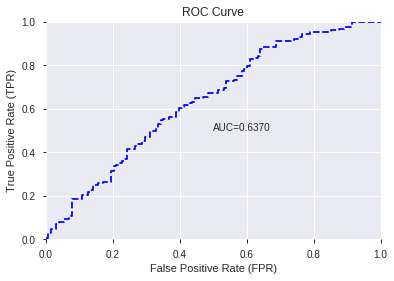

This function is available for GLM models only


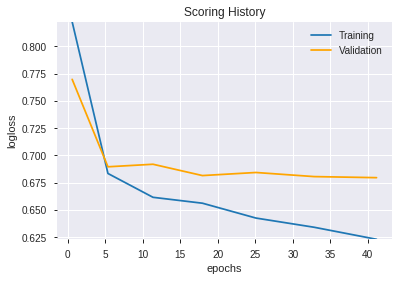

--2019-08-22 13:10:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


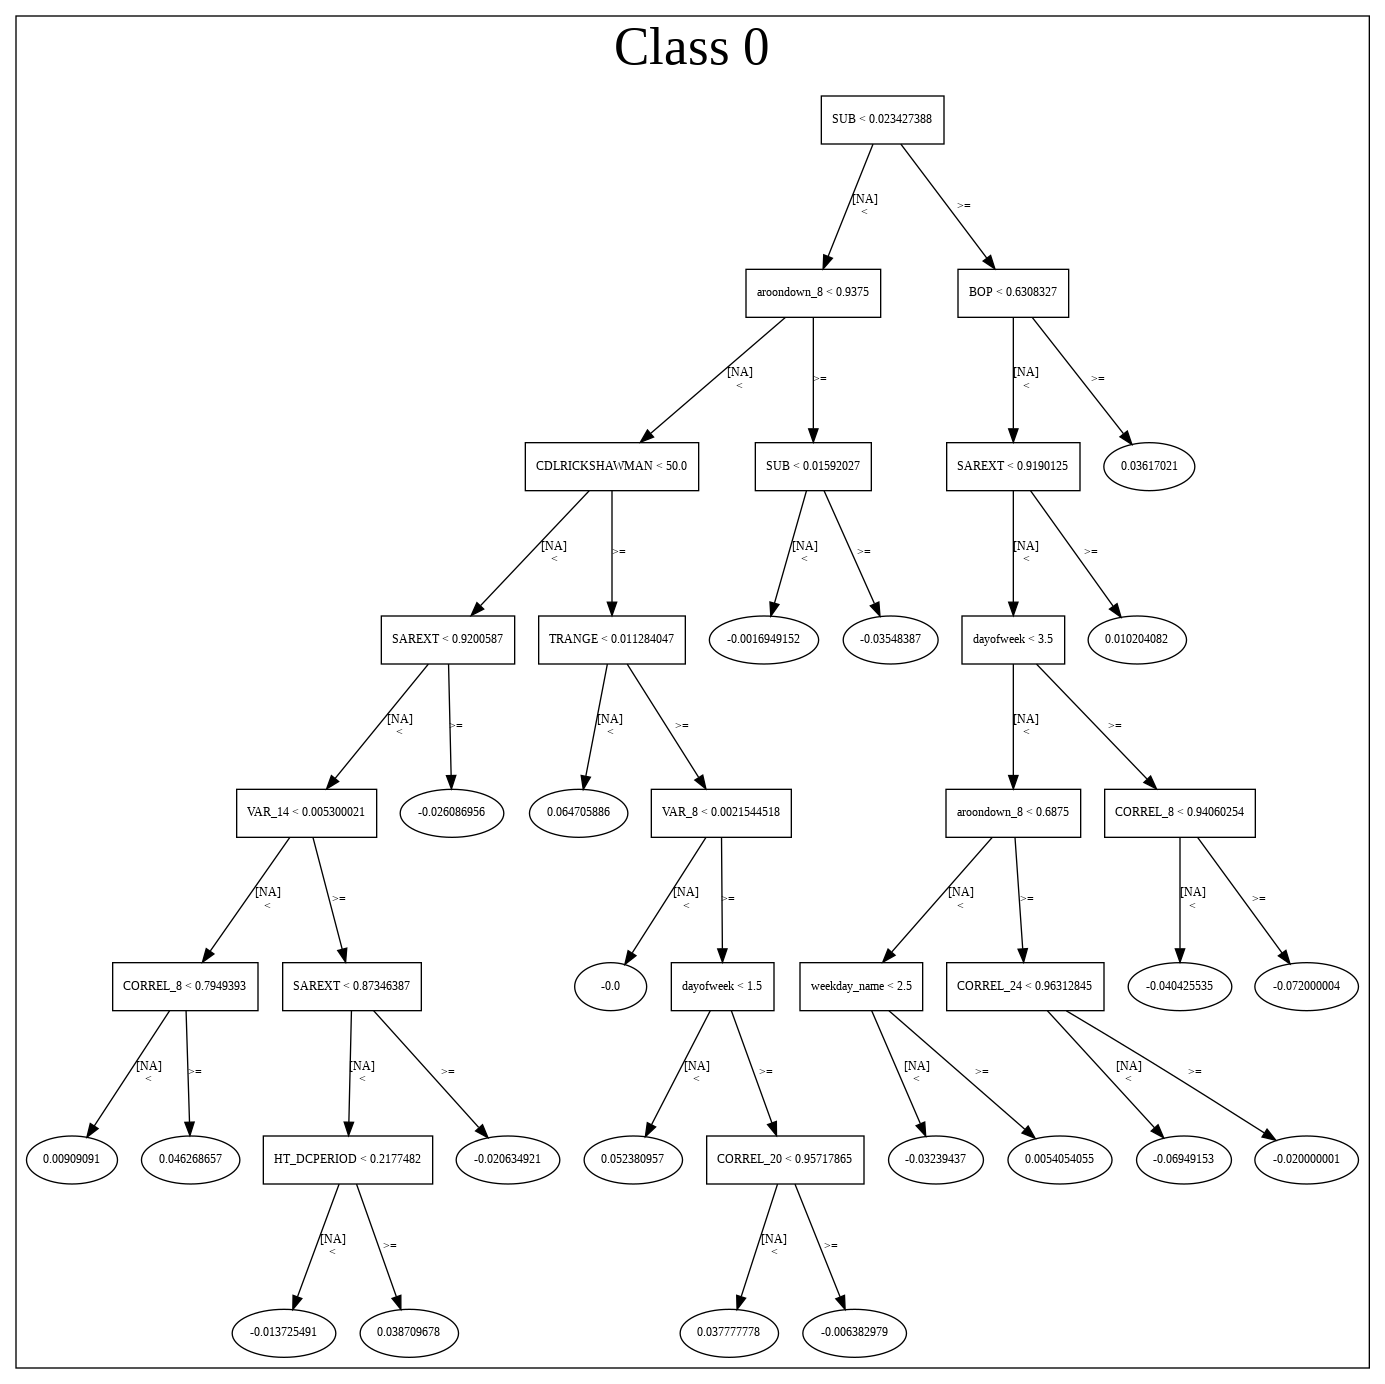

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_130229_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_130229_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLRICKSHAWMAN',
 'MINUS_DM_8',
 'CDLSHORTLINE',
 'BBANDS_lowerband_30_1_5',
 'HT_DCPERIOD',
 'NATR_24',
 'CCI_12',
 'PLUS_DI_8',
 'PLUS_DM_30',
 'ADX_24',
 'NATR_12',
 'MINUS_DM_12',
 'CDLHIGHWAVE',
 'WILLR_8',
 'BBANDS_upperband_20_3_5',
 'DX_30',
 'BBANDS_upperband_14_0_4',
 'BBANDS_upperband_14_7_2',
 'MINUS_DI_24',
 'AROONOSC_14',
 'PLUS_DM_14',
 'MINUS_DI_20',
 'PLUS_DM_12',
 'MAVP_24_2',
 'ADXR_14',
 'MACDFIX_hist_20',
 'RSI_14',
 'aroonup_8',
 'DX_8',
 'TSF_8',
 'MOM_30',
 'aroonup_30',
 'ROCP_14',
 'MOM_12',
 'MACDFIX_hist_24',
 'DX_12',
 'HT_PHASOR_inphase',
 'CMO_12',
 'aroondown_12',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'aroonup_24',
 'RSI_20',
 'ROCR100_30',
 'MACDFIX_signal_12',
 'MACDEXT_signal',
 'STOCHF_fastd',
 'ROCP_30',
 'WILLR_12',
 'MACDFIX_signal_20',
 'STOCHRSI_fastd',
 'ROC_20',
 'MOM_20',
 'CCI_20',
 'RSI_30',
 'ROCR_8',
 'LINEARREG_SLOPE_8',
 'ROCP_20',
 'CCI_24',
 'ROCP_8',
 'WILLR_24',
 'MOM_8',
 'ROCR100_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_131038_model_1  0.589233  0.678005                0.4375  0.492793  0.242845

variable  relative_importance  scaled_importance  percentage
0                   NATR_12             0.821862           1.000000    0.064322
1   BBANDS_upperband_14_7_2             0.574417           0.698922    0.044956
2                PLUS_DM_30             0.554811           0.675066    0.043422
3                    RSI_30             0.513277           0.624530    0.040171
4                    TRANGE             0.504454           0.613794    0.039481
..                      ...                  ...                ...         ...
60                    DX_12             0.024819           0.030198    0.001942
61                  ADXR_14             0.015344           0.018670    0.001201
62              CDLHIGHWAVE             0.004996           0.006079    0.000391
63             CDLSHORTLINE             0.002302           0.002801    0.000180
64              MINUS_DI_24             0.000141           0.000172    0.000011

[65 rows x 4 columns]

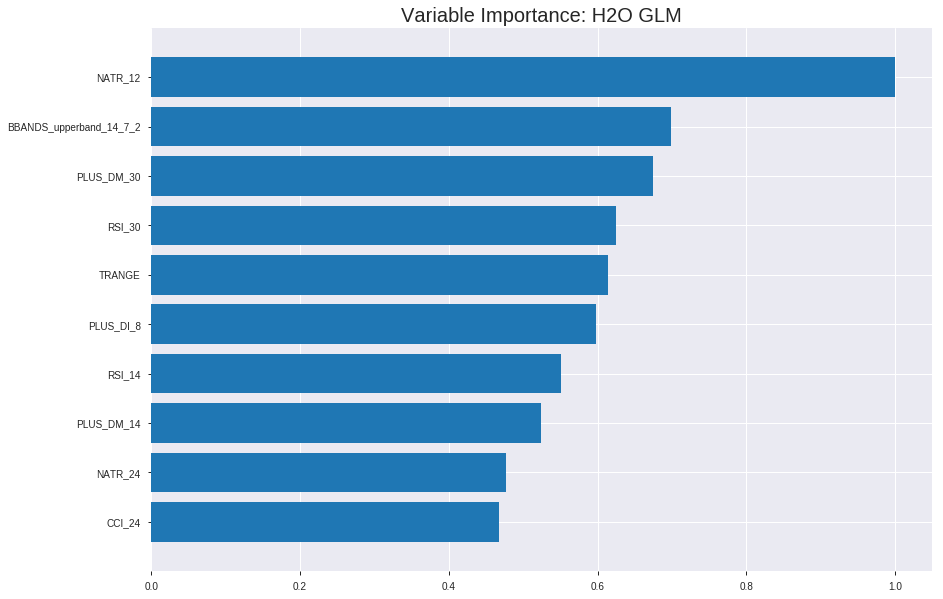

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131038_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2263051932428958
RMSE: 0.47571545407196497
LogLoss: 0.6439045403684578
Null degrees of freedom: 1784
Residual degrees of freedom: 1719
Null deviance: 2474.2390678544516
Residual deviance: 2298.7392091153943
AIC: 2430.7392091153943
AUC: 0.6754222625134351
pr_auc: 0.626942601279811
Gini: 0.35084452502687014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3767908751510968: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      289  615   0.6803   (615.0/904.0)
1      74   807   0.084    (74.0/881.0)
Total  363  1422  0.386    (689.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376791     0.700825  277
max f2                       0.300284     0.834308  320
max f0point5                 0.486283     0.626394  201
max accuracy                 0.486283     0.631373  201
max precision                0.727497     0.709677  30
max recall                   0.0657934    1         394
max specificity              0.867062     0.998894  0
max absolute_mcc             0.376791     0.292765  277
max min_per_class_accuracy   0.509694     0.623156  183
max mean_per_class_accuracy  0.441807     0.632414  233

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.794806           1.23818   1.23818            0.611111         0.817124  0.611111                    0.817124            0.0124858       0.0124858                  23.8176   23.8176
    2        0.0201681                   0.749733           1.35074   1.29446            0.666667         0.773832  0.638889                    0.795478            0.0136209       0.0261067                  35.0738   29.4457
    3        0.0302521                   0.731273           1.4633    1.35074            0.722222         0.739476  0.666667                    0.776811            0.014756        0.0408627                  46.3299   35.0738
    4        0.0403361                   0.719374           1.35074   1.35074            0.666667         0.725852  0.666667                    0.764071            0.0136209       0.0544835                  35.0738   35.0738
    5        0.0504202                   0.710357           1.57586   1.39576            0.777778         0.713911  0.688889                    0.754039            0.015891        0.0703746                  57.5861   39.5762
    6        0.10028                     0.664641           1.41145   1.40356            0.696629         0.686557  0.692737                    0.720486            0.0703746       0.140749                   41.1445   40.356
    7        0.15014                     0.63648            1.43421   1.41374            0.707865         0.650271  0.697761                    0.697169            0.0715096       0.212259                   43.421    41.3739
    8        0.2                         0.612826           1.20656   1.36209            0.595506         0.62377   0.672269                    0.67887             0.0601589       0.272418                   20.6558   36.2089
    9        0.30028                     0.574874           1.17718   1.30034            0.581006         0.593602  0.641791                    0.650395            0.118048        0.390465                   17.7179   30.0337
    10       0.4                         0.544805           1.18379   1.27128            0.58427          0.559538  0.627451                    0.627744            0.118048        0.508513                   18.3793   27.1283
    11       0.50028                     0.508558           1.19982   1.25696            0.592179         0.526077  0.620381                    0.607365            0.120318        0.628831                   19.9817   25.6958
    12       0.6                         0.471019           1.01305   1.21642            0.5              0.490945  0.600373                    0.588016            0.101022        0.729852                   1.30533   21.6421
    13       0.69972                     0.422906           1.00167   1.18582            0.494382         0.447949  0.585268                    0.568055            0.0998865       0.829739                   0.167073  18.5816
    14       0.8                         0.374689           0.871565  1.14642            0.430168         0.398433  0.565826                    0.546793            0.0874007       0.91714                    -12.8435  14.6425
    15       0.89972                     0.299342           0.546366  1.07992            0.269663         0.340493  0.533001                    0.523927            0.0544835       0.971623                   -45.3634  7.99174
    16       1                           4.17493e-07        0.282976  1                  0.139665         0.221075  0.493557                    0.493557          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23994924998473532
RMSE: 0.4898461493007119
LogLoss: 0.6721589540065802
Null degrees of freedom: 509
Residual degrees of freedom: 444
Null deviance: 706.7340007881703
Residual deviance: 685.6021330867118
AIC: 817.6021330867118
AUC: 0.6047001969958139
pr_auc: 0.556716756353417
Gini: 0.2094003939916278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32999769516730526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   223  0.8511   (223.0/262.0)
1      8    240  0.0323   (8.0/248.0)
Total  47   463  0.4529   (231.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329998     0.675105  356
max f2                       0.304779     0.828242  373
max f0point5                 0.415568     0.601852  277
max accuracy                 0.415568     0.603922  277
max precision                0.741386     1         0
max recall                   0.208655     1         396
max specificity              0.741386     1         0
max absolute_mcc             0.415568     0.246832  277
max min_per_class_accuracy   0.494955     0.564516  194
max mean_per_class_accuracy  0.415568     0.610195  277

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 48.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.707913           1.71371   1.71371            0.833333         0.722494  0.833333                    0.722494            0.0201613       0.0201613                  71.371    71.371
    2        0.0215686                   0.696105           0.41129   1.1217             0.2              0.70013   0.545455                    0.712329            0.00403226      0.0241935                  -58.871   12.1701
    3        0.0313725                   0.68311            0.822581  1.02823            0.4              0.689531  0.5                         0.705204            0.00806452      0.0322581                  -17.7419  2.82258
    4        0.0411765                   0.666182           2.05645   1.27304            1                0.67557   0.619048                    0.698149            0.0201613       0.0524194                  105.645   27.3041
    5        0.0509804                   0.653366           1.23387   1.26551            0.6              0.659941  0.615385                    0.690801            0.0120968       0.0645161                  23.3871   26.5509
    6        0.1                         0.621523           1.23387   1.25               0.6              0.636196  0.607843                    0.664034            0.0604839       0.125                      23.3871   25
    7        0.15098                     0.591777           0.949132  1.14841            0.461538         0.603392  0.558442                    0.643557            0.0483871       0.173387                   -5.08685  14.8408
    8        0.2                         0.57497            1.31613   1.18952            0.64             0.585067  0.578431                    0.629222            0.0645161       0.237903                   31.6129   18.9516
    9        0.3                         0.54702            1.00806   1.12903            0.490196         0.560377  0.54902                     0.606273            0.100806        0.33871                    0.806452  12.9032
    10       0.4                         0.522285           0.967742  1.08871            0.470588         0.533912  0.529412                    0.588183            0.0967742       0.435484                   -3.22581  8.87097
    11       0.5                         0.492428           1.29032   1.12903            0.627451         0.507325  0.54902                     0.572011            0.129032        0.564516                   29.0323   12.9032
    12       0.6                         0.463948           1.33065   1.16263            0.647059         0.479213  0.565359                    0.556545            0.133065        0.697581                   33.0645   16.2634
    13       0.7                         0.426936           1.00806   1.14055            0.490196         0.444548  0.554622                    0.540545            0.100806        0.798387                   0.806452  14.0553
    14       0.8                         0.389119           0.846774  1.10383            0.411765         0.405626  0.536765                    0.52368             0.0846774       0.883065                   -15.3226  10.3831
    15       0.9                         0.334828           0.766129  1.06631            0.372549         0.364146  0.518519                    0.505954            0.0766129       0.959677                   -23.3871  6.63082
    16       1                           0.140063           0.403226  1                  0.196078         0.283105  0.486275                    0.483669            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:10:38  0.000 sec   2            .68E1     66            1.3783036242154123  1.3841328655823382
     2019-08-22 13:10:38  0.021 sec   4            .43E1     66            1.3748784303134989  1.3832766945592405
     2019-08-22 13:10:38  0.039 sec   6            .26E1     66            1.3704513435550014  1.3820472146006197
     2019-08-22 13:10:38  0.059 sec   8            .16E1     66            1.364946958265221   1.3803503144206
     2019-08-22 13:10:38  0.077 sec   10           .1E1      66            1.3583796984461152  1.3781123443185306
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:10:39  0.388 sec   40           .8E-3     66            1.2861837552451643  1.3443908332576529
     2019-08-22 13:10:39  0.407 sec   42           .5E-3     66            1.2848272177068472  1.3448430598851517
     2019-08-22 13:10:39  0.426 sec   44           .31E-3    66            1.2836644210286208  1.345627149214503
     2019-08-22 13:10:39  0.449 sec   46           .19E-3    66            1.2825703011416805  1.3468328992693321
     2019-08-22 13:10:39  0.471 sec   48           .12E-3    66            1.2815538085078342  1.3483899041536485


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57421875)

('F1', 0.676300578034682)

('auc', 0.5892333984375)

('logloss', 0.6780048944834356)

('mean_per_class_error', 0.42578125)

('rmse', 0.4927932068909731)

('mse', 0.2428451447578894)

glm prediction progress: |████████████████████████████████████████████████| 100%


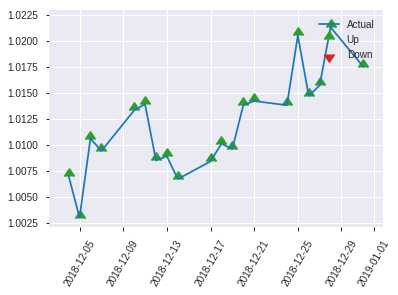


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2428451447578894
RMSE: 0.4927932068909731
LogLoss: 0.6780048944834356
Null degrees of freedom: 255
Residual degrees of freedom: 190
Null deviance: 354.9338629373763
Residual deviance: 347.138505975519
AIC: 479.138505975519
AUC: 0.5892333984375
pr_auc: 0.5890591188201797
Gini: 0.178466796875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3866469104455536: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   101  0.7891   (101.0/128.0)
1      11   117  0.0859   (11.0/128.0)
Total  38   218  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386647     0.676301  217
max f2                       0.284284     0.838794  250
max f0point5                 0.386647     0.585     217
max accuracy                 0.559431     0.574219  84
max precision                0.654267     0.916667  11
max recall                   0.284284     1         250
max specificity              0.698633     0.992188  0
max absolute_mcc             0.654267     0.184805  11
max min_per_class_accuracy   0.505368     0.539062  124
max mean_per_class_accuracy  0.559431     0.574219  84

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.684975           1.33333   1.33333            0.666667         0.693371  0.666667                    0.693371            0.015625        0.015625                   33.3333   33.3333
    2        0.0234375                   0.677555           2         1.66667            1                0.680804  0.833333                    0.687087            0.0234375       0.0390625                  100       66.6667
    3        0.03125                     0.666623           2         1.75               1                0.66903   0.875                       0.682573            0.015625        0.0546875                  100       75
    4        0.0429688                   0.660118           2         1.81818            1                0.663157  0.909091                    0.677278            0.0234375       0.078125                   100       81.8182
    5        0.0507812                   0.65349            1         1.69231            0.5              0.654012  0.846154                    0.673698            0.0078125       0.0859375                  0         69.2308
    6        0.101562                    0.635179           1.23077   1.46154            0.615385         0.645388  0.730769                    0.659543            0.0625          0.148438                   23.0769   46.1538
    7        0.152344                    0.610894           0.923077  1.28205            0.461538         0.621672  0.641026                    0.64692             0.046875        0.195312                   -7.69231  28.2051
    8        0.203125                    0.592713           0.461538  1.07692            0.230769         0.600687  0.538462                    0.635361            0.0234375       0.21875                    -53.8462  7.69231
    9        0.300781                    0.56685            1.44      1.19481            0.72             0.580553  0.597403                    0.617566            0.140625        0.359375                   44        19.4805
    10       0.402344                    0.533769           1         1.14563            0.5              0.551023  0.572816                    0.600769            0.101562        0.460938                   0         14.5631
    11       0.5                         0.499498           0.8       1.07812            0.4              0.518113  0.539062                    0.584625            0.078125        0.539062                   -20       7.8125
    12       0.601562                    0.464928           1.15385   1.09091            0.576923         0.482005  0.545455                    0.5673              0.117188        0.65625                    15.3846   9.09091
    13       0.699219                    0.443703           0.96      1.07263            0.48             0.455315  0.536313                    0.55166             0.09375         0.75                       -4        7.26257
    14       0.800781                    0.406889           1.07692   1.07317            0.538462         0.425153  0.536585                    0.535615            0.109375        0.859375                   7.69231   7.31707
    15       0.898438                    0.359675           0.8       1.04348            0.4              0.387058  0.521739                    0.519467            0.078125        0.9375                     -20       4.34783
    16       1                           0.17506            0.615385  1                  0.307692         0.30788   0.5                         0.497978            0.0

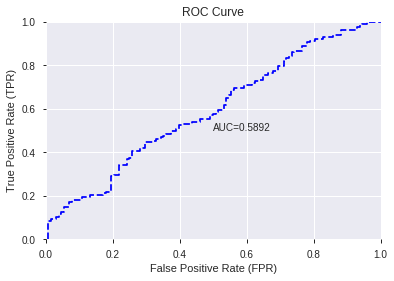

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


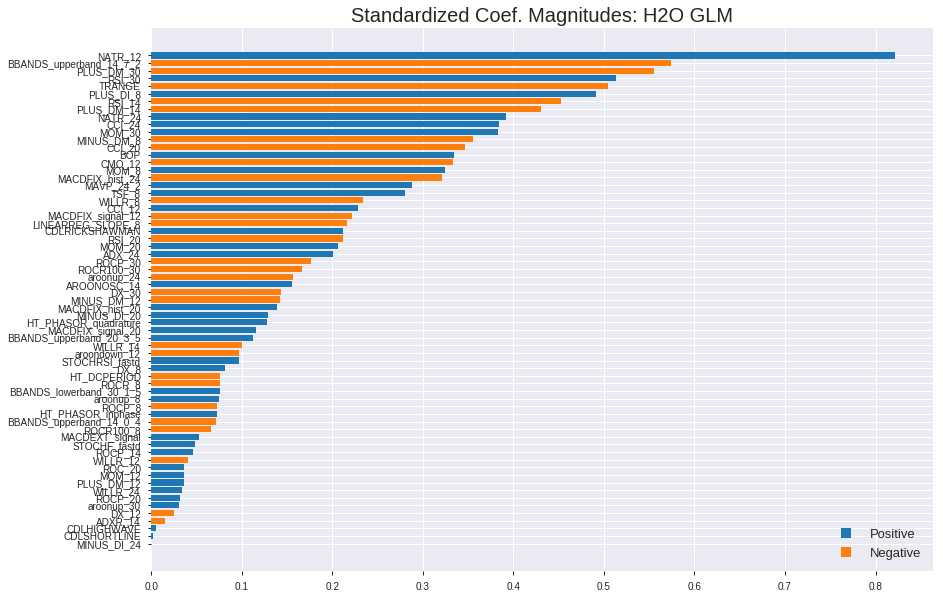

'log_likelihood'
--2019-08-22 13:10:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


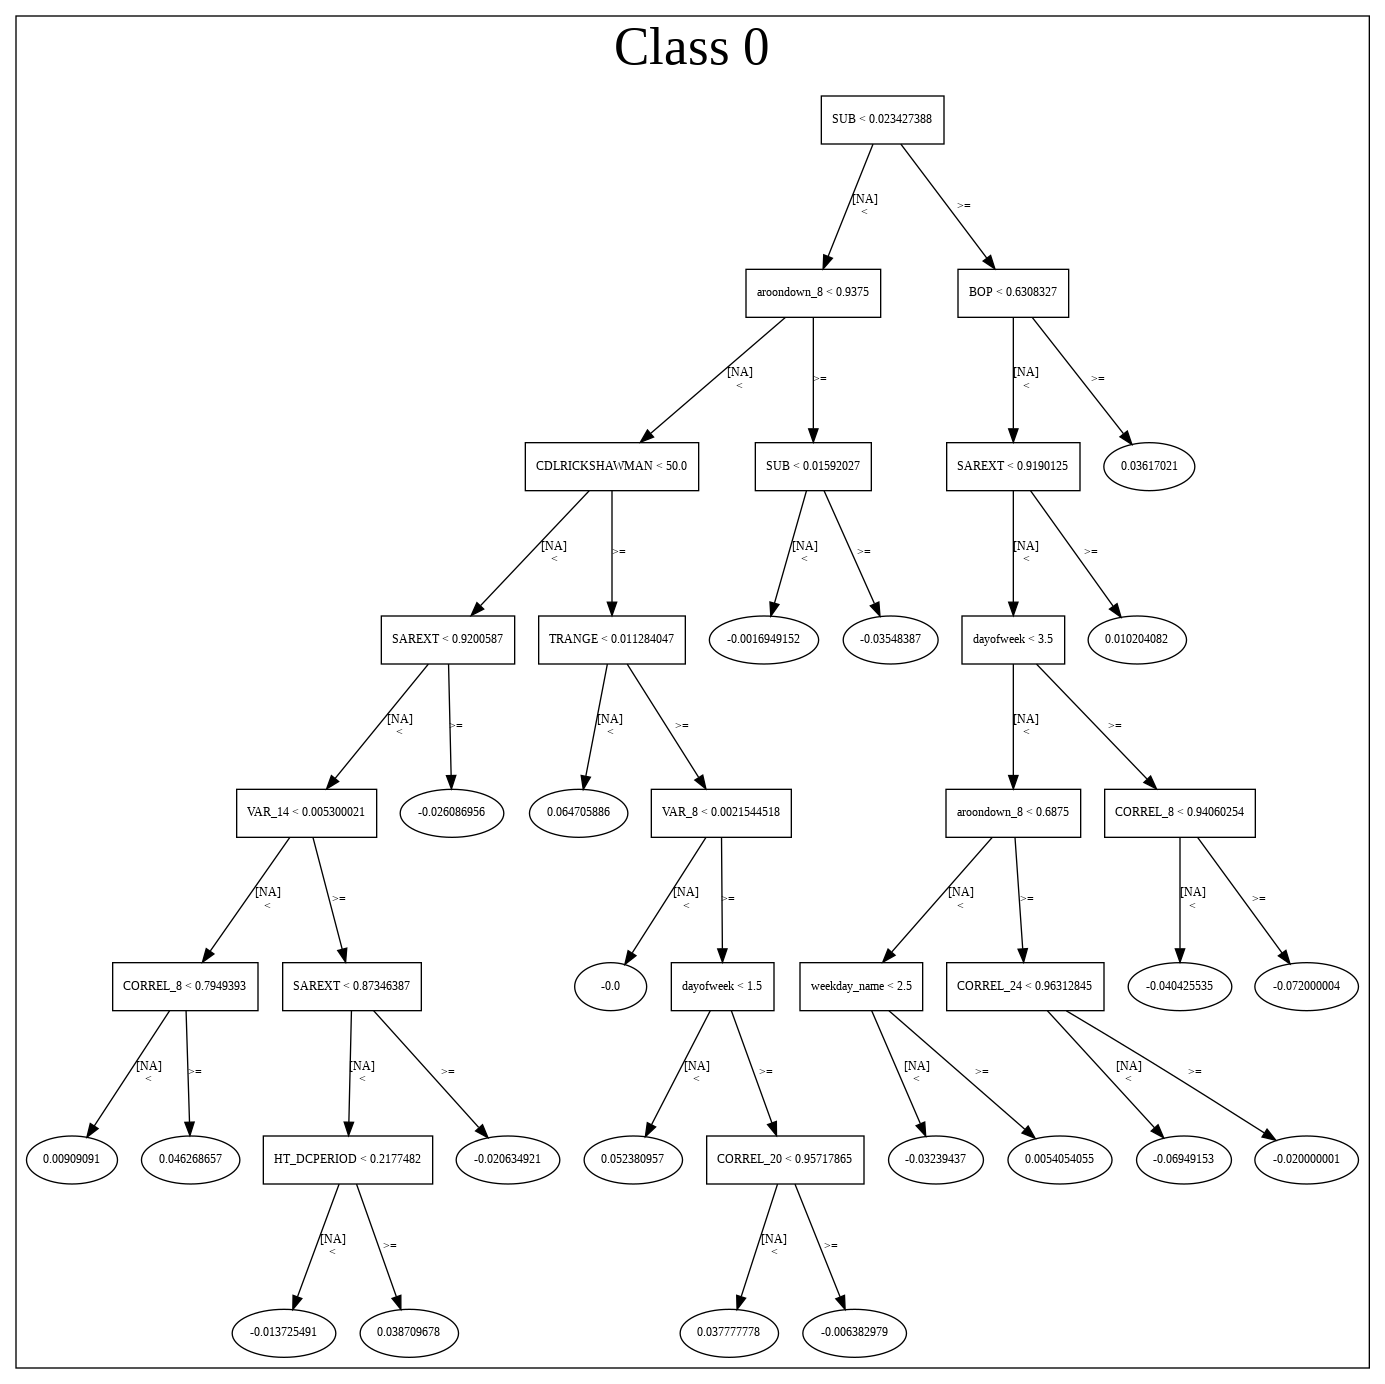

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131038_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131038_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['NATR_12',
 'BBANDS_upperband_14_7_2',
 'PLUS_DM_30',
 'RSI_30',
 'TRANGE',
 'PLUS_DI_8',
 'RSI_14',
 'PLUS_DM_14',
 'NATR_24',
 'CCI_24',
 'MOM_30',
 'MINUS_DM_8',
 'CCI_20',
 'BOP',
 'CMO_12',
 'MOM_8',
 'MACDFIX_hist_24',
 'MAVP_24_2',
 'TSF_8',
 'WILLR_8',
 'CCI_12',
 'MACDFIX_signal_12',
 'LINEARREG_SLOPE_8',
 'CDLRICKSHAWMAN',
 'RSI_20',
 'MOM_20',
 'ADX_24',
 'ROCP_30',
 'ROCR100_30',
 'aroonup_24',
 'AROONOSC_14',
 'DX_30',
 'MINUS_DM_12',
 'MACDFIX_hist_20',
 'MINUS_DI_20',
 'HT_PHASOR_quadrature',
 'MACDFIX_signal_20',
 'BBANDS_upperband_20_3_5',
 'WILLR_14',
 'aroondown_12',
 'STOCHRSI_fastd',
 'DX_8',
 'HT_DCPERIOD',
 'ROCR_8',
 'BBANDS_lowerband_30_1_5',
 'aroonup_8',
 'ROCP_8',
 'HT_PHASOR_inphase',
 'BBANDS_upperband_14_0_4',
 'ROCR100_8',
 'MACDEXT_signal',
 'STOCHF_fastd',
 'ROCP_14',
 'WILLR_12',
 'ROC_20',
 'MOM_12',
 'PLUS_DM_12',
 'WILLR_24',
 'ROCP_20',
 'aroonup_30',
 'DX_12',
 'ADXR_14',
 'CDLHIGHWAVE',
 'CDLSHORTLINE',
 'MINUS_DI_24']

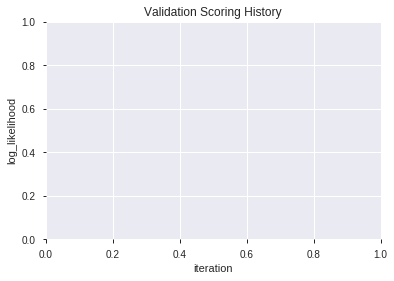

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_131054_model_1  0.622742  0.664915              0.394531  0.486066  0.236260
1               XGBoost_1_AutoML_20190822_131054  0.622192  0.671773              0.464844  0.489457  0.239568
2               XGBoost_2_AutoML_20190822_131054  0.619873  0.672733              0.421875  0.489545  0.239654
3  XGBoost_grid_1_AutoML_20190822_131054_model_2  0.619751  0.669459              0.433594  0.488289  0.238426
4  XGBoost_grid_1_AutoML_20190822_131054_model_3  0.617615  0.670777              0.437500  0.488974  0.239096
5               XGBoost_3_AutoML_20190822_131054  0.615906  0.667098              0.386719  0.487222  0.237386
6  XGBoost_grid_1_AutoML_20190822_131054_model_4  0.607361  0.673267              0.429688  0.490124  0.240222
7  XGBoost_grid_1_AutoML_20190822_131054_model_6  0.603882  0.673259              0.386719  0.490071  0.240170
8  XGBoost_grid_1_AutoML_20190822_131054_model_5  0.599670  0.696715              0.433594  0.500169  0.250169
9  XGBoost_grid_1_AutoML_20190822_131054_model_7  0.597107  0.688508              0.433594  0.496842  0.246852

variable  relative_importance  scaled_importance  percentage
0                 BOP           588.677185           1.000000    0.109432
1              TRANGE           345.471222           0.586860    0.064221
2   HT_PHASOR_inphase           239.075226           0.406123    0.044443
3        aroondown_12           177.803680           0.302039    0.033053
4         HT_DCPERIOD           159.799469           0.271455    0.029706
..                ...                  ...                ...         ...
56    MACDFIX_hist_20            30.052664           0.051051    0.005587
57            ROCP_30            21.122208           0.035881    0.003927
58       CDLSHORTLINE            18.176607           0.030877    0.003379
59         ROCR100_30            11.850687           0.020131    0.002203
60        CDLHIGHWAVE             4.061648           0.006900    0.000755

[61 rows x 4 columns]

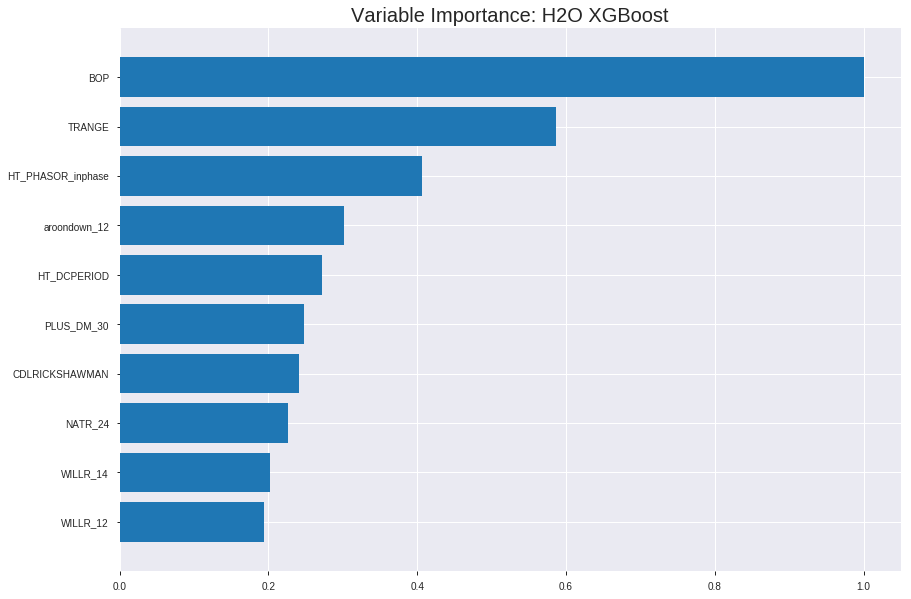

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_131054_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1800627263486964
RMSE: 0.4243379859836925
LogLoss: 0.5463860893496679
Mean Per-Class Error: 0.1854477012244734
AUC: 0.9021877793738008
pr_auc: 0.9020667569437791
Gini: 0.8043755587476016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4832202692826589: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      668  236   0.2611   (236.0/904.0)
1      99   782   0.1124   (99.0/881.0)
Total  767  1018  0.1877   (335.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48322      0.823591  211
max f2                       0.431768     0.890955  249
max f0point5                 0.550019     0.828705  148
max accuracy                 0.49576      0.814006  199
max precision                0.87273      1         0
max recall                   0.253513     1         356
max specificity              0.87273      1         0
max absolute_mcc             0.48322      0.632801  211
max min_per_class_accuracy   0.506051     0.806416  189
max mean_per_class_accuracy  0.49461      0.814552  200

Gains/Lift Table: Avg response rate: 49.36 %, avg score: 49.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.769648           2.02611    2.02611            1                0.825774  1                           0.825774            0.0204313       0.0204313                  102.611   102.611
    2        0.0201681                   0.736646           2.02611    2.02611            1                0.748111  1                           0.786943            0.0204313       0.0408627                  102.611   102.611
    3        0.0302521                   0.715146           2.02611    2.02611            1                0.725356  1                           0.766414            0.0204313       0.061294                   102.611   102.611
    4        0.0403361                   0.701473           1.91355    1.99797            0.944444         0.708127  0.986111                    0.751842            0.0192963       0.0805902                  91.3545   99.7966
    5        0.0504202                   0.690572           2.02611    2.00359            1                0.695278  0.988889                    0.740529            0.0204313       0.101022                   102.611   100.359
    6        0.10028                     0.653597           2.02611    2.01479            1                0.671095  0.994413                    0.706006            0.101022        0.202043                   102.611   101.479
    7        0.15014                     0.627996           1.91228    1.98075            0.94382          0.641625  0.977612                    0.684626            0.0953462       0.297389                   91.228    98.0746
    8        0.2                         0.604571           1.95781    1.97503            0.966292         0.615764  0.97479                     0.667459            0.0976163       0.395006                   95.7811   97.5028
    9        0.30028                     0.569198           1.70917    1.88624            0.843575         0.585906  0.93097                     0.640224            0.171396        0.566402                   70.9174   88.6245
    10       0.4                         0.533656           1.32038    1.74518            0.651685         0.551268  0.861345                    0.618047            0.131669        0.69807                    32.0384   74.5176
    11       0.50028                     0.505291           1.12058    1.61998            0.553073         0.518941  0.799552                    0.598181            0.112372        0.810443                   12.0584   61.9978
    12       0.6                         0.471094           0.967523   1.51154            0.477528         0.489747  0.746032                    0.58016             0.0964813       0.906924                   -3.24771  51.154
    13       0.69972                     0.433977           0.546366   1.37399            0.269663         0.452555  0.678143                    0.561974            0.0544835       0.961407                   -45.3634  37.3989
    14       0.8                         0.384669           0.215062   1.22872            0.106145         0.410731  0.606443                    0.543016            0.0215664       0.982974                   -78.4938  22.8717
    15       0.89972                     0.317103           0.125209   1.10641            0.0617978        0.355511  0.546077                    0.522234            0.0124858       0.99546                    -87.4791  10.6411
    16       1                           0.100682           0.0452761  1                  0.0223464        0.241653  0.493557                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24294558536843505
RMSE: 0.49289510584751706
LogLoss: 0.678833132762695
Mean Per-Class Error: 0.41059775917261754
AUC: 0.6010219157842895
pr_auc: 0.556367749792962
Gini: 0.20204383156857908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33982881903648376: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    254  0.9695   (254.0/262.0)
1      0    248  0        (0.0/248.0)
Total  8    502  0.498    (254.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339829     0.661333  391
max f2                       0.339829     0.829987  391
max f0point5                 0.529549     0.577243  189
max accuracy                 0.534138     0.590196  179
max precision                0.696389     1         0
max recall                   0.339829     1         391
max specificity              0.696389     1         0
max absolute_mcc             0.529549     0.17909   189
max min_per_class_accuracy   0.522306     0.576336  199
max mean_per_class_accuracy  0.529549     0.589402  189

Gains/Lift Table: Avg response rate: 48.63 %, avg score: 51.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.676673           1.37097   1.37097            0.666667         0.685098  0.666667                    0.685098            0.016129        0.016129                   37.0968   37.0968
    2        0.0215686                   0.66583            1.64516   1.4956             0.8              0.671582  0.727273                    0.678955            0.016129        0.0322581                  64.5161   49.5601
    3        0.0313725                   0.654688           0.822581  1.28528            0.4              0.659973  0.625                       0.673023            0.00806452      0.0403226                  -17.7419  28.5282
    4        0.0411765                   0.64712            0         0.979263           0                0.649057  0.47619                     0.667317            0               0.0403226                  -100      -2.07373
    5        0.0509804                   0.641363           1.23387   1.02823            0.6              0.644401  0.5                         0.66291             0.0120968       0.0524194                  23.3871   2.82258
    6        0.1                         0.614702           1.48065   1.25               0.72             0.627203  0.607843                    0.645406            0.0725806       0.125                      48.0645   25
    7        0.15098                     0.59866            1.18641   1.22853            0.576923         0.605542  0.597403                    0.631946            0.0604839       0.185484                   18.6414   22.853
    8        0.2                         0.583064           1.06935   1.18952            0.52             0.590891  0.578431                    0.621883            0.0524194       0.237903                   6.93548   18.9516
    9        0.3                         0.557323           1.16935   1.1828             0.568627         0.57157   0.575163                    0.605112            0.116935        0.354839                   16.9355   18.2796
    10       0.4                         0.538611           1.20968   1.18952            0.588235         0.547035  0.578431                    0.590593            0.120968        0.475806                   20.9677   18.9516
    11       0.5                         0.522007           1.00806   1.15323            0.490196         0.531948  0.560784                    0.578864            0.100806        0.576613                   0.806452  15.3226
    12       0.6                         0.506355           0.887097  1.10887            0.431373         0.514469  0.539216                    0.568131            0.0887097       0.665323                   -11.2903  10.8871
    13       0.7                         0.4841             1.00806   1.09447            0.490196         0.494336  0.532213                    0.557589            0.100806        0.766129                   0.806452  9.447
    14       0.8                         0.446388           0.887097  1.06855            0.431373         0.46556   0.519608                    0.546086            0.0887097       0.854839                   -11.2903  6.85484
    15       0.9                         0.399891           0.766129  1.03495            0.372549         0.423167  0.503268                    0.532428            0.0766129       0.931452                   -23.3871  3.49462
    16       1                           0.24426            0.685484  1                  0.333333         0.364428  0.486275                    0.515628            0.06


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:10:59  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.506443                         0.5                0.693147              0.5               0                    1                  0.513725
    2019-08-22 13:10:59  0.137 sec   5                  0.488739         0.670754            0.733701        0.713821           1.91947          0.377591                         0.496687           0.686519              0.590495          0.565413             1.76267            0.486275
    2019-08-22 13:10:59  0.205 sec   10                 0.477722         0.649005            0.789576        0.774124           2.02611          0.295238                         0.495729           0.684567              0.582176          0.5413               1.30865            0.480392
    2019-08-22 13:10:59  0.272 sec   15                 0.46801          0.630016            0.821152        0.811288           2.02611          0.285714                         0.495004           0.683066              0.576528          0.552976             2.05645            0.476471
    2019-08-22 13:10:59  0.341 sec   20                 0.459043         0.612526            0.837889        0.83646            2.02611          0.268908                         0.494294           0.681601              0.581476          0.549948             1.02823            0.47451
    2019-08-22 13:10:59  0.411 sec   25                 0.450581         0.596267            0.856924        0.856849           2.02611          0.253221                         0.494542           0.682084              0.576136          0.536942             1.17512            0.458824
    2019-08-22 13:10:59  0.475 sec   30                 0.444728         0.584902            0.865901        0.865145           2.02611          0.229692                         0.49433            0.681673              0.58046           0.541276             0.685484           0.464706
    2019-08-22 13:10:59  0.541 sec   35                 0.439993         0.575748            0.872343        0.872324           2.02611          0.214006                         0.493847           0.680719              0.587848          0.54709              0.685484           0.478431
    2019-08-22 13:10:59  0.608 sec   40                 0.4342           0.564743            0.883889        0.883994           2.02611          0.22409                          0.493088           0.679207              0.596843          0.548816             1.02823            0.482353
    2019-08-22 13:10:59  0.671 sec   45                 0.429572         0.556026            0.89251         0.892196           2.02611          0.205602                         0.493268           0.67959               0.597852          0.552116             1.02823            0.482353
    2019-08-22 13:10:59  0.739 sec   50                 0.424338         0.546386            0.902188        0.902067           2.02611          0.187675                         0.492895           0.678833              0.601022          0.556368             1.37097            0.498039

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                588.6771850585938      1.0                   0.10943201638334266
TRANGE             345.4712219238281      0.5868602193058353    0.06422129713380824
HT_PHASOR_inphase  239.07522583007812     0.40612279853563865   0.04444283674300097
aroondown_12       177.80368041992188     0.30203936033672557   0.03305277622878289
HT_DCPERIOD        159.79946899414062     0.2714551761985392    0.029705887289101708
---                ---                    ---                   ---
MACDFIX_hist_20    30.052663803100586     0.051051178074973814  0.005586633355489478
ROCP_30            21.122207641601562     0.03588079881081033   0.003926508163312017
CDLSHORTLINE       18.176607131958008     0.03087703684345913   0.003378936401722494
ROCR100_30         11.850687026977539     0.02013104521079407   0.0022029808693214284
CDLHIGHWAVE        4.061647891998291      0.006899618322381589  0.0007550391452936732


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.625)

('F1', 0.7089337175792507)

('auc', 0.62274169921875)

('logloss', 0.6649154468280427)

('mean_per_class_error', 0.375)

('rmse', 0.4860661951491325)

('mse', 0.23626034606675458)

xgboost prediction progress: |████████████████████████████████████████████| 100%


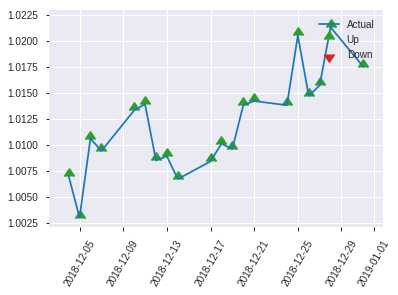


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.23626034606675458
RMSE: 0.4860661951491325
LogLoss: 0.6649154468280427
Mean Per-Class Error: 0.375
AUC: 0.62274169921875
pr_auc: 0.581279384456291
Gini: 0.2454833984375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41381126642227173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   96   0.75     (96.0/128.0)
1      5    123  0.0391   (5.0/128.0)
Total  37   219  0.3945   (101.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413811     0.708934  217
max f2                       0.384408     0.846774  230
max f0point5                 0.469349     0.625     190
max accuracy                 0.469349     0.625     190
max precision                0.802512     1         0
max recall                   0.347149     1         246
max specificity              0.802512     1         0
max absolute_mcc             0.413811     0.299944  217
max min_per_class_accuracy   0.526906     0.5625    125
max mean_per_class_accuracy  0.469349     0.625     190

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.75093            2         2                  1                0.77744   1                           0.77744             0.0234375       0.0234375                  100       100
    2        0.0234375                   0.707794           0.666667  1.33333            0.333333         0.725191  0.666667                    0.751315            0.0078125       0.03125                    -33.3333  33.3333
    3        0.03125                     0.697559           0         1                  0                0.701386  0.5                         0.738833            0               0.03125                    -100      0
    4        0.0429688                   0.692121           1.33333   1.09091            0.666667         0.695021  0.545455                    0.726884            0.015625        0.046875                   33.3333   9.09091
    5        0.0507812                   0.679161           2         1.23077            1                0.687793  0.615385                    0.72087             0.015625        0.0625                     100       23.0769
    6        0.101562                    0.64707            0.923077  1.07692            0.461538         0.661361  0.538462                    0.691116            0.046875        0.109375                   -7.69231  7.69231
    7        0.152344                    0.621345           1.38462   1.17949            0.692308         0.632586  0.589744                    0.671606            0.0703125       0.179688                   38.4615   17.9487
    8        0.203125                    0.608207           1.69231   1.30769            0.846154         0.613098  0.653846                    0.656979            0.0859375       0.265625                   69.2308   30.7692
    9        0.300781                    0.573063           0.72      1.11688            0.36             0.590465  0.558442                    0.635383            0.0703125       0.335938                   -28       11.6883
    10       0.402344                    0.552109           1.15385   1.12621            0.576923         0.559481  0.563107                    0.616224            0.117188        0.453125                   15.3846   12.6214
    11       0.5                         0.526724           1.12      1.125              0.56             0.538769  0.5625                      0.601096            0.109375        0.5625                     12        12.5
    12       0.601562                    0.51259            1.30769   1.15584            0.653846         0.519809  0.577922                    0.587372            0.132812        0.695312                   30.7692   15.5844
    13       0.699219                    0.486131           1.12      1.15084            0.56             0.501972  0.575419                    0.575444            0.109375        0.804688                   12        15.0838
    14       0.800781                    0.441224           1         1.13171            0.5              0.466043  0.565854                    0.561569            0.101562        0.90625                    0         13.1707
    15       0.898438                    0.388999           0.64      1.07826            0.32             0.413575  0.53913                     0.545483            0.0625          0.96875                    -36       7.82609
    16       1                           0.264216           0.307692  1                  0.153846         0.349869  0.5                         0.525616            0.03125   

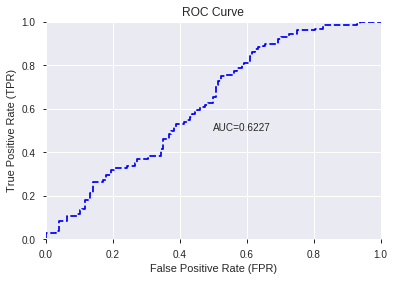

This function is available for GLM models only


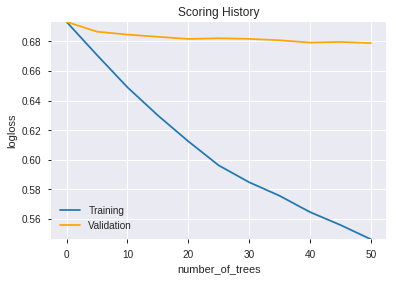

--2019-08-22 13:11:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

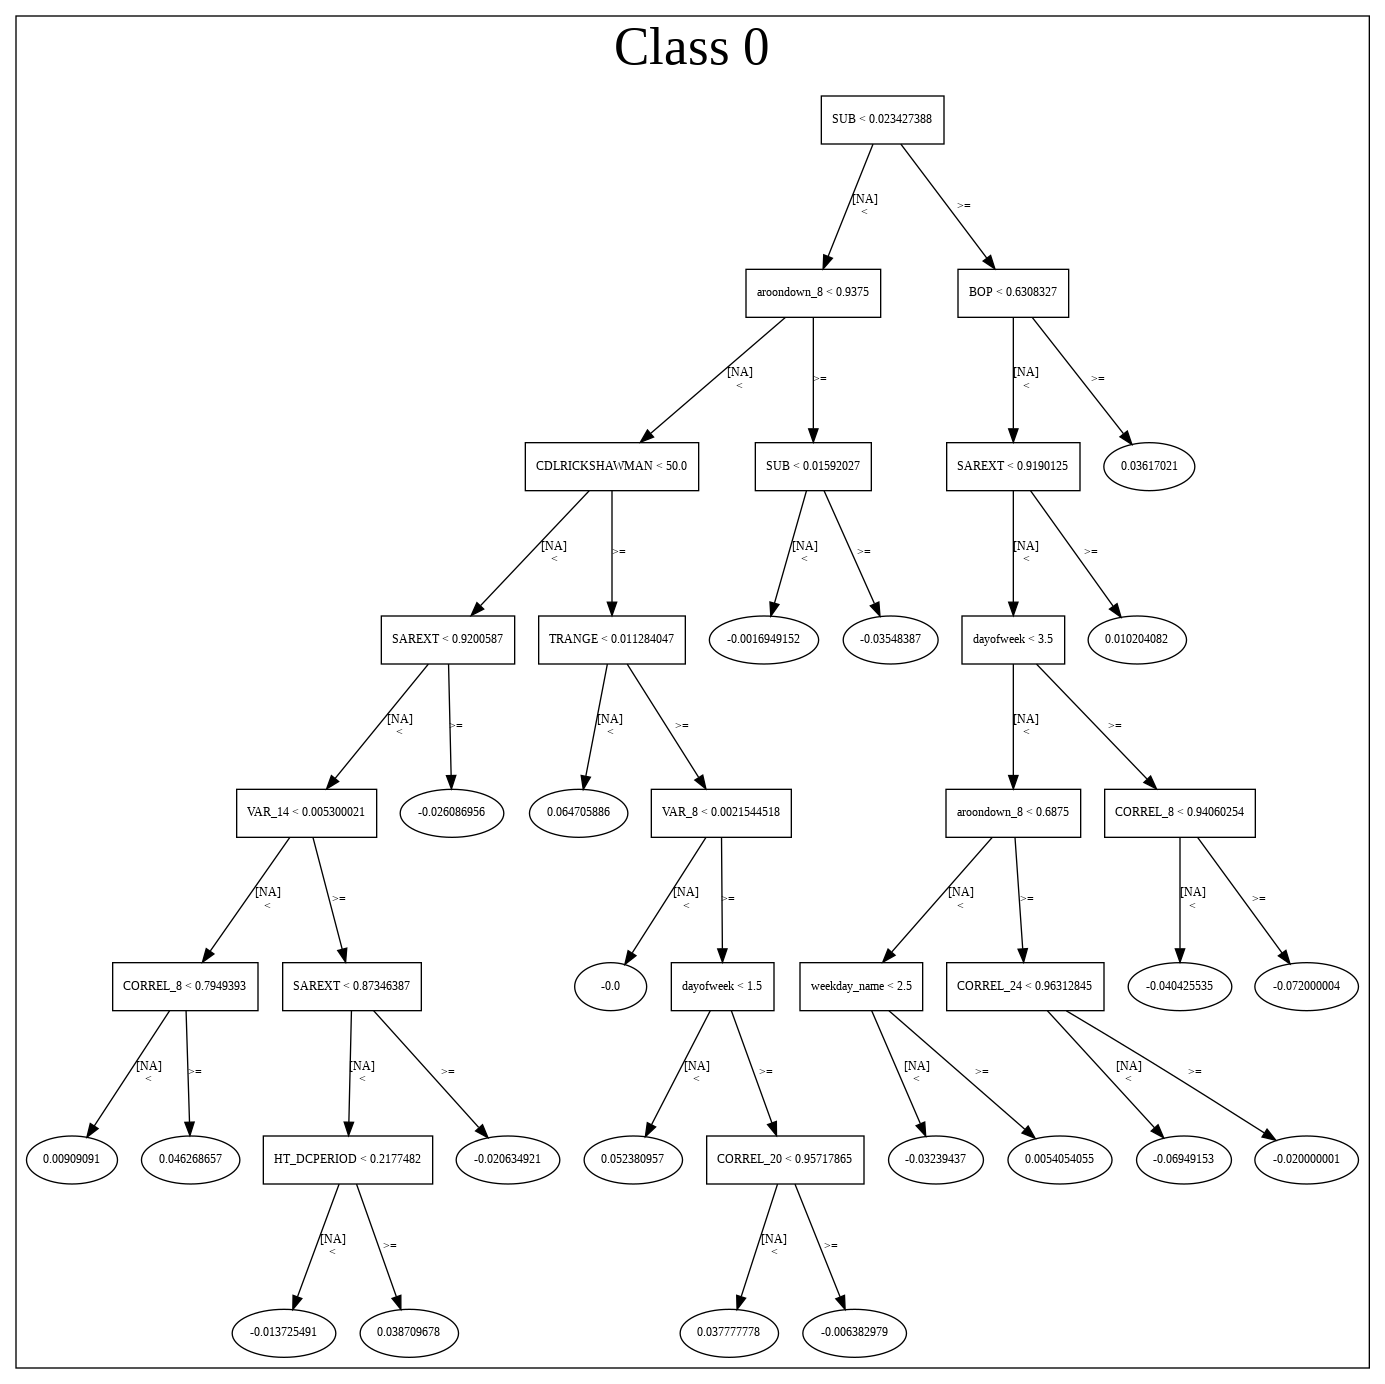

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_131054_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_131054_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a5f6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'HT_PHASOR_inphase',
 'aroondown_12',
 'HT_DCPERIOD',
 'PLUS_DM_30',
 'CDLRICKSHAWMAN',
 'NATR_24',
 'WILLR_14',
 'WILLR_12',
 'BBANDS_upperband_14_0_4',
 'HT_PHASOR_quadrature',
 'ADX_24',
 'MAVP_24_2',
 'MINUS_DM_12',
 'RSI_14',
 'DX_8',
 'BBANDS_upperband_14_7_2',
 'DX_30',
 'RSI_30',
 'WILLR_24',
 'MACDFIX_signal_12',
 'ADXR_14',
 'ROCP_14',
 'CCI_24',
 'MINUS_DI_20',
 'WILLR_8',
 'CMO_12',
 'PLUS_DM_12',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_30_1_5',
 'NATR_12',
 'PLUS_DI_8',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'RSI_20',
 'CCI_20',
 'aroonup_30',
 'MINUS_DM_8',
 'MOM_30',
 'BBANDS_upperband_20_3_5',
 'LINEARREG_SLOPE_8',
 'MACDEXT_signal',
 'PLUS_DM_14',
 'MINUS_DI_24',
 'MOM_8',
 'CCI_12',
 'DX_12',
 'MACDFIX_hist_24',
 'TSF_8',
 'aroonup_24',
 'MOM_12',
 'MOM_20',
 'ROCP_8',
 'ROC_20',
 'AROONOSC_14',
 'MACDFIX_hist_20',
 'ROCP_30',
 'CDLSHORTLINE',
 'ROCR100_30',
 'CDLHIGHWAVE']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.617
GLM             0.609
XGBoost         0.645
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.602    0.602
DLF          0.582  0.609    0.645
Fwe          0.582  0.594    0.613
RFE          0.617  0.574    0.625
XGBF         0.586  0.609    0.645





F1


DeepLearning    0.703
GLM             0.678
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.675  0.678    0.700
DLF          0.678  0.676    0.695
Fwe          0.681  0.672    0.701
RFE          0.703  0.676    0.709
XGBF         0.680  0.676    0.695





auc


DeepLearning    0.637
GLM             0.591
XGBoost         0.650
dtype: float64

DeepLearning    GLM  XGBoost
All          0.561  0.591    0.635
DLF          0.587  0.565    0.650
Fwe          0.587  0.564    0.611
RFE          0.637  0.589    0.623
XGBF         0.589  0.565    0.650





logloss


DeepLearning    1.141
GLM             0.694
XGBoost         0.673
dtype: float64

DeepLearning    GLM  XGBoost
All          0.706  0.687    0.661
DLF          0.678  0.689    0.666
Fwe          0.701  0.694    0.673
RFE          0.664  0.678    0.665
XGBF         1.141  0.689    0.666





mean_per_class_error


DeepLearning    0.430
GLM             0.426
XGBoost         0.398
dtype: float64

DeepLearning    GLM  XGBoost
All          0.430  0.398    0.398
DLF          0.418  0.391    0.355
Fwe          0.418  0.406    0.387
RFE          0.383  0.426    0.375
XGBF         0.414  0.391    0.355





rmse


DeepLearning    0.548
GLM             0.500
XGBoost         0.490
dtype: float64

DeepLearning    GLM  XGBoost
All          0.505  0.495    0.484
DLF          0.493  0.498    0.487
Fwe          0.502  0.500    0.490
RFE          0.486  0.493    0.486
XGBF         0.548  0.498    0.487





mse


DeepLearning    0.30
GLM             0.25
XGBoost         0.24
dtype: float64

DeepLearning    GLM  XGBoost
All          0.255  0.245    0.235
DLF          0.243  0.248    0.237
Fwe          0.252  0.250    0.240
RFE          0.236  0.243    0.236
XGBF         0.300  0.248    0.237

{'F1':       DeepLearning    GLM  XGBoost
 All          0.675    NaN      NaN
 DLF          0.678    NaN      NaN
 DLF            NaN  0.676      NaN
 DLF            NaN    NaN    0.695
 All            NaN  0.678      NaN
 All            NaN    NaN    0.700
 XGBF         0.680    NaN      NaN
 XGBF           NaN  0.676      NaN
 XGBF           NaN    NaN    0.695
 Fwe          0.681    NaN      NaN
 Fwe            NaN  0.672      NaN
 Fwe            NaN    NaN    0.701
 RFE          0.703    NaN      NaN
 RFE            NaN  0.676      NaN
 RFE            NaN    NaN    0.709,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.582    NaN      NaN
 DLF            NaN  0.609      NaN
 DLF            NaN    NaN    0.645
 All            NaN  0.602      NaN
 All            NaN    NaN    0.602
 XGBF         0.586    NaN      NaN
 XGBF           NaN  0.609      NaN
 XGBF           NaN    NaN    0.645
 Fwe          0.582    NaN      NaN
 Fwe     